## Final models training notebook
This notebook is based on this plan:
Planas: Naudoti 650M embeddingus.
Stabilus splitinimas (train/val/test)
Modeliai:
Seku MLP (isbandyti Gumbel) max 32 emb
Strukturu GNN
Mokyti atskirai ir paduodi emb i GNN
Mokyti kartu (Bendra modelio klase)
Testavimas:
Training 2 class, testing 2 class
Training 3 class, testing 3 class (uzdeti argmax thresholda)
Training 3 class, testing 2 class
8 modeliai 12 testu
Experimentai:
Ar seku strukturu apjungimas suveikia.
Kaip geriau suveikia jeigu suveikia.
2 ir 3 klasių mokymas.
is 3 klasiu mokymo DNR ir RNR atskyrimas
Pirma padarau su 2 klasiu ir po to su 3 klasem.


## 1. Imports and setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install torch-geometric

import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
import torch.nn.functional as F
import warnings
from datetime import datetime
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, matthews_corrcoef, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import GATv2Conv


# Suppress FutureWarning from torch.load
warnings.filterwarnings('ignore', category=FutureWarning, module='torch')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Main Configuration

In [2]:
# Experiment metadata
MAIN_CONFIG = {
    # Data paths and structure
    'data': {
        'base_dir': '/content/drive/MyDrive/Magistro_duomenys/graphs',
        'emb_dir': '/content/drive/MyDrive/Magistro_duomenys/emb/650M',

        # Key: class name in directory structure
        'class_configs': {
            'vgDNR': '_pilna_seka_650M',
            'dgDNR': '_pilna_seka_650M',
            'RNR': '_pilna_seka_650M'
        },

        # Data selection
        'train_val_test_split': [0.7, 0.1, 0.2],  # Train, Val, Test split ratios
        'random_seed': 42,
    },

    'models': {
        'save_dir': 'final_models',
    },

}

## 3. Data loading and preprosessing

### Shared functions for MLP and GNN

In [3]:
# ============================================================================
# SHARED BASE FUNCTIONS (used by both MLP and GNN loaders)
# ============================================================================

def load_protein_base(protein_name, class_name, base_dir):
    """
    Load and preprocess protein data - shared by MLP and GNN loaders.

    Returns:
        residue_df: DataFrame with surface residues (aggregated from atoms)
        edges_df: DataFrame with residue-level edges
        metadata: dict with protein info
    """
    # 1. Construct paths
    graph_nodes_path = os.path.join(base_dir, class_name,
                                    f"{protein_name}_chain_A", "graph_nodes.csv")
    graph_edges_path = os.path.join(base_dir, class_name,
                                    f"{protein_name}_chain_A", "graph_links.csv")

    # Check if files exist
    if not os.path.exists(graph_nodes_path):
        return None, None, None

    # 2. Load CSVs
    nodes_df = pd.read_csv(graph_nodes_path)
    edges_df = pd.read_csv(graph_edges_path) if os.path.exists(graph_edges_path) else None

    # 3. Aggregate atoms to residues
    residue_df = aggregate_atoms_to_residues(nodes_df)
    if edges_df is not None:
        edges_df = aggregate_edges_to_residues(edges_df)

    # 4. Filter surface residues (sas_area > 0)
    surface_mask = residue_df['sas_area'] > 0
    residue_df = residue_df[surface_mask].reset_index(drop=True)

    if len(residue_df) == 0:
        return None, None, None

    # 5. Filter edges to surface residues only
    if edges_df is not None and len(edges_df) > 0:
        surface_ids = set(residue_df['ID_resSeq'])
        edge_mask = (edges_df['ID1_resSeq'].isin(surface_ids) &
                     edges_df['ID2_resSeq'].isin(surface_ids))
        edges_df = edges_df[edge_mask].reset_index(drop=True)

    metadata = {
        'protein_name': protein_name,
        'class_name': class_name,
        'n_residues': len(residue_df),
    }

    return residue_df, edges_df, metadata


def create_labels(residue_df, mode='binary'):
    """Create labels from residue dataframe."""
    if mode == 'binary':
        return torch.tensor(residue_df['bsite'].values, dtype=torch.long)
    else:  # multiclass
        y_multi = torch.zeros(len(residue_df), dtype=torch.long)
        for i, row in enumerate(residue_df.itertuples()):
            if row.RNA_bind == 1:
                y_multi[i] = 2  # RNA
            elif row.dsDNA_bind == 1 or row.ssDNA_bind == 1:
                y_multi[i] = 1  # DNA
            else:
                y_multi[i] = 0  # None
        return y_multi


print("Shared base functions loaded!")

Shared base functions loaded!


### MLP loading functions

In [4]:
def load_protein_data(protein_name, class_name,
                      base_dir='grafai/graphs/k95',
                      emb_dir='emb/ESM2/k95',
                      emb_suffix=''):

    # Construct paths
    graph_nodes_path = os.path.join(base_dir, class_name,
                                    f"{protein_name}_chain_A", "graph_nodes.csv")

    embedding_path = os.path.join(emb_dir, f"{class_name}{emb_suffix}", f"{protein_name}.pt")

    # Check if files exist
    if not os.path.exists(graph_nodes_path) or not os.path.exists(embedding_path):
        return None

    try:
        # Load embedding (weights_only=False to suppress warning for trusted files)
        emb_data = torch.load(embedding_path, map_location='cpu', weights_only=False)

        # Extract tensor from ESM-2 format
        if isinstance(emb_data, dict) and 'representations' in emb_data:
            layer_keys = sorted(emb_data['representations'].keys())
            embeddings = emb_data['representations'][layer_keys[-1]]
        else:
            embeddings = emb_data

        # Load graph nodes
        df = pd.read_csv(graph_nodes_path)

        # Aggregate to residue level using ID_resSeq
        residue_data = df.groupby('ID_resSeq').agg({
            'sas_area': 'sum',
            'bsite': 'max',
            'ssDNA_bind': 'max',
            'dsDNA_bind': 'max',
            'RNA_bind': 'max',
            'ev14': 'max',
            'ev28': 'max',
            'ev56': 'max',
            'voromqa_sas_energy': 'sum'
        }).reset_index()

        # Filter surface residues (sas_area > 0)
        surface_mask = residue_data['sas_area'] > 0
        surface_residues = residue_data[surface_mask].copy()

        if len(surface_residues) == 0:
            return None

        # Get ID_resSeq values (these are the actual residue numbers from structure)
        # They can start from any number (e.g., 15) and have gaps
        id_res_seq_values = surface_residues['ID_resSeq'].values

        # CRITICAL: Map ID_resSeq to 0-based embedding indices
        # Embeddings are indexed 0, 1, 2, ... (continuous, no gaps)
        # ID_resSeq might be 15, 16, 17, 20, 21, ... (can have gaps, non-zero start)

        min_res_seq = id_res_seq_values.min()
        max_res_seq = id_res_seq_values.max()
        emb_size = embeddings.shape[0]

        # Convert ID_resSeq to 0-based embedding indices
        # Assumption: ID_resSeq starts at 1 (most common PDB convention)
        if min_res_seq >= 1:
            # Convert to 0-indexed
            embedding_indices = id_res_seq_values - 1
        else:
            # Already 0-indexed or unusual numbering
            embedding_indices = id_res_seq_values

        # Validate indices
        max_idx = embedding_indices.max()
        min_idx = embedding_indices.min()

        if min_idx < 0:
            print(f"Warning [{protein_name}]: Negative indices after conversion. min_idx={min_idx}, min_res_seq={min_res_seq}")
            return None

        if max_idx >= emb_size:
            # print(f"Warning [{protein_name}]: Index out of bounds.")
            # print(f"  Embedding size: {emb_size}")
            # print(f"  ID_resSeq range: {min_res_seq} to {max_res_seq}")
            # print(f"  After 0-indexing: {min_idx} to {max_idx}")
            # print(f"  Surface residues: {len(surface_residues)}")

            # Try to salvage by filtering valid indices
            valid_mask = embedding_indices < emb_size
            if valid_mask.sum() == 0:
                print(f"  No valid indices found. Skipping protein.")
                return None

            # print(f"  Keeping {valid_mask.sum()}/{len(embedding_indices)} residues with valid indices")
            embedding_indices = embedding_indices[valid_mask]
            surface_residues = surface_residues[valid_mask].reset_index(drop=True)

        # Filter embeddings using computed indices
        filtered_embeddings = embeddings[embedding_indices, :]

        # Create binary labels
        y_bin = torch.tensor(surface_residues['bsite'].values, dtype=torch.long)

        # Create multiclass labels - MERGED DNA (ssDNA + dsDNA = DNA)
        # 0 = None, 1 = DNA (ssDNA or dsDNA), 2 = RNA
        y_multi = torch.zeros(len(surface_residues), dtype=torch.long)
        for i, row in enumerate(surface_residues.itertuples()):
            if row.RNA_bind == 1:
                y_multi[i] = 2  # RNA
            elif row.dsDNA_bind == 1 or row.ssDNA_bind == 1:
                y_multi[i] = 1  # DNA (merged)
            else:
                y_multi[i] = 0  # None

        metadata = {
            'protein_name': protein_name,
            'class_name': class_name,
            'n_residues': len(y_multi),
            'embedding_size': emb_size,
            'id_res_seq_range': (int(min_res_seq), int(max_res_seq))
        }

        return filtered_embeddings, y_bin, y_multi, metadata

    except Exception as e:
        print(f"Error loading {protein_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


class ProteinDataset(Dataset):
    """Dataset that loads proteins on-the-fly."""

    def __init__(self, protein_list, class_dict, base_dir='grafai/graphs/k95',
                 emb_dir='emb/ESM2/k95', emb_suffix='', label_type='binary'):
        """

        """
        self.protein_list = protein_list
        self.class_dict = class_dict
        self.base_dir = base_dir
        self.emb_dir = emb_dir
        self.emb_suffix = emb_suffix
        self.label_type = label_type

    def __len__(self):
        return len(self.protein_list)

    def __getitem__(self, idx):
        protein_name = self.protein_list[idx]
        class_name = self.class_dict[protein_name]

        result = load_protein_data(protein_name, class_name, self.base_dir,
                                   self.emb_dir, self.emb_suffix)
        if result is None:
            return None

        embeddings, y_bin, y_multi, metadata = result

        if self.label_type == 'binary':
            return embeddings, y_bin, metadata
        else:
            return embeddings, y_multi, metadata


def collate_fn(batch):
    """Custom collate to handle variable-length proteins."""
    # Filter out None values
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    embeddings_list = [item[0] for item in batch]
    labels_list = [item[1] for item in batch]
    metadata_list = [item[2] for item in batch]

    return embeddings_list, labels_list, metadata_list


## Parallel Loading functions

def load_protein_wrapper(args):
    """Wrapper for parallel loading - unpacks args tuple and calls load_protein_data."""
    protein_name, class_name, base_dir, emb_dir, emb_suffix = args

    result = load_protein_data(protein_name, class_name,
                               base_dir=base_dir, emb_dir=emb_dir,
                               emb_suffix=emb_suffix)
    if result is not None:
        embeddings, y_bin, y_multi, metadata = result
        return protein_name, {
            'embeddings': embeddings,
            'y_bin': y_bin,
            'y_multi': y_multi,
            'metadata': metadata
        }
    return protein_name, None


def load_proteins_parallel(protein_list, class_dict, CLASS_CONFIGS, BASE_DIR, EMB_DIR,
                          desc="Loading", n_workers=None):

    if n_workers is None:
        n_workers = min(multiprocessing.cpu_count(), 8)  # Cap at 8 workers

    args_list = [
        (p, class_dict[p], BASE_DIR, EMB_DIR, CLASS_CONFIGS[class_dict[p]])
        for p in protein_list
    ]

    cache = {}
    failed = []

    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(load_protein_wrapper, args): args[0]
                   for args in args_list}

        for future in tqdm(as_completed(futures), total=len(futures), desc=desc):
            protein_name = futures[future]
            try:
                name, data = future.result()
                if data is not None:
                    cache[name] = data
                else:
                    failed.append(name)
            except Exception as e:
                print(f"Error loading {protein_name}: {e}")
                failed.append(protein_name)

    return cache, failed


print("Functions loaded!")


Functions loaded!


In [5]:
# @title
# ============================================================================
# DIAGNOSTIC: Test loading a few proteins to verify index mapping
# Run this cell to check if the mapping is working correctly
# ============================================================================

test_proteins = [
    ('1a1v_A', 'vgDNR'),
    ('1a31_A', 'dgDNR'),
    ('1a9n_B', 'RNR')
]

print("Testing data loading with new index mapping...\n")

for protein_name, class_name in test_proteins:
    print(f"{'='*70}")
    print(f"Testing: {protein_name} (class: {class_name})")
    print(f"{'='*70}")

    result = load_protein_data(
        protein_name,
        class_name,
        base_dir='grafai/test',
        emb_dir='emb/ESM2/big_model'
    )

    if result is not None:
        embeddings, y_bin, y_multi, metadata = result
        print(f"✓ Successfully loaded {protein_name}")
        print(f"  Embedding size: {metadata['embedding_size']}")
        print(f"  ID_resSeq range: {metadata['id_res_seq_range']}")
        print(f"  Surface residues: {metadata['n_residues']}")
        print(f"  Filtered embeddings shape: {embeddings.shape}")
        print(f"  Labels shape: {y_multi.shape}")

        # Check label distribution
        unique, counts = torch.unique(y_multi, return_counts=True)
        label_names = {0: 'None', 1: 'DNA', 2: 'RNA'}
        print(f"  Label distribution:")
        for label, count in zip(unique.numpy(), counts.numpy()):
            print(f"    {label_names[label]}: {count} ({100*count/len(y_multi):.1f}%)")
    else:
        print(f"✗ Failed to load {protein_name}")

    print()


Testing data loading with new index mapping...

Testing: 1a1v_A (class: vgDNR)
✗ Failed to load 1a1v_A

Testing: 1a31_A (class: dgDNR)
✗ Failed to load 1a31_A

Testing: 1a9n_B (class: RNR)
✗ Failed to load 1a9n_B



## 4. Graphs loading functions

In [6]:

# ============================================================================
# GNN GRAPH CREATION FUNCTIONS (structural features only, no MLP)
# ============================================================================



def normalize_column(values):
    """Min-max normalization to [0, 1]."""
    values = np.array(values, dtype=np.float32)
    min_val, max_val = values.min(), values.max()
    if max_val - min_val > 0:
        return (values - min_val) / (max_val - min_val)
    return np.zeros_like(values)


def normalize_voromqa(values):
    """Specialized normalization for voromqa_sas_energy."""
    values = np.array(values, dtype=np.float32)
    # Shift to non-negative
    if values.min() < 0:
        values = values - values.min()
    # Log transform to compress range
    values = np.log1p(values)
    # Min-max normalize
    return normalize_column(values)


def create_pyg_graph_structural_only(residue_df, edges_df, mode='binary'):
    """
    Create PyG Data object with structural features only (no MLP).

    Node features (5): sas_area, voromqa, ev14, ev28, ev56 (normalized)
    Node attribute: residue_type (int 0-19, for embedding in model)
    Edge features (2): area, boundary
    """
    # Create node features (5 structural)
    node_features = np.stack([
        normalize_column(residue_df['sas_area'].values),
        normalize_voromqa(residue_df['voromqa_sas_energy'].values),
        normalize_column(residue_df['ev14'].values),
        normalize_column(residue_df['ev28'].values),
        normalize_column(residue_df['ev56'].values),
    ], axis=1).astype(np.float32)

    # Residue types are already integers (0-19) in CSV
    residue_types = torch.tensor(residue_df['residue_type'].values, dtype=torch.long)

    # Create edge index and attributes
    if edges_df is not None and len(edges_df) > 0:
        id_to_idx = {id_val: idx for idx, id_val in enumerate(residue_df['ID_resSeq'])}

        # Map edge endpoints to node indices
        src_indices = [id_to_idx[id1] for id1 in edges_df['ID1_resSeq']]
        dst_indices = [id_to_idx[id2] for id2 in edges_df['ID2_resSeq']]

        edge_index = torch.tensor([src_indices, dst_indices], dtype=torch.long)
        edge_attr = torch.tensor(
            edges_df[['area', 'boundary']].values, dtype=torch.float32
        )
    else:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 2), dtype=torch.float32)

    # Create labels
    y = create_labels(residue_df, mode)

    # Create PyG Data object
    return Data(
        x=torch.tensor(node_features, dtype=torch.float32),
        residue_type=residue_types,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        num_nodes=len(residue_df)
    )


def load_protein_gnn(protein_name, class_name, base_dir, mode='binary'):
    """Load a single protein as PyG graph (structural features only)."""
    try:
        residue_df, edges_df, metadata = load_protein_base(protein_name, class_name, base_dir)

        if residue_df is None or len(residue_df) == 0:
            return None

        graph = create_pyg_graph_structural_only(residue_df, edges_df, mode)
        graph.protein_name = protein_name
        graph.class_name = class_name

        return graph
    except Exception as e:
        print(f"Error loading {protein_name}: {e}")
        return None


print("GNN graph creation functions loaded!")

def aggregate_atoms_to_residues(nodes_df, mode='binary'):
    """Aggregate atom-level features to residue-level."""
    if "surface_atom" not in nodes_df.columns:
        nodes_df["surface_atom"] = (nodes_df["sas_area"] > 0.0).astype(int)

    pooling = {
        "residue_type": "first",
        "sas_area": "sum",
        "ev14": "max",
        "ev28": "max",
        "ev56": "max",
        "voromqa_sas_energy": "sum",
    }

    if mode == "binary":
        pooling["bsite"] = "max"
    else:
        pooling["ssDNA_bind"] = "max"
        pooling["dsDNA_bind"] = "max"
        pooling["RNA_bind"] = "max"

    residue_df = nodes_df.groupby("ID_resSeq").agg(pooling).reset_index()
    return residue_df


def aggregate_edges_to_residues(edges_df):
    """Aggregate atom-level edges to residue-level edges."""
    edges_df = edges_df[edges_df["ID1_resSeq"] != edges_df["ID2_resSeq"]].copy()
    edges_df["res1"] = edges_df[["ID1_resSeq", "ID2_resSeq"]].min(axis=1)
    edges_df["res2"] = edges_df[["ID1_resSeq", "ID2_resSeq"]].max(axis=1)

    residue_edges = edges_df.groupby(["res1", "res2"]).agg({
        "area": "sum",
        "boundary": "mean"
    }).reset_index()

    residue_edges = residue_edges.rename(columns={
        "res1": "ID1_resSeq",
        "res2": "ID2_resSeq"
    })
    return residue_edges

# KOL KAS NEREIKALINGOS
def create_pyg_graph_with_mlp(residue_nodes_df, residue_edges_df, protein_class,
                               mode='binary', mlp_probs=None, mlp_embeddings=None):
    # 1) sas_area
    sas_area_normalized = normalize_column(residue_nodes_df["sas_area"].values)
    sas_area_tensor = torch.tensor(sas_area_normalized, dtype=torch.float32).unsqueeze(1)

    # 2) voromqa
    voromqa_norm = normalize_voromqa(residue_nodes_df["voromqa_sas_energy"].values)
    voromqa_tensor = torch.tensor(voromqa_norm, dtype=torch.float32).unsqueeze(1)

    # 3) ev14
    ev14_normalized = normalize_column(residue_nodes_df["ev14"].values)
    ev14_tensor = torch.tensor(ev14_normalized, dtype=torch.float32).unsqueeze(1)

    ev28_normalized = normalize_column(residue_nodes_df["ev28"].values)
    ev28_tensor = torch.tensor(ev14_normalized, dtype=torch.float32).unsqueeze(1)

    ev56_normalized = normalize_column(residue_nodes_df["ev56"].values)
    ev56_tensor = torch.tensor(ev14_normalized, dtype=torch.float32).unsqueeze(1)

    # 4) Residue type as integer indices (NOT one-hot) - will be embedded in model
    residue_types = torch.tensor(residue_nodes_df["residue_type"].values, dtype=torch.long)

    # Base continuous features: 1 (sas) + 1 (voromqa) + 3 (ev) = 5
    node_features = torch.cat([sas_area_tensor, voromqa_tensor, ev14_tensor, ev28_tensor, ev56_tensor], dim=1)

    # 5) add MLP embeddings (vector)
    if mlp_embeddings is not None:
        if not torch.is_tensor(mlp_embeddings):
            mlp_embeddings = torch.tensor(mlp_embeddings, dtype=torch.float32)
        if mlp_embeddings.dim() == 1:
            mlp_embeddings = mlp_embeddings.unsqueeze(1)
        node_features = torch.cat([node_features, mlp_embeddings], dim=1)

    # 6) add MLP probs (scalar)
    if mlp_probs is not None:
        if not torch.is_tensor(mlp_probs):
            mlp_probs = torch.tensor(mlp_probs, dtype=torch.float32)
        if mlp_probs.dim() == 1:
            mlp_probs = mlp_probs.unsqueeze(1)
        node_features = torch.cat([node_features, mlp_probs], dim=1)

    # Labels
    if mode == "binary":
        y = torch.tensor(residue_nodes_df["bsite"].values, dtype=torch.long)
    else:
        def map_labels(row):
            if row["dsDNA_bind"] == 1 or row["ssDNA_bind"] == 1:
                return 1
            elif row["RNA_bind"] == 1:
                return 2
            return 0
        y = torch.tensor(residue_nodes_df.apply(map_labels, axis=1).values, dtype=torch.long)

    # Edge index
    residue_ids = residue_nodes_df["ID_resSeq"].tolist()
    id_map = {rid: idx for idx, rid in enumerate(residue_ids)}
    edge_index = residue_edges_df[["ID1_resSeq", "ID2_resSeq"]].applymap(id_map.get).values.T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Edge attributes
    edge_attr = torch.tensor(residue_edges_df[["area", "boundary"]].values, dtype=torch.float)

    graph_data = Data(
        x=node_features,           # Continuous features only [N, 3 + mlp_emb + mlp_prob]
        residue_type=residue_types, # Integer indices [N] - will be embedded in model
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        num_nodes=residue_nodes_df.shape[0]
    )

    return graph_data


def load_protein_graph_with_mlp(protein_path, protein_id, protein_class, mode='binary',
                                  mlp_model=None, embedding_dirs=None, folder_name=None, device=None):
    """
    Load a single protein graph with MLP probability features.
    """
    nodes_path = os.path.join(protein_path, 'graph_nodes.csv')
    edges_path = os.path.join(protein_path, 'graph_links.csv')

    if not os.path.exists(nodes_path) or not os.path.exists(edges_path):
        return None

    try:
        nodes_df = pd.read_csv(nodes_path)
        edges_df = pd.read_csv(edges_path)

        node_cols = ["atom_index", "residue_type", "sas_area", "ID_resSeq",
                      "ev14", "ev28", "ev56" "voromqa_sas_energy"]
        if mode == "binary":
            node_cols.append("bsite")
        else:
            node_cols.extend(["ssDNA_bind", "dsDNA_bind", "RNA_bind"])

        nodes_df = nodes_df[[col for col in node_cols if col in nodes_df.columns]]
        edges_df = edges_df[["ID1_resSeq", "ID2_resSeq", "area", "boundary"]]

        # Aggregate to residue level
        residue_nodes = aggregate_atoms_to_residues(nodes_df, mode)
        residue_edges = aggregate_edges_to_residues(edges_df)

        # ============ NEW: Get MLP predictions ============
        mlp_probs = None
        mlp_embs  = None
        if mlp_model is not None and embedding_dirs is not None:
              mlp_probs, mlp_embs = get_mlp_predictions(
                  protein_id=protein_id,
                  residue_nodes_df=residue_nodes,
                  mlp_model=mlp_model,
                  embedding_dirs=embedding_dirs,
                  protein_class=protein_class,
                  folder_name=folder_name,
                  device=device,
              )

        pyg_graph = create_pyg_graph_with_mlp(
              residue_nodes,
              residue_edges,
              protein_class,
              mode,
              mlp_probs=mlp_probs,
              mlp_embeddings=mlp_embs,
          )


        return {
            'protein_id': protein_id,
            'protein_class': protein_class,
            'pyg_graph': pyg_graph,
            'num_residues': len(residue_nodes),
            'num_edges': len(residue_edges)
        }

    except Exception as e:
        print(f"Error loading {protein_id}: {e}")
        return None

def get_mlp_predictions(
    protein_id,
    residue_nodes_df,
    mlp_model,
    embedding_dirs,
    protein_class=None,
    folder_name=None,
    device=None,
):
    num_residues = len(residue_nodes_df)
    probs_full = torch.zeros(num_residues, dtype=torch.float32)
    emb_full   = torch.zeros(num_residues, mlp_model.embedding_dim, dtype=torch.float32)

    # Resolve embedding directory for this class/folder
    if isinstance(embedding_dirs, dict):
        if folder_name in embedding_dirs:
            emb_dir = embedding_dirs[folder_name]
        elif protein_class in embedding_dirs:
            emb_dir = embedding_dirs[protein_class]
        elif "default" in embedding_dirs:
            emb_dir = embedding_dirs["default"]
        else:
            print(f"Warning: No embedding dir for folder '{folder_name}', using zeros")
            return probs_full, emb_full
    else:
        emb_dir = embedding_dirs  # single string

    # Derive base protein_name used during MLP training
    if "_chain_" in protein_id:
        protein_name = protein_id.split("_chain_")[0]  # '1jmc_A'
    else:
        protein_name = protein_id

    emb_path = os.path.join(emb_dir, f"{protein_name}.pt")

    if not os.path.exists(emb_path):
        print(f"Warning: No embeddings file for {protein_id} at {emb_path}, using zeros")
        return probs_full, emb_full

    # Surface filter: MLP was trained ONLY on sas_area > 0
    surface_mask = residue_nodes_df["sas_area"].values > 0.0
    surface_indices = np.where(surface_mask)[0]

    if len(surface_indices) == 0:
        # No surface residues → everything stays 0
        return probs_full, emb_full

    try:
        emb_data = torch.load(emb_path, map_location=device)

        # Handle dict with 'representations'
        if isinstance(emb_data, dict) and "representations" in emb_data:
            layer_keys = sorted(emb_data["representations"].keys())
            embeddings = emb_data["representations"][layer_keys[-1]]  # last layer
        else:
            embeddings = emb_data  # raw tensor

        emb_size = embeddings.shape[0]

        # ID_resSeq for SURFACE residues
        id_res_seq_values = residue_nodes_df.loc[surface_mask, "ID_resSeq"].values
        min_res_seq = id_res_seq_values.min()

        # Same mapping logic as training
        if min_res_seq >= 1:
            embedding_indices = id_res_seq_values - 1  # 1-based → 0-based
        else:
            embedding_indices = id_res_seq_values      # already 0-based / weird

        embedding_indices = embedding_indices.astype(int)

        # Validate / clip indices
        max_idx = embedding_indices.max()
        min_idx = embedding_indices.min()

        if min_idx < 0 or max_idx >= emb_size:
            valid_mask = (embedding_indices >= 0) & (embedding_indices < emb_size)
            if valid_mask.sum() == 0:
                print(f"Warning [{protein_id}]: no valid embedding indices, using zeros")
                return probs_full, emb_full

            embedding_indices = embedding_indices[valid_mask]
            surface_indices = surface_indices[valid_mask]

        # Now select embeddings only for surface residues
        embedding_indices_tensor = torch.tensor(embedding_indices, dtype=torch.long)
        filtered_embeddings = embeddings[embedding_indices_tensor, :]  # [N_surface, 5120]

        filtered_embeddings = filtered_embeddings.to(device)
        mlp_model = mlp_model.to(device)
        mlp_model.eval()

        with torch.no_grad():
            logits, emb_surface = mlp_model(
                filtered_embeddings,
                return_probs=False,        # raw logits
                return_embedding=True      # and the hidden repr
            )

            # If binary model: 1 or 2 logits
            if logits.shape[-1] == 1:
                probs_surface = torch.sigmoid(logits).squeeze(-1)
            elif logits.shape[-1] == 2:
                probs2 = F.softmax(logits, dim=-1)
                probs_surface = probs2[:, 1]      # class 1 = binding
            else:
                # 3-class: 0=non-binding, 1=DNA, 2=RNA → binding prob = DNA+RNA
                probs3 = F.softmax(logits, dim=-1)
                probs_surface = probs3[:, 1] + probs3[:, 2]

        # ← THESE MUST BE INSIDE THE try:, but OUTSIDE the 'with'
        probs_full[surface_indices] = probs_surface.cpu()
        emb_full[surface_indices, :] = emb_surface.cpu()

        return probs_full, emb_full

    except Exception as e:
        print(f"Error getting MLP predictions for {protein_id} from {emb_path}: {e}")
        return probs_full, emb_full




    # Parallel CSV loading function
    def load_csv_data(task):
        protein_path, protein_id, protein_class, mode, folder_name = task
        nodes_path = os.path.join(protein_path, 'graph_nodes.csv')
        edges_path = os.path.join(protein_path, 'graph_links.csv')
        if not os.path.exists(nodes_path) or not os.path.exists(edges_path):
            return None
        try:
            nodes_df = pd.read_csv(nodes_path)
            edges_df = pd.read_csv(edges_path)
            node_cols = ["atom_index", "residue_type", "sas_area", "ID_resSeq",
                         "center_x", "center_y", "center_z", "ev14", "ev28", "ev56" "voromqa_sas_energy"]
            if mode == "binary":
                node_cols.append("bsite")
            else:
                node_cols.extend(["ssDNA_bind", "dsDNA_bind", "RNA_bind"])
            nodes_df = nodes_df[[col for col in node_cols if col in nodes_df.columns]]
            edges_df = edges_df[["ID1_resSeq", "ID2_resSeq", "area", "boundary"]]
            residue_nodes = aggregate_atoms_to_residues(nodes_df, mode)
            residue_edges = aggregate_edges_to_residues(edges_df)
            return {
                'protein_id': protein_id, 'protein_class': protein_class,
                'folder_name': folder_name, 'residue_nodes': residue_nodes,
                'residue_edges': residue_edges
            }
        except Exception as e:
            return None

    # Step 1: Load CSVs in parallel with 8 workers
    print(f"\nStep 1: Loading {len(tasks)} CSVs with 8 parallel workers...")
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(load_csv_data, tasks), total=len(tasks), desc="Loading CSVs"))

    results = [r for r in results if r is not None]
    print(f"Loaded {len(results)} CSV files")

    # Step 2: Get MLP predictions (GPU, sequential but fast)
    print(f"\nStep 2: Computing MLP predictions on GPU...")
    if mlp_model is not None:
        mlp_model = mlp_model.to(device)
        mlp_model.eval()

    mlp_features = []
    for data in tqdm(results, desc="MLP inference"):
        mlp_probs, mlp_embs = None, None
        if mlp_model is not None and embedding_dirs is not None:
            mlp_probs, mlp_embs = get_mlp_predictions(
                protein_id=data['protein_id'],
                residue_nodes_df=data['residue_nodes'],
                mlp_model=mlp_model,
                embedding_dirs=embedding_dirs,
                protein_class=data['protein_class'],
                folder_name=data['folder_name'],
                device=device,
            )
        mlp_features.append((mlp_probs, mlp_embs))

    # Step 3: Create PyG graphs in parallel
    print(f"\nStep 3: Creating graphs with 8 parallel workers...")

    def create_graph(args):
        data, mlp_probs, mlp_embs = args
        pyg_graph = create_pyg_graph_with_mlp(
            data['residue_nodes'], data['residue_edges'],
            data['protein_class'], mode, mlp_probs, mlp_embs)
        return {
            'protein_id': data['protein_id'],
            'protein_class': data['protein_class'],
            'pyg_graph': pyg_graph,
            'num_residues': len(data['residue_nodes']),
            'num_edges': len(data['residue_edges'])
        }

    graph_tasks = [(results[i], mlp_features[i][0], mlp_features[i][1]) for i in range(len(results))]

    with ThreadPoolExecutor(max_workers=8) as executor:
        all_graphs = list(tqdm(executor.map(create_graph, graph_tasks), total=len(graph_tasks), desc="Creating graphs"))

    print(f"\nTotal proteins loaded: {len(all_graphs)}")
    class_counts = {}
    for g in all_graphs:
        c = g['protein_class']
        class_counts[c] = class_counts.get(c, 0) + 1
    print("\nClass distribution:")
    for c, count in class_counts.items():
        print(f"  {c}: {count} proteins")

    return all_graphs


# ============================================================================
# PARALLEL GNN LOADING WITH CACHING
# ============================================================================

def load_protein_gnn_wrapper(args):
    """Wrapper for parallel GNN loading."""
    protein_name, class_name, base_dir, mode = args
    graph = load_protein_gnn(protein_name, class_name, base_dir, mode)
    return protein_name, graph


def load_proteins_gnn_sequential(protein_list, class_dict, base_dir, mode='binary', desc="Loading"):
    """Load proteins as PyG graphs sequentially with progress bar (notebook-friendly)."""
    cache = {}
    failed = []

    for protein_name in tqdm(protein_list, desc=desc):
        class_name = class_dict[protein_name]
        graph = load_protein_gnn(protein_name, class_name, base_dir, mode)

        if graph is not None:
            cache[protein_name] = graph
        else:
            failed.append(protein_name)

    return cache, failed

GNN graph creation functions loaded!


## 5. Data Splitting and loading into cache

In [7]:
# Get configuration values
BASE_DIR = MAIN_CONFIG['data']['base_dir']
EMB_DIR = MAIN_CONFIG['data']['emb_dir']
CLASS_CONFIGS = MAIN_CONFIG['data']['class_configs']
RANDOM_SEED = MAIN_CONFIG['data']['random_seed']
TRAIN_VAL_TEST_SPLIT = MAIN_CONFIG['data']['train_val_test_split']

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Automatically discover and select proteins
sample_proteins = {}

for class_name, emb_suffix in CLASS_CONFIGS.items():
    emb_class_dir = f'{class_name}{emb_suffix}'               # e.g. 'vgDNR_pilna_seka_650M'
    class_dir = os.path.join(EMB_DIR, emb_class_dir)

    if os.path.exists(class_dir):
        # Get all .pt files
        all_proteins = sorted([
            f.replace('.pt', '') for f in os.listdir(class_dir)
            if f.endswith('.pt')
        ])

        sample_proteins[class_name] = sorted(all_proteins)
        print(f"{class_name} ({emb_suffix}): Found {len(all_proteins)} proteins, using {len(all_proteins)}")
    else:
        print(f"⚠ Warning: {class_dir} not found")
        sample_proteins[class_name] = []

# Create protein list and class mapping
protein_list = []
class_dict = {}

for class_name, proteins in sample_proteins.items():
    for protein_name in proteins:
        protein_list.append(protein_name)
        class_dict[protein_name] = class_name

print(f"\nTotal proteins: {len(protein_list)}")


# Unpack split ratios
train_ratio, val_ratio, test_ratio = TRAIN_VAL_TEST_SPLIT
total = train_ratio + val_ratio + test_ratio
if not np.isclose(total, 1.0):
    raise ValueError(f"Train/val/test split ratios must sum to 1. Got {total}")

labels_all = [class_dict[p] for p in protein_list]

# 1) Split off TEST first
train_val_proteins, test_proteins = train_test_split(
    protein_list,
    test_size=test_ratio,
    random_state=RANDOM_SEED,
    stratify=labels_all,
)

# 2) Split remaining into TRAIN and VAL
train_val_labels = [class_dict[p] for p in train_val_proteins]
val_fraction_of_trainval = val_ratio / (train_ratio + val_ratio)

train_proteins, val_proteins = train_test_split(
    train_val_proteins,
    test_size=val_fraction_of_trainval,
    random_state=RANDOM_SEED,
    stratify=train_val_labels,
)

print(f"Train proteins: {len(train_proteins)}")
print(f"Val proteins:   {len(val_proteins)}")
print(f"Test proteins:  {len(test_proteins)}")

print(f"\nTrain distribution: {pd.Series([class_dict[p] for p in train_proteins]).value_counts().to_dict()}")
print(f"Val distribution:   {pd.Series([class_dict[p] for p in val_proteins]).value_counts().to_dict()}")
print(f"Test distribution:  {pd.Series([class_dict[p] for p in test_proteins]).value_counts().to_dict()}")



# ============================================================================
# PRE-LOAD ALL PROTEIN DATA INTO MEMORY
# ============================================================================

print(f"\n{'='*60}")
print("PRE-LOADING ALL PROTEIN DATA INTO MEMORY...")
print(f"{'='*60}\n")

train_data_cache = {}
val_data_cache = {}
test_data_cache = {}

print("Loading training proteins (parallel)...")
train_data_cache, train_failed = load_proteins_parallel(
    train_proteins, class_dict, CLASS_CONFIGS, BASE_DIR, EMB_DIR,
    desc="Train", n_workers=8
)

print("\nLoading validation proteins (parallel)...")

val_data_cache, val_failed = load_proteins_parallel(
    val_proteins, class_dict, CLASS_CONFIGS, BASE_DIR, EMB_DIR,
    desc="Val", n_workers=8
)

print("\nLoading test proteins (parallel)...")

test_data_cache, test_failed = load_proteins_parallel(
    test_proteins, class_dict, CLASS_CONFIGS, BASE_DIR, EMB_DIR,
    desc="Test", n_workers=8
)

print(f"\n{'='*60}")
print(f"DATA LOADING COMPLETE!")
print(f"{'='*60}")
print(f"Training proteins loaded:   {len(train_data_cache)}/{len(train_proteins)}")
print(f"Validation proteins loaded: {len(val_data_cache)}/{len(val_proteins)}")
print(f"Test proteins loaded:       {len(test_data_cache)}/{len(test_proteins)}")

print(f"\nTotal residues in training set:   {sum(len(d['y_multi']) for d in train_data_cache.values()):,}")
print(f"Total residues in validation set: {sum(len(d['y_multi']) for d in val_data_cache.values()):,}")
print(f"Total residues in test set:       {sum(len(d['y_multi']) for d in test_data_cache.values()):,}")

# Calculating class distribution for weights
# Calculate class distribution for weighting - USING CACHED DATA
all_labels = []
for protein_name, data in train_data_cache.items():
    all_labels.extend(data['y_bin'].numpy())

all_labels = np.array(all_labels)
unique_classes, class_counts = np.unique(all_labels, return_counts=True)
total = len(all_labels)

# Calculate weights for each class (3 classes: None, DNA, RNA)
class_weights = torch.zeros(2, dtype=torch.float32)
for cls, count in zip(unique_classes, class_counts):
    class_weights[cls] = total / (len(unique_classes) * count)

class_weights = class_weights.to(device)

print(f"Class distribution in training set:")
target_names = ['Non-binding', 'Binding']
for cls, count in zip(unique_classes, class_counts):
    print(f"  {target_names[cls]} ({cls}): {count:,} ({100*count/total:.1f}%)")
print(f"\nClass weights: {class_weights.cpu().numpy()}")



vgDNR (_pilna_seka_650M): Found 108 proteins, using 108
dgDNR (_pilna_seka_650M): Found 789 proteins, using 789
RNR (_pilna_seka_650M): Found 269 proteins, using 269

Total proteins: 1166
Train proteins: 815
Val proteins:   117
Test proteins:  234

Train distribution: {'dgDNR': 552, 'RNR': 188, 'vgDNR': 75}
Val distribution:   {'dgDNR': 79, 'RNR': 27, 'vgDNR': 11}
Test distribution:  {'dgDNR': 158, 'RNR': 54, 'vgDNR': 22}

PRE-LOADING ALL PROTEIN DATA INTO MEMORY...

Loading training proteins (parallel)...


Train: 100%|██████████| 815/815 [02:28<00:00,  5.48it/s]


Loading validation proteins (parallel)...



Val: 100%|██████████| 117/117 [00:23<00:00,  5.03it/s]


Loading test proteins (parallel)...



Test: 100%|██████████| 234/234 [00:45<00:00,  5.14it/s]



DATA LOADING COMPLETE!
Training proteins loaded:   815/815
Validation proteins loaded: 117/117
Test proteins loaded:       234/234

Total residues in training set:   178,940
Total residues in validation set: 25,320
Total residues in test set:       53,859
Class distribution in training set:
  Non-binding (0): 152,221 (85.1%)
  Binding (1): 26,719 (14.9%)

Class weights: [0.58776385 3.3485534 ]


### GNN data loading into cache


In [8]:
# ============================================================================
# LOAD GNN GRAPH DATA (using same protein split as MLP)
# ============================================================================

print(f"\n{'='*60}")
print("LOADING GNN GRAPH DATA (structural features only)")
print(f"{'='*60}\n")

# Use same splits as MLP for fair comparison
train_graph_cache, train_graph_failed = load_proteins_gnn_sequential(
    train_proteins, class_dict, BASE_DIR, mode='binary', desc="Train graphs"
)

val_graph_cache, val_graph_failed = load_proteins_gnn_sequential(
    val_proteins, class_dict, BASE_DIR, mode='binary', desc="Val graphs"
)

test_graph_cache, test_graph_failed = load_proteins_gnn_sequential(
    test_proteins, class_dict, BASE_DIR, mode='binary', desc="Test graphs"
)

print(f"\n{'='*60}")
print("GNN DATA LOADING COMPLETE!")
print(f"{'='*60}")
print(f"Train graphs: {len(train_graph_cache)}/{len(train_proteins)}")
print(f"Val graphs:   {len(val_graph_cache)}/{len(val_proteins)}")
print(f"Test graphs:  {len(test_graph_cache)}/{len(test_proteins)}")

# Count total nodes and edges
n_train_nodes = sum(g.num_nodes for g in train_graph_cache.values())
n_val_nodes = sum(g.num_nodes for g in val_graph_cache.values())
n_test_nodes = sum(g.num_nodes for g in test_graph_cache.values())

n_train_edges = sum(g.edge_index.shape[1] for g in train_graph_cache.values())
n_val_edges = sum(g.edge_index.shape[1] for g in val_graph_cache.values())
n_test_edges = sum(g.edge_index.shape[1] for g in test_graph_cache.values())

print(f"\nTotal nodes - Train: {n_train_nodes:,}, Val: {n_val_nodes:,}, Test: {n_test_nodes:,}")
print(f"Total edges - Train: {n_train_edges:,}, Val: {n_val_edges:,}, Test: {n_test_edges:,}")

# Show sample graph
sample_graph = list(train_graph_cache.values())[0]
print(f"\nSample graph structure:")
print(f"  Node features (x): {sample_graph.x.shape}")
print(f"  Residue types: {sample_graph.residue_type.shape}")
print(f"  Edge index: {sample_graph.edge_index.shape}")
print(f"  Edge attributes: {sample_graph.edge_attr.shape}")
print(f"  Labels (y): {sample_graph.y.shape}")


LOADING GNN GRAPH DATA (structural features only)



Test graphs: 100%|██████████| 234/234 [02:01<00:00,  1.93it/s]


GNN DATA LOADING COMPLETE!
Train graphs: 815/815
Val graphs:   117/117
Test graphs:  234/234

Total nodes - Train: 180,154, Val: 25,556, Test: 54,224
Total edges - Train: 843,009, Val: 119,845, Test: 255,607

Sample graph structure:
  Node features (x): torch.Size([974, 5])
  Residue types: torch.Size([974])
  Edge index: torch.Size([2, 4733])
  Edge attributes: torch.Size([4733, 2])
  Labels (y): torch.Size([974])


### Graphs testing function

In [14]:
# def inspect_graph(graph, n_rows=5):
#     """Print graph structure and sample node features for debugging."""
#     print(f"Protein: {graph.protein_name} ({graph.class_name})")
#     print(f"Nodes: {graph.num_nodes}, Edges: {graph.edge_index.shape[1]}")
#     print(f"\nNode features (x) shape: {graph.x.shape}")
#     print(f"Columns: [sas_area, voromqa, ev14, ev28, ev56]")
#     print(f"\nFirst {n_rows} rows:")
#     print(graph.x[:n_rows])
#     print(f"\nResidue types (first {n_rows}): {graph.residue_type[:n_rows].tolist()}")
#     print(f"Labels (first {n_rows}): {graph.y[:n_rows].tolist()}")

#     # Label distribution
#     unique, counts = graph.y.unique(return_counts=True)
#     print(f"\nLabel distribution:")
#     for u, c in zip(unique.tolist(), counts.tolist()):
#         print(f"  {u}: {c} ({100*c/graph.num_nodes:.1f}%)")

# # Usage:
# sample_graph = list(train_graph_cache.values())[0]
# inspect_graph(sample_graph)

sample_graph = list(train_graph_cache.values())[0]

print(f"Protein: {sample_graph.protein_name}")
print(f"\n{'='*60}")
print("First 5 residues - STRUCTURAL FEATURES (5 dims)")
print("Columns: [sas_area, voromqa, ev14, ev28, ev56]")
print(f"{'='*60}")
print(sample_graph.x[:5])

print(f"\n{'='*60}")
print("First 5 residues - RESIDUE TYPE INDICES")
print(f"{'='*60}")
print(sample_graph.residue_type[:5].tolist())

print(f"\n{'='*60}")
print("First 5 residues - AA EMBEDDINGS from model (32 dims)")
print(f"{'='*60}")
# Look up embeddings from model for these residue types
with torch.no_grad():
    aa_emb = model_gnn.aa_embedding(sample_graph.residue_type[:5].to(device))
print(aa_emb.cpu())

print(f"\n{'='*60}")
print("CONCATENATED INPUT (5 + 32 = 37 dims)")
print(f"{'='*60}")
with torch.no_grad():
    x = sample_graph.x[:5].to(device)
    aa_emb = model_gnn.aa_embedding(sample_graph.residue_type[:5].to(device))
    concat = torch.cat([x, aa_emb], dim=-1)
print(f"Shape: {concat.shape}")
print(concat.cpu())

Protein: 6dtd_A

First 5 residues - STRUCTURAL FEATURES (5 dims)
Columns: [sas_area, voromqa, ev14, ev28, ev56]
tensor([[0.5405, 0.9432, 0.0031, 0.0031, 0.0031],
        [0.2944, 0.8154, 1.0000, 1.0000, 1.0000],
        [0.5449, 0.6472, 1.0000, 1.0000, 1.0000],
        [0.2891, 0.8650, 1.0000, 1.0000, 1.0000],
        [0.6951, 0.7988, 0.4000, 0.3981, 1.0000]])

First 5 residues - RESIDUE TYPE INDICES
[18, 18, 6, 10, 16]

First 5 residues - AA EMBEDDINGS from model (32 dims)
tensor([[-0.8032, -1.1209,  0.1956, -0.7815, -1.7899, -0.2616, -0.4403,  2.1848,
         -0.4801, -1.2872,  0.7389,  0.0339, -0.3123, -0.2542, -1.2055, -0.9542,
          0.0613,  0.0853,  0.7481, -0.1636, -0.9086,  0.3130,  0.8050, -1.1134,
          0.4982, -1.2000,  0.1271,  0.4404,  0.6378,  0.1598,  1.7698,  0.6268],
        [-0.8032, -1.1209,  0.1956, -0.7815, -1.7899, -0.2616, -0.4403,  2.1848,
         -0.4801, -1.2872,  0.7389,  0.0339, -0.3123, -0.2542, -1.2055, -0.9542,
          0.0613,  0.0853,  0.7481

## 6. Loss Functions

In [9]:
class FocalLoss(nn.Module):
    """
    Focal Loss for multiclass classification.
    Addresses class imbalance by down-weighting easy examples and focusing on hard ones.

    Args:
        alpha: Class weights (tensor of shape [num_classes])
        gamma: Focusing parameter (default: 2). Higher gamma = more focus on hard examples
        reduction: 'mean' or 'sum'
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predictions (logits) of shape [N, num_classes]
            targets: Ground truth labels of shape [N] (class indices)
        """
        # Compute cross-entropy loss (without reduction)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Get probabilities
        p = F.softmax(inputs, dim=1)

        # Get probability of correct class for each sample
        p_t = p.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Compute focal loss modulation: (1 - p_t)^gamma
        focal_modulation = (1 - p_t) ** self.gamma

        # Apply focal modulation to cross-entropy
        loss = focal_modulation * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_t = self.alpha.gather(0, targets)
            loss = alpha_t * loss

        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

print("Focal Loss function loaded!")
print(f"\nFocal Loss properties:")
print(f"  - gamma: Controls focus on hard examples (0 = standard CE, 2 = strong focus)")
print(f"  - alpha: Class weights from previous cell")
print(f"  - Reduces overfitting by penalizing confident wrong predictions less")

Focal Loss function loaded!

Focal Loss properties:
  - gamma: Controls focus on hard examples (0 = standard CE, 2 = strong focus)
  - alpha: Class weights from previous cell
  - Reduces overfitting by penalizing confident wrong predictions less


## 7. Binary models training

## 7.1 MLP model training

In [10]:
class BindingSiteMLP(nn.Module):
    """MLP for per-residue binding type prediction."""

    def __init__(self, input_dim=1280, hidden_dims=[256, 64, 32],
                 output_dim=2, dropout=0.4, return_probs=False):
        super(BindingSiteMLP, self).__init__()

        self.return_probs = return_probs  # Flag to return probabilities or logits

        layers = []
        prev_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            layers.append(nn.LayerNorm(hidden_dim))
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x, return_probs=None):
        """
        Args:
            x: Input tensor
            return_probs: If True, returns probabilities. If False, returns logits.
                         If None, uses self.return_probs from initialization.
        """
        logits = self.network(x)

        # Determine whether to return probabilities
        if return_probs is None:
            return_probs = self.return_probs

        if return_probs:
            return F.softmax(logits, dim=1)  # Convert to probabilities
        else:
            return logits  # Return raw logits (for training with CrossEntropyLoss)


# Initialize model - 2 classes: Binding and non-binding
model = BindingSiteMLP(input_dim=1280, hidden_dims=[1024, 256, 64, 32],
                       output_dim=2, dropout=0.4, return_probs=False)
model = model.to(device)

print(f"Model architecture")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture
BindingSiteMLP(
  (network): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.4, inplace=False)
    (11): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.4, inplace=False)
    (15): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (16): Linear(in_features=32, out_features=2, bias=True)
  )
)

Total parameters: 1,595,490


### Training loop

In [15]:
def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

model.apply(reset_weights)

BindingSiteMLP(
  (network): Sequential(
    (0): Linear(in_features=5120, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.4, inplace=False)
    (11): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.4, inplace=False)
    (15): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (16): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [16]:
# ============================================================================
# MLP TRAINING CONFIGURATION (Batched)
# ============================================================================


# Training configuration
criterion_mlp = FocalLoss(alpha=class_weights, gamma=2.0, reduction='mean')
optimizer_mlp = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
batch_size = 1  # Number of proteins per batch
THRESHOLD = 0.66

print("Using Focal Loss!")
print(f"  - Alpha (class weights): {class_weights.cpu().numpy()}")
print(f"  - Gamma (focusing parameter): 2.0")
print(f"  - Batch size: {batch_size} proteins\n")

# Early stopping configuration
PATIENCE = 10

# Training history
train_losses_mlp = []
train_balanced_accs_mlp = []
val_losses_mlp = []
val_balanced_accs_mlp = []
val_roc_aucs_mlp = []
val_pr_aucs_mlp = []

# Early stopping variables
best_val_pr_auc_mlp = 0.0
patience_counter = 0
best_model_state_mlp = None

print("Starting MLP training (Batched)...\n")
print(f"Classes: 0=Non-binding, 1=Binding")
print(f"Early stopping: patience={PATIENCE} (monitoring val PR AUC)\n")

train_protein_names = list(train_data_cache.keys())
val_protein_names = list(val_data_cache.keys())

for epoch in range(num_epochs):
    # ===== TRAINING =====
    model.train()
    epoch_loss = 0.0
    epoch_n_residues = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_protein_names)

    # Process in batches of proteins
    for i in tqdm(range(0, len(train_protein_names), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        batch_proteins = train_protein_names[i:i + batch_size]

        # Collect embeddings and labels from batch
        batch_embeddings = []
        batch_labels = []
        for protein_name in batch_proteins:
            data = train_data_cache[protein_name]
            batch_embeddings.append(data['embeddings'])
            batch_labels.append(data['y_bin'])

        # Concatenate into single tensors
        batch_embeddings = torch.cat(batch_embeddings, dim=0).to(device)
        batch_labels = torch.cat(batch_labels, dim=0).to(device)

        optimizer_mlp.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion_mlp(outputs, batch_labels)
        loss.backward()
        optimizer_mlp.step()

        # Statistics
        epoch_loss += loss.item() * len(batch_labels)
        epoch_n_residues += len(batch_labels)

        probs = F.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= THRESHOLD).long()

        epoch_all_labels.extend(batch_labels.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    # Train metrics
    train_loss = epoch_loss / epoch_n_residues
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

    train_losses_mlp.append(train_loss)
    train_balanced_accs_mlp.append(train_bal_acc)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    val_n_residues = 0
    val_all_labels = []
    val_all_preds = []
    val_all_probs = []

    with torch.no_grad():
        for i in range(0, len(val_protein_names), batch_size):
            batch_proteins = val_protein_names[i:i + batch_size]

            batch_embeddings = []
            batch_labels = []
            for protein_name in batch_proteins:
                data = val_data_cache[protein_name]
                batch_embeddings.append(data['embeddings'])
                batch_labels.append(data['y_bin'])

            batch_embeddings = torch.cat(batch_embeddings, dim=0).to(device)
            batch_labels = torch.cat(batch_labels, dim=0).to(device)

            outputs = model(batch_embeddings)
            loss = criterion_mlp(outputs, batch_labels)
            probs = F.softmax(outputs, dim=1)

            val_loss += loss.item() * len(batch_labels)
            val_n_residues += len(batch_labels)

            predicted = (probs[:, 1] >= THRESHOLD).long()

            val_all_labels.extend(batch_labels.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.extend(probs[:, 1].cpu().numpy())

    # Val metrics
    val_loss = val_loss / val_n_residues
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
    val_roc_auc = roc_auc_score(val_all_labels, val_all_probs)
    val_pr_auc = average_precision_score(val_all_labels, val_all_probs)

    val_losses_mlp.append(val_loss)
    val_balanced_accs_mlp.append(val_bal_acc)
    val_roc_aucs_mlp.append(val_roc_auc)
    val_pr_aucs_mlp.append(val_pr_auc)

    # Early stopping check (on PR AUC)
    if val_pr_auc > best_val_pr_auc_mlp:
        best_val_pr_auc_mlp = val_pr_auc
        patience_counter = 0
        best_model_state_mlp = model.state_dict().copy()
        improvement_marker = " +"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, ROC-AUC: {val_roc_auc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} "
          f"| Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} (best val PR-AUC: {best_val_pr_auc_mlp:.4f})")
        break

# Restore best model
if best_model_state_mlp is not None:
    model.load_state_dict(best_model_state_mlp)
    print(f"\n* Restored best model (val PR-AUC: {best_val_pr_auc_mlp:.4f})")

print(f"\n{'='*60}")
print(f"MLP Training complete!")
print(f"Best Validation PR AUC: {best_val_pr_auc_mlp:.4f}")
print(f"{'='*60}")

Using Focal Loss!
  - Alpha (class weights): [0.58776385 3.3485534 ]
  - Gamma (focusing parameter): 2.0
  - Batch size: 1 proteins

Starting MLP training (Batched)...

Classes: 0=Non-binding, 1=Binding
Early stopping: patience=10 (monitoring val PR AUC)



Epoch [1/50] - Train Loss: 0.1351, Bal-Acc: 0.6603 | Val Bal-Acc: 0.7338, ROC-AUC: 0.8833, PR-AUC: 0.6369 + | Patience: 0/10


Epoch [2/50] - Train Loss: 0.1101, Bal-Acc: 0.7182 | Val Bal-Acc: 0.7420, ROC-AUC: 0.8924, PR-AUC: 0.6600 + | Patience: 0/10


Epoch [3/50] - Train Loss: 0.1007, Bal-Acc: 0.7337 | Val Bal-Acc: 0.7557, ROC-AUC: 0.8914, PR-AUC: 0.6529 | Patience: 1/10


Epoch [4/50] - Train Loss: 0.0957, Bal-Acc: 0.7406 | Val Bal-Acc: 0.7591, ROC-AUC: 0.8939, PR-AUC: 0.6699 + | Patience: 0/10


Epoch [5/50] - Train Loss: 0.0904, Bal-Acc: 0.7541 | Val Bal-Acc: 0.6987, ROC-AUC: 0.8901, PR-AUC: 0.6646 | Patience: 1/10


Epoch [6/50] - Train Loss: 0.0853, Bal-Acc: 0.7610 | Val Bal-Acc: 0.7380, ROC-AUC: 0.8882, PR-AUC: 0.6623 | Patience: 2/10


Epoch [7/50] - Train Loss: 0.0820, Bal-Acc: 0.7769 | Val Bal-Acc: 0.7819, ROC-AUC: 0.8916, PR-AUC: 0.6682 | Patience: 3/10


Epoch [8/50] - Train Loss: 0.0767, Bal-Acc: 0.7848 | Val Bal-Acc: 0.7389, ROC-AUC: 0.8921, PR-AUC: 0.6739 + | Patience: 0/10


Epoch [9/50] - Train Loss: 0.0737, Bal-Acc: 0.7936 | Val Bal-Acc: 0.7831, ROC-AUC: 0.8942, PR-AUC: 0.6811 + | Patience: 0/10


Epoch [10/50] - Train Loss: 0.0686, Bal-Acc: 0.8077 | Val Bal-Acc: 0.7220, ROC-AUC: 0.8847, PR-AUC: 0.6743 | Patience: 1/10


Epoch [11/50] - Train Loss: 0.0661, Bal-Acc: 0.8184 | Val Bal-Acc: 0.7594, ROC-AUC: 0.8891, PR-AUC: 0.6778 | Patience: 2/10


Epoch [12/50] - Train Loss: 0.0612, Bal-Acc: 0.8290 | Val Bal-Acc: 0.7958, ROC-AUC: 0.8903, PR-AUC: 0.6758 | Patience: 3/10


Epoch [13/50] - Train Loss: 0.0582, Bal-Acc: 0.8392 | Val Bal-Acc: 0.7726, ROC-AUC: 0.8917, PR-AUC: 0.6807 | Patience: 4/10


Epoch [14/50] - Train Loss: 0.0537, Bal-Acc: 0.8510 | Val Bal-Acc: 0.7394, ROC-AUC: 0.8700, PR-AUC: 0.6700 | Patience: 5/10


Epoch [15/50] - Train Loss: 0.0534, Bal-Acc: 0.8535 | Val Bal-Acc: 0.7396, ROC-AUC: 0.8800, PR-AUC: 0.6747 | Patience: 6/10


Epoch [16/50] - Train Loss: 0.0503, Bal-Acc: 0.8582 | Val Bal-Acc: 0.7406, ROC-AUC: 0.8918, PR-AUC: 0.6833 + | Patience: 0/10


Epoch [17/50] - Train Loss: 0.0476, Bal-Acc: 0.8693 | Val Bal-Acc: 0.7178, ROC-AUC: 0.8718, PR-AUC: 0.6726 | Patience: 1/10


Epoch [18/50] - Train Loss: 0.0500, Bal-Acc: 0.8631 | Val Bal-Acc: 0.7588, ROC-AUC: 0.8790, PR-AUC: 0.6693 | Patience: 2/10


Epoch [19/50] - Train Loss: 0.0447, Bal-Acc: 0.8782 | Val Bal-Acc: 0.7787, ROC-AUC: 0.8906, PR-AUC: 0.6777 | Patience: 3/10


Epoch [20/50] - Train Loss: 0.0423, Bal-Acc: 0.8858 | Val Bal-Acc: 0.7641, ROC-AUC: 0.8751, PR-AUC: 0.6697 | Patience: 4/10


Epoch [21/50] - Train Loss: 0.0407, Bal-Acc: 0.8916 | Val Bal-Acc: 0.7438, ROC-AUC: 0.8870, PR-AUC: 0.6641 | Patience: 5/10


Epoch [22/50] - Train Loss: 0.0397, Bal-Acc: 0.8932 | Val Bal-Acc: 0.7790, ROC-AUC: 0.8684, PR-AUC: 0.6611 | Patience: 6/10


Epoch [23/50] - Train Loss: 0.0400, Bal-Acc: 0.8929 | Val Bal-Acc: 0.7530, ROC-AUC: 0.8845, PR-AUC: 0.6725 | Patience: 7/10


Epoch [24/50] - Train Loss: 0.0377, Bal-Acc: 0.9036 | Val Bal-Acc: 0.7536, ROC-AUC: 0.8747, PR-AUC: 0.6672 | Patience: 8/10


Epoch [25/50] - Train Loss: 0.0366, Bal-Acc: 0.9029 | Val Bal-Acc: 0.7894, ROC-AUC: 0.8598, PR-AUC: 0.6654 | Patience: 9/10


Epoch [26/50] - Train Loss: 0.0370, Bal-Acc: 0.9044 | Val Bal-Acc: 0.7572, ROC-AUC: 0.8700, PR-AUC: 0.6722 | Patience: 10/10

Early stopping at epoch 26 (best val PR-AUC: 0.6833)

* Restored best model (val PR-AUC: 0.6833)

MLP Training complete!
Best Validation PR AUC: 0.6833


### Evaluation on test set

In [13]:
THRESHOLD = 0.66
model.eval()
all_predictions = []
all_labels = []
all_probabilities = []  # Store raw probabilities

print("Evaluating on test set (using cached data)...\n")
print("Model will return PROBABILITIES (not logits) during evaluation.\n")

with torch.no_grad():
    for protein_name, data in tqdm(test_data_cache.items(), desc="Evaluating"):
        embeddings = data['embeddings'].to(device)
        labels = data['y_bin']  # Binary labels (0=Non-binding, 1=Binding)
        metadata = data['metadata']

        # Get probabilities instead of logits
        probs = model(embeddings, return_probs=True)  # Returns probabilities

        # Get predicted class
        # probs = F.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= THRESHOLD).long()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probabilities.append(probs.cpu().numpy())  # Store probabilities

        # Per-protein stats with balanced accuracy
        y_true_protein = labels.numpy()
        y_pred_protein = predicted.cpu().numpy()
        acc = accuracy_score(y_true_protein, y_pred_protein)
        bal_acc = balanced_accuracy_score(y_true_protein, y_pred_protein)
        print(f"{metadata['protein_name']}: Acc = {acc:.4f}, Bal-Acc = {bal_acc:.4f}")

# Convert to numpy
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)
y_probs = np.vstack(all_probabilities)  # Shape: [n_residues, 3]

# Overall metrics
test_acc = accuracy_score(y_true, y_pred)
test_balanced_acc = balanced_accuracy_score(y_true, y_pred)

print(f"\n{'='*60}")
print(f"Overall Test Accuracy: {test_acc:.4f}")
print(f"Overall Test Balanced Accuracy: {test_balanced_acc:.4f}")
print('='*60)
print(f"\nProbabilities shape: {y_probs.shape}")
print(f"Sample probabilities (first 5 residues):")
print(y_probs[:5])
print(f"\nNote: Each row sums to 1.0 (valid probability distribution)")
print(f"Columns: [P(None), P(DNA), P(RNA)]")
print(f"\nBalanced Accuracy accounts for class imbalance - better metric than regular accuracy!")

Evaluating on test set (using cached data)...

Model will return PROBABILITIES (not logits) during evaluation.



Evaluating:  12%|█▏        | 27/234 [00:00<00:00, 268.35it/s]

1h89_B: Acc = 0.9375, Bal-Acc = 0.9011
4tnt_B: Acc = 0.9565, Bal-Acc = 0.9439
7dci_A: Acc = 0.9294, Bal-Acc = 0.9358
5va7_B: Acc = 0.8060, Bal-Acc = 0.8167
4z5h_A: Acc = 0.9444, Bal-Acc = 0.9167
4i7y_H: Acc = 0.9356, Bal-Acc = 0.8918
6z8v_H: Acc = 0.7412, Bal-Acc = 0.4024
4bqa_A: Acc = 0.9600, Bal-Acc = 0.9615
4rmo_A: Acc = 0.7740, Bal-Acc = 0.6426
2uwm_B: Acc = 0.8454, Bal-Acc = 0.4581
6w8b_A: Acc = 0.8605, Bal-Acc = 0.7185
7vox_C: Acc = 0.7750, Bal-Acc = 0.8333
2fr4_B: Acc = 0.9055, Bal-Acc = 0.8446
1dfm_B: Acc = 0.8477, Bal-Acc = 0.7250
6gcf_B: Acc = 0.8467, Bal-Acc = 0.6936
7p0w_A: Acc = 0.9020, Bal-Acc = 0.8065
6x6z_A: Acc = 0.8985, Bal-Acc = 0.7919
3fdq_B: Acc = 0.9225, Bal-Acc = 0.8731
1d3u_B: Acc = 0.8920, Bal-Acc = 0.7595
6on0_B: Acc = 0.8333, Bal-Acc = 0.7770
5gke_B: Acc = 0.8356, Bal-Acc = 0.6247
1a9n_C: Acc = 0.9756, Bal-Acc = 0.7937
1ig7_A: Acc = 0.9828, Bal-Acc = 0.9857
4ni7_A: Acc = 0.8446, Bal-Acc = 0.5208
6iir_B: Acc = 0.9255, Bal-Acc = 0.9615
5dwa_B: Acc = 0.8577, Bal

Evaluating:  33%|███▎      | 78/234 [00:00<00:00, 230.19it/s]

7rfk_A: Acc = 0.9246, Bal-Acc = 0.7954
7z5k_A: Acc = 0.8571, Bal-Acc = 0.8279
4al7_A: Acc = 0.9728, Bal-Acc = 0.9335
4gjp_A: Acc = 0.7732, Bal-Acc = 0.3900
7k98_A: Acc = 0.9574, Bal-Acc = 0.7551
6dcc_A: Acc = 0.7600, Bal-Acc = 0.4634
3hax_A: Acc = 0.8671, Bal-Acc = 0.7634
7qtl_B: Acc = 0.9031, Bal-Acc = 0.9280
7om6_A: Acc = 0.8833, Bal-Acc = 0.4980
7mwl_B: Acc = 0.9200, Bal-Acc = 0.7684
7v5n_E: Acc = 0.9278, Bal-Acc = 0.4762
7mdl_A: Acc = 0.9183, Bal-Acc = 0.5883
6x6e_A: Acc = 0.9429, Bal-Acc = 0.9352
6bjv_B: Acc = 0.7518, Bal-Acc = 0.5366
2h1k_A: Acc = 0.9483, Bal-Acc = 0.9422
4h5p_B: Acc = 0.8230, Bal-Acc = 0.5367
7rce_A: Acc = 0.9267, Bal-Acc = 0.9308
3rmp_C: Acc = 0.6528, Bal-Acc = 0.5970
4mg2_A: Acc = 0.8895, Bal-Acc = 0.8128
1zs4_A: Acc = 0.8642, Bal-Acc = 0.7269
7p8l_A: Acc = 0.9021, Bal-Acc = 0.8005
2g1p_A: Acc = 0.8924, Bal-Acc = 0.6947
5ywt_A: Acc = 0.9668, Bal-Acc = 0.9138
2zko_B: Acc = 0.7536, Bal-Acc = 0.5198
1k8w_A: Acc = 0.8233, Bal-Acc = 0.6006
5hdn_A: Acc = 0.8438, Bal

Evaluating:  55%|█████▍    | 128/234 [00:00<00:00, 225.84it/s]

7k98_B: Acc = 0.9845, Bal-Acc = 0.7878
5i4a_A: Acc = 0.8477, Bal-Acc = 0.6322
5m3h_B: Acc = 0.8502, Bal-Acc = 0.8846
3m4a_A: Acc = 0.8235, Bal-Acc = 0.4407
6d12_B: Acc = 0.8081, Bal-Acc = 0.5602
1fyl_B: Acc = 0.7606, Bal-Acc = 0.6468
6jbx_A: Acc = 0.9137, Bal-Acc = 0.8639
3f2b_A: Acc = 0.9079, Bal-Acc = 0.6037
6oon_A: Acc = 0.9652, Bal-Acc = 0.9068
6u9q_A: Acc = 0.8876, Bal-Acc = 0.8743
1fjl_B: Acc = 1.0000, Bal-Acc = 1.0000
7x5e_A: Acc = 0.9694, Bal-Acc = 0.9410
4mhg_A: Acc = 0.9000, Bal-Acc = 0.8750
8hig_A: Acc = 0.9167, Bal-Acc = 0.8918
3spd_B: Acc = 0.8789, Bal-Acc = 0.7075
7yun_A: Acc = 0.8642, Bal-Acc = 0.8373
2c6y_B: Acc = 0.8958, Bal-Acc = 0.9028
6emy_B: Acc = 0.8179, Bal-Acc = 0.7237
8j0k_A: Acc = 0.8804, Bal-Acc = 0.7684
3hax_C: Acc = 0.6981, Bal-Acc = 0.5530
1n78_A: Acc = 0.8075, Bal-Acc = 0.5476
2wtf_A: Acc = 0.9191, Bal-Acc = 0.8114
3ugo_A: Acc = 0.8837, Bal-Acc = 0.6899
7eyi_G: Acc = 0.5856, Bal-Acc = 0.3881
5zvb_A: Acc = 0.8935, Bal-Acc = 0.4778
3kde_C: Acc = 0.7808, Bal

Evaluating:  76%|███████▌  | 178/234 [00:00<00:00, 234.24it/s]

6xh2_A: Acc = 0.7262, Bal-Acc = 0.6207
7c0g_B: Acc = 0.8551, Bal-Acc = 0.8558
4owx_B: Acc = 0.8119, Bal-Acc = 0.6599
4bxo_B: Acc = 0.9330, Bal-Acc = 0.6606
2c62_B: Acc = 0.7424, Bal-Acc = 0.7011
1rm1_A: Acc = 0.9742, Bal-Acc = 0.9652
3gpu_A: Acc = 0.9163, Bal-Acc = 0.7952
3vxv_A: Acc = 0.9538, Bal-Acc = 0.9694
1rm1_C: Acc = 0.9826, Bal-Acc = 0.9121
1wb9_A: Acc = 0.9463, Bal-Acc = 0.6808
5vpe_C: Acc = 0.9545, Bal-Acc = 0.9471
4lg0_A: Acc = 0.8313, Bal-Acc = 0.7763
2fr4_A: Acc = 0.9749, Bal-Acc = 0.9182
2d5v_A: Acc = 0.8182, Bal-Acc = 0.7756
1jb7_A: Acc = 0.9128, Bal-Acc = 0.6388
7abs_A: Acc = 0.9159, Bal-Acc = 0.6756
4s0n_B: Acc = 0.9915, Bal-Acc = 0.9737
3osn_A: Acc = 0.8977, Bal-Acc = 0.7610
1nh2_C: Acc = 0.9600, Bal-Acc = 0.9053
4b21_A: Acc = 0.7701, Bal-Acc = 0.4561
1fiu_D: Acc = 0.9191, Bal-Acc = 0.9199
7m7n_A: Acc = 0.9197, Bal-Acc = 0.7795
5j37_E: Acc = 0.9162, Bal-Acc = 0.4630
5hdn_C: Acc = 0.8235, Bal-Acc = 0.8029
1nvp_C: Acc = 0.8936, Bal-Acc = 0.6875
2vy1_A: Acc = 0.7935, Bal

Evaluating: 100%|██████████| 234/234 [00:01<00:00, 228.81it/s]

6x9j_A: Acc = 0.9524, Bal-Acc = 0.9166
4lg0_B: Acc = 0.9400, Bal-Acc = 0.9286
8bh9_A: Acc = 0.9571, Bal-Acc = 0.4937
6u8d_H: Acc = 0.8429, Bal-Acc = 0.7883
4c8y_A: Acc = 0.8263, Bal-Acc = 0.6045
1omh_A: Acc = 0.8071, Bal-Acc = 0.6851
8sco_A: Acc = 0.9049, Bal-Acc = 0.8739
7c0g_A: Acc = 0.7746, Bal-Acc = 0.8013
3avx_A: Acc = 0.9509, Bal-Acc = 0.7368
5hru_B: Acc = 0.9560, Bal-Acc = 0.8790
3lnq_A: Acc = 0.9649, Bal-Acc = 0.9623
5kl3_A: Acc = 0.9310, Bal-Acc = 0.9306
2itl_B: Acc = 0.7959, Bal-Acc = 0.5000
6ryd_A: Acc = 0.8030, Bal-Acc = 0.8022
4m8o_A: Acc = 0.9433, Bal-Acc = 0.7074
5axm_A: Acc = 0.7462, Bal-Acc = 0.4603
1f4k_B: Acc = 0.8716, Bal-Acc = 0.7734
8h1b_A: Acc = 0.8988, Bal-Acc = 0.6930
1iaw_B: Acc = 0.9862, Bal-Acc = 0.9704
2is6_B: Acc = 0.9179, Bal-Acc = 0.6573
2dnj_A: Acc = 0.8710, Bal-Acc = 0.6711
7b24_A: Acc = 0.9615, Bal-Acc = 0.9045
5t5c_B: Acc = 0.8834, Bal-Acc = 0.6036
3pvi_B: Acc = 0.7829, Bal-Acc = 0.6679
1tro_C: Acc = 0.8980, Bal-Acc = 0.8198
1h89_C: Acc = 0.9273, Bal

### Detailed evaluation


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Non-binding       0.93      0.95      0.94     46403
     Binding       0.65      0.56      0.60      7456

    accuracy                           0.90     53859
   macro avg       0.79      0.76      0.77     53859
weighted avg       0.89      0.90      0.90     53859



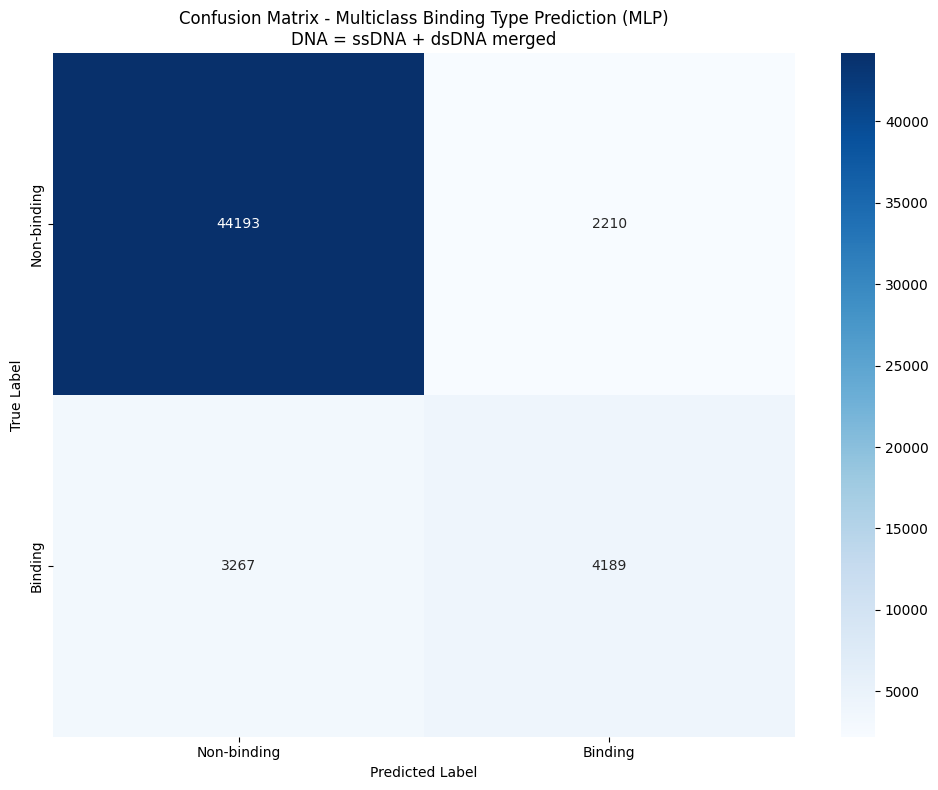

In [14]:
# Classification report
target_names = ['Non-binding', 'Binding']
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - Multiclass Binding Type Prediction (MLP)\nDNA = ssDNA + dsDNA merged')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Model Saving

In [ ]:
# Create save directory if it doesn't exist
save_dir = MAIN_CONFIG['models']['save_dir']
os.makedirs(save_dir, exist_ok=True)

# Model save path
model_name = 'MLP_only_binary'
model_path = os.path.join(save_dir, f'{model_name}.pt')

# Save model with metadata
save_dict = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': 1280,
        'hidden_dims': [256, 64, 32],
        'output_dim': 2,
        'dropout': 0.6,
    },
    'training_info': {
        'best_val_bal_acc': best_val_bal_acc,
        'threshold': THRESHOLD,
        'class_weights': class_weights.cpu().numpy().tolist(),
        'num_epochs_trained': len(train_losses),
    },
    'class_names': ['Non-binding', 'Binding'],
}

torch.save(save_dict, model_path)

print(f"✓ Model saved to: {model_path}")
print(f"  - Best validation balanced accuracy: {best_val_bal_acc:.4f}")
print(f"  - Threshold: {THRESHOLD}")
print(f"  - Epochs trained: {len(train_losses)}")

In [ ]:
# Load saved model
checkpoint = torch.load('final_models/MLP_only_binary.pt', weights_only=False)

# Recreate model with saved config
config = checkpoint['model_config']
model = BindingSiteMLP(
    input_dim=config['input_dim'],
    hidden_dims=config['hidden_dims'],
    output_dim=config['output_dim'],
    dropout=config['dropout']
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded!")
print(f"  - Trained with threshold: {checkpoint['training_info']['threshold']}")
print(f"  - Best val bal-acc: {checkpoint['training_info']['best_val_bal_acc']:.4f}")

## 7.2 GNN (structure only) model training

In [11]:
class BindingSiteGNN(nn.Module):
    """GNN for per-residue binding site prediction using GATv2 attention."""

    def __init__(self, input_dim=5, hidden_dim=128, heads=4, dropout=0.2,
                 num_amino_acids=20, aa_embed_dim=32, output_dim=2):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        # Learnable amino acid embeddings
        self.aa_embedding = nn.Embedding(num_amino_acids, aa_embed_dim)

        # Total input = structural features + AA embedding
        total_input_dim = input_dim + aa_embed_dim

        # GATv2 layers
        self.conv1 = GATv2Conv(
            in_channels=total_input_dim,
            out_channels=hidden_dim,
            heads=heads,
            edge_dim=2,  # area, boundary
            # dropout=dropout,
        )

        self.conv2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=1,
            edge_dim=2,
            # dropout=dropout,
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x                    # [N, 5] structural features
        edge_index = data.edge_index  # [2, E]
        edge_attr = data.edge_attr    # [E, 2]
        residue_type = data.residue_type  # [N] integer indices

        # Get amino acid embeddings and concatenate
        aa_emb = self.aa_embedding(residue_type)  # [N, 32]
        x = torch.cat([x, aa_emb], dim=-1)        # [N, 5 + 32 = 37]

        # GNN layers
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.dropout(x)

        # Output
        logits = self.fc(x)  # [N, 2]
        return logits


# Initialize model - Binary: 2 classes (non-binding, binding)
model_gnn = BindingSiteGNN(
    input_dim=5,           # 5 structural features
    hidden_dim=128,
    heads=4,
    dropout=0.2,
    num_amino_acids=20,
    aa_embed_dim=32,
    output_dim=2           # Binary classification
)
model_gnn = model_gnn.to(device)

print("GNN Model Architecture:")
print(model_gnn)
print(f"\nTotal parameters: {sum(p.numel() for p in model_gnn.parameters()):,}")
print(f"\nInput: 5 structural + 32 AA embedding = 37 total")
print(f"Output: 2 classes (non-binding, binding)")

GNN Model Architecture:
BindingSiteGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (aa_embedding): Embedding(20, 32)
  (conv1): GATv2Conv(37, 128, heads=4)
  (conv2): GATv2Conv(512, 128, heads=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Total parameters: 173,698

Input: 5 structural + 32 AA embedding = 37 total
Output: 2 classes (non-binding, binding)


### Training loop

In [71]:
def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

model_gnn.apply(reset_weights)
all_labels = []
for graph in train_graph_cache.values():
    all_labels.extend(graph.y.detach().cpu().numpy())

torch.cuda.empty_cache()

In [72]:
# ============================================================================
# GNN TRAINING CONFIGURATION
# ============================================================================

from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.data import Batch

# Calculate class weights from training graphs
all_labels = []
for graph in train_graph_cache.values():
    all_labels.extend(graph.y.cpu().numpy())

all_labels = np.array(all_labels)
unique_classes, class_counts = np.unique(all_labels, return_counts=True)
total = len(all_labels)

class_weights_gnn = torch.zeros(2, dtype=torch.float32)
for cls, count in zip(unique_classes, class_counts):
    class_weights_gnn[cls] = total / (len(unique_classes) * count)
class_weights_gnn = class_weights_gnn.to(device)

print(f"GNN Training - Class distribution:")
target_names = ['Non-binding', 'Binding']
for cls, count in zip(unique_classes, class_counts):
    print(f"  {target_names[cls]} ({cls}): {count:,} ({100*count/total:.1f}%)")
print(f"\nClass weights: {class_weights_gnn.cpu().numpy()}")
# ============================================================================
# GNN TRAINING LOOP (Binary Classification)
# ============================================================================

# Training configuration
criterion_gnn = FocalLoss(alpha=class_weights_gnn, gamma=2.0, reduction='mean')
optimizer_gnn = optim.Adam(model_gnn.parameters(), lr=0.002)
num_epochs = 50
THRESHOLD = 0.58  # Classification threshold
batch_size = 64

train_graph_list = list(train_graph_cache.values())
random.shuffle(train_graph_list)

print("Using Focal Loss!")
print(f"  - Alpha (class weights): {class_weights_gnn.cpu().numpy()}")
print(f"  - Gamma (focusing parameter): 2.0\n")

# Early stopping configuration
PATIENCE = 10  # Stop if val balanced accuracy doesn't improve for 10 epochs

# Training history
train_losses_gnn = []
train_balanced_accs_gnn = []
val_losses_gnn = []
val_balanced_accs_gnn = []
val_roc_aucs_gnn = []
val_pr_aucs_gnn = []

# Early stopping variables (based on validation balanced accuracy)
best_val_bal_acc_gnn = 0.0
patience_counter = 0
best_model_state_gnn = None

print("Starting GNN training (Binary classification)...\n")
print(f"Classes: 0=Non-binding, 1=Binding")
print(f"Early stopping: patience={PATIENCE} (monitoring val balanced accuracy)\n")

train_graph_list = list(train_graph_cache.values())
val_graph_list = list(val_graph_cache.values())

for epoch in range(num_epochs):
    # ===== TRAINING =====
    model_gnn.train()
    epoch_loss = 0.0
    epoch_n_nodes = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_graph_list)

    for i in tqdm(range(0, len(train_graph_list), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        batch_graphs = train_graph_list[i:i + batch_size]
        batched_data = Batch.from_data_list(batch_graphs).to(device)

        optimizer_gnn.zero_grad()
        outputs = model_gnn(batched_data)
        loss = criterion_gnn(outputs, batched_data.y)
        loss.backward()
        optimizer_gnn.step()

        # Statistics
        epoch_loss += loss.item() * batched_data.num_nodes
        epoch_n_nodes += batched_data.num_nodes

        probs = F.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= THRESHOLD).long()

        epoch_all_labels.extend(batched_data.y.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    # Train metrics
    train_loss = epoch_loss / epoch_n_nodes
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

    train_losses_gnn.append(train_loss)
    train_balanced_accs_gnn.append(train_bal_acc)

    # ===== VALIDATION =====
    model_gnn.eval()
    val_loss = 0.0
    val_n_nodes = 0
    val_all_labels = []
    val_all_preds = []
    val_all_probs = []

    with torch.no_grad():
        for i in range(0, len(val_graph_list), batch_size):
            batch_graphs = val_graph_list[i:i + batch_size]
            batched_data = Batch.from_data_list(batch_graphs).to(device)

            outputs = model_gnn(batched_data)
            loss = criterion_gnn(outputs, batched_data.y)
            probs = F.softmax(outputs, dim=1)

            val_loss += loss.item() * batched_data.num_nodes
            val_n_nodes += batched_data.num_nodes

            predicted = (probs[:, 1] >= THRESHOLD).long()

            val_all_labels.extend(batched_data.y.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.extend(probs[:, 1].cpu().numpy())

    # Val metrics
    val_loss = val_loss / val_n_nodes
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
    val_roc_auc = roc_auc_score(val_all_labels, val_all_probs)
    val_pr_auc = average_precision_score(val_all_labels, val_all_probs)

    val_losses_gnn.append(val_loss)
    val_balanced_accs_gnn.append(val_bal_acc)
    val_roc_aucs_gnn.append(val_roc_auc)
    val_pr_aucs_gnn.append(val_pr_auc)

    # Early stopping check (on validation balanced accuracy - higher is better)
    if val_bal_acc > best_val_bal_acc_gnn:
        best_val_bal_acc_gnn = val_bal_acc
        patience_counter = 0
        best_model_state_gnn = model_gnn.state_dict().copy()
        improvement_marker = " ✓"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, ROC-AUC: {val_roc_auc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} "
          f"| Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} (best val bal-acc: {best_val_bal_acc_gnn:.4f})")
        break

# Restore best model
if best_model_state_gnn is not None:
    model_gnn.load_state_dict(best_model_state_gnn)
    print(f"\n✓ Restored best model (val bal-acc: {best_val_bal_acc_gnn:.4f})")

print(f"\n{'='*60}")
print(f"GNN Training complete!")
print(f"Best Validation Balanced Accuracy: {best_val_bal_acc_gnn:.4f}")
print(f"{'='*60}")

GNN Training - Class distribution:
  Non-binding (0): 153,372 (85.1%)
  Binding (1): 26,782 (14.9%)

Class weights: [0.5873106 3.363341 ]
Using Focal Loss!
  - Alpha (class weights): [0.5873106 3.363341 ]
  - Gamma (focusing parameter): 2.0

Starting GNN training (Binary classification)...

Classes: 0=Non-binding, 1=Binding
Early stopping: patience=10 (monitoring val balanced accuracy)



Epoch [1/50] - Train Loss: 0.2202, Bal-Acc: 0.5020 | Val Bal-Acc: 0.5067, ROC-AUC: 0.6145, PR-AUC: 0.2238 ✓ | Patience: 0/10


Epoch [2/50] - Train Loss: 0.1725, Bal-Acc: 0.5404 | Val Bal-Acc: 0.5197, ROC-AUC: 0.6331, PR-AUC: 0.2377 ✓ | Patience: 0/10


Epoch [3/50] - Train Loss: 0.1667, Bal-Acc: 0.5391 | Val Bal-Acc: 0.5182, ROC-AUC: 0.6483, PR-AUC: 0.2488 | Patience: 1/10


Epoch [4/50] - Train Loss: 0.1641, Bal-Acc: 0.5416 | Val Bal-Acc: 0.5363, ROC-AUC: 0.6586, PR-AUC: 0.2608 ✓ | Patience: 0/10


Epoch [5/50] - Train Loss: 0.1625, Bal-Acc: 0.5585 | Val Bal-Acc: 0.5517, ROC-AUC: 0.6675, PR-AUC: 0.2683 ✓ | Patience: 0/10


Epoch [6/50] - Train Loss: 0.1614, Bal-Acc: 0.5553 | Val Bal-Acc: 0.5477, ROC-AUC: 0.6704, PR-AUC: 0.2709 | Patience: 1/10


Epoch [7/50] - Train Loss: 0.1604, Bal-Acc: 0.5691 | Val Bal-Acc: 0.5679, ROC-AUC: 0.6773, PR-AUC: 0.2771 ✓ | Patience: 0/10


Epoch [8/50] - Train Loss: 0.1594, Bal-Acc: 0.5738 | Val Bal-Acc: 0.5704, ROC-AUC: 0.6843, PR-AUC: 0.2829 ✓ | Patience: 0/10


Epoch [9/50] - Train Loss: 0.1586, Bal-Acc: 0.5801 | Val Bal-Acc: 0.5704, ROC-AUC: 0.6872, PR-AUC: 0.2855 ✓ | Patience: 0/10


Epoch [10/50] - Train Loss: 0.1580, Bal-Acc: 0.5812 | Val Bal-Acc: 0.5645, ROC-AUC: 0.6911, PR-AUC: 0.2887 | Patience: 1/10


Epoch [11/50] - Train Loss: 0.1579, Bal-Acc: 0.5812 | Val Bal-Acc: 0.5831, ROC-AUC: 0.6935, PR-AUC: 0.2908 ✓ | Patience: 0/10


Epoch [12/50] - Train Loss: 0.1573, Bal-Acc: 0.5990 | Val Bal-Acc: 0.5409, ROC-AUC: 0.6922, PR-AUC: 0.2894 | Patience: 1/10


Epoch [13/50] - Train Loss: 0.1569, Bal-Acc: 0.5814 | Val Bal-Acc: 0.5852, ROC-AUC: 0.6953, PR-AUC: 0.2909 ✓ | Patience: 0/10


Epoch [14/50] - Train Loss: 0.1561, Bal-Acc: 0.5899 | Val Bal-Acc: 0.5774, ROC-AUC: 0.7002, PR-AUC: 0.2959 | Patience: 1/10


Epoch [15/50] - Train Loss: 0.1558, Bal-Acc: 0.5988 | Val Bal-Acc: 0.6070, ROC-AUC: 0.6972, PR-AUC: 0.2924 ✓ | Patience: 0/10


Epoch [16/50] - Train Loss: 0.1565, Bal-Acc: 0.5937 | Val Bal-Acc: 0.5682, ROC-AUC: 0.6977, PR-AUC: 0.2935 | Patience: 1/10


Epoch [17/50] - Train Loss: 0.1564, Bal-Acc: 0.5861 | Val Bal-Acc: 0.6004, ROC-AUC: 0.7017, PR-AUC: 0.2971 | Patience: 2/10


Epoch [18/50] - Train Loss: 0.1559, Bal-Acc: 0.6050 | Val Bal-Acc: 0.5842, ROC-AUC: 0.7013, PR-AUC: 0.2969 | Patience: 3/10


Epoch [19/50] - Train Loss: 0.1550, Bal-Acc: 0.5980 | Val Bal-Acc: 0.5718, ROC-AUC: 0.7021, PR-AUC: 0.2984 | Patience: 4/10


Epoch [20/50] - Train Loss: 0.1545, Bal-Acc: 0.5985 | Val Bal-Acc: 0.6152, ROC-AUC: 0.7042, PR-AUC: 0.3000 ✓ | Patience: 0/10


Epoch [21/50] - Train Loss: 0.1542, Bal-Acc: 0.6069 | Val Bal-Acc: 0.5823, ROC-AUC: 0.7048, PR-AUC: 0.3007 | Patience: 1/10


Epoch [22/50] - Train Loss: 0.1535, Bal-Acc: 0.6097 | Val Bal-Acc: 0.5810, ROC-AUC: 0.7049, PR-AUC: 0.3012 | Patience: 2/10


Epoch [23/50] - Train Loss: 0.1528, Bal-Acc: 0.6083 | Val Bal-Acc: 0.6043, ROC-AUC: 0.7077, PR-AUC: 0.3041 | Patience: 3/10


Epoch [24/50] - Train Loss: 0.1531, Bal-Acc: 0.6136 | Val Bal-Acc: 0.5711, ROC-AUC: 0.7069, PR-AUC: 0.3026 | Patience: 4/10


Epoch [25/50] - Train Loss: 0.1523, Bal-Acc: 0.6155 | Val Bal-Acc: 0.5814, ROC-AUC: 0.7074, PR-AUC: 0.3049 | Patience: 5/10


Epoch [26/50] - Train Loss: 0.1518, Bal-Acc: 0.6168 | Val Bal-Acc: 0.5951, ROC-AUC: 0.7093, PR-AUC: 0.3061 | Patience: 6/10


Epoch [27/50] - Train Loss: 0.1520, Bal-Acc: 0.6153 | Val Bal-Acc: 0.6088, ROC-AUC: 0.7098, PR-AUC: 0.3098 | Patience: 7/10


Epoch [28/50] - Train Loss: 0.1505, Bal-Acc: 0.6219 | Val Bal-Acc: 0.5722, ROC-AUC: 0.7101, PR-AUC: 0.3046 | Patience: 8/10


Epoch [29/50] - Train Loss: 0.1514, Bal-Acc: 0.6190 | Val Bal-Acc: 0.6106, ROC-AUC: 0.7115, PR-AUC: 0.3103 | Patience: 9/10


Epoch [30/50] - Train Loss: 0.1507, Bal-Acc: 0.6199 | Val Bal-Acc: 0.6138, ROC-AUC: 0.7139, PR-AUC: 0.3137 | Patience: 10/10

Early stopping at epoch 30 (best val bal-acc: 0.6152)

✓ Restored best model (val bal-acc: 0.6152)

GNN Training complete!
Best Validation Balanced Accuracy: 0.6152


### GNN evaluation

In [73]:
# ============================================================================
# GNN EVALUATION ON TEST SET
# ============================================================================

model_gnn.eval()
test_all_labels = []
test_all_preds = []
test_all_probs = []

print("Evaluating GNN on test set...\n")

with torch.no_grad():
    for protein_name in tqdm(test_graph_cache.keys(), desc="Evaluating"):
        graph = test_graph_cache[protein_name].to(device)
        labels = graph.y

        outputs = model_gnn(graph)
        probs = F.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= THRESHOLD).long()

        test_all_labels.extend(labels.cpu().numpy())
        test_all_preds.extend(predicted.cpu().numpy())
        test_all_probs.extend(probs[:, 1].cpu().numpy())

# Convert to numpy
y_true_gnn = np.array(test_all_labels)
y_pred_gnn = np.array(test_all_preds)
y_probs_gnn = np.array(test_all_probs)

# Calculate metrics
test_acc_gnn = accuracy_score(y_true_gnn, y_pred_gnn)
test_bal_acc_gnn = balanced_accuracy_score(y_true_gnn, y_pred_gnn)
test_roc_auc_gnn = roc_auc_score(y_true_gnn, y_probs_gnn)
test_pr_auc_gnn = average_precision_score(y_true_gnn, y_probs_gnn)
test_mcc_gnn = matthews_corrcoef(y_true_gnn, y_pred_gnn)

print(f"\n{'='*60}")
print("GNN TEST SET RESULTS")
print(f"{'='*60}")
print(f"Accuracy:          {test_acc_gnn:.4f}")
print(f"Balanced Accuracy: {test_bal_acc_gnn:.4f}")
print(f"ROC-AUC:           {test_roc_auc_gnn:.4f}")
print(f"PR-AUC:            {test_pr_auc_gnn:.4f}")
print(f"MCC:               {test_mcc_gnn:.4f}")
print(f"{'='*60}")

Evaluating GNN on test set...



Evaluating: 100%|██████████| 234/234 [00:00<00:00, 334.25it/s]



GNN TEST SET RESULTS
Accuracy:          0.8008
Balanced Accuracy: 0.6196
ROC-AUC:           0.7132
PR-AUC:            0.2949
MCC:               0.2238


### GNN Detailed evaluation


GNN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Non-binding       0.90      0.87      0.88     46706
     Binding       0.31      0.37      0.34      7518

    accuracy                           0.80     54224
   macro avg       0.60      0.62      0.61     54224
weighted avg       0.81      0.80      0.81     54224



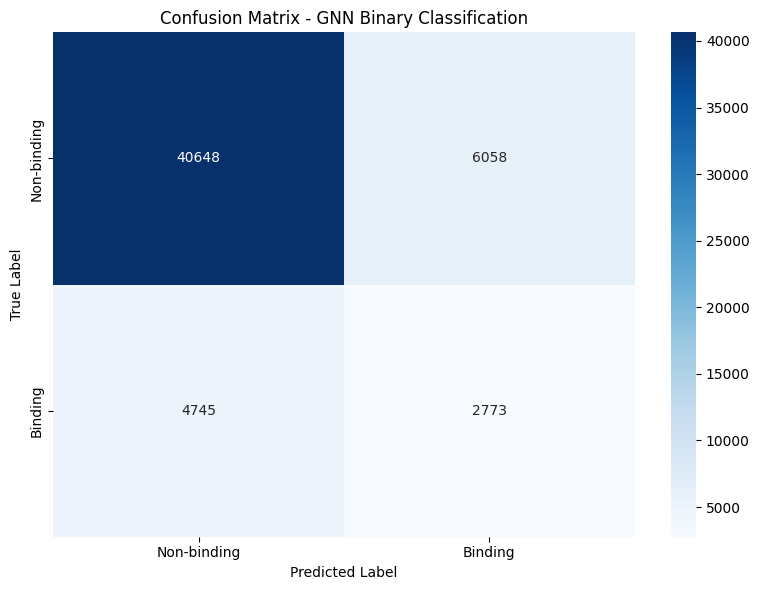

In [74]:
# ============================================================================
# GNN DETAILED EVALUATION
# ============================================================================

# Classification report
target_names = ['Non-binding', 'Binding']
print("\nGNN CLASSIFICATION REPORT:")
print(classification_report(y_true_gnn, y_pred_gnn, target_names=target_names, zero_division=0))

# Confusion matrix
cm_gnn = confusion_matrix(y_true_gnn, y_pred_gnn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - GNN Binary Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Save GNN Model

In [78]:
# ============================================================================
# SAVE GNN MODEL
# ============================================================================

import os

save_dir = MAIN_CONFIG['models']['save_dir']
os.makedirs(save_dir, exist_ok=True)

model_name = 'GNN_structural_only_binary'
model_path = os.path.join(save_dir, f'{model_name}.pt')

save_dict = {
    'model_state_dict': model_gnn.state_dict(),
    'model_config': {
        'input_dim': 5,
        'hidden_dim': 128,
        'heads': 4,
        'dropout': 0.2,
        'num_amino_acids': 20,
        'aa_embed_dim': 32,
        'output_dim': 2,
    },
    'training_info': {
        'best_val_bal_acc': best_val_bal_acc_gnn,
        'test_bal_acc': test_bal_acc_gnn,
        'test_roc_auc': test_roc_auc_gnn,
        'test_pr_auc': test_pr_auc_gnn,
        'threshold': THRESHOLD,
        'num_epochs_trained': len(train_losses_gnn),
    },
    'class_names': ['Non-binding', 'Binding'],
}

torch.save(save_dict, model_path)

print(f"✓ GNN Model saved to: {model_path}")
print(f"  - Best validation balanced accuracy: {best_val_bal_acc_gnn:.4f}")
print(f"  - Test balanced accuracy: {test_bal_acc_gnn:.4f}")
print(f"  - Test ROC-AUC: {test_roc_auc_gnn:.4f}")

✓ GNN Model saved to: final_models/GNN_structural_only_binary.pt
  - Best validation balanced accuracy: 0.6152
  - Test balanced accuracy: 0.6196
  - Test ROC-AUC: 0.7132


## 7.3 GNN + MLP embeddings model training

### Model loading and embeddings extraction

In [12]:
# ============================================================================
# 7.3 GNN + MLP EMBEDDINGS MODEL
# ============================================================================
# This model uses pre-trained MLP embeddings (32-dim) as additional node features

# ============================================================================
# LOAD PRE-TRAINED MLP MODEL
# ============================================================================
MLP_MODEL_PATH = "/content/drive/MyDrive/Magistro_duomenys/final_models/MLP_only_binary.pt"  # <-- Update path if needed

mlp_checkpoint = torch.load(MLP_MODEL_PATH, map_location=device, weights_only=False)
mlp_config = mlp_checkpoint['model_config']

mlp_model_for_embeddings = BindingSiteMLP(
    input_dim=mlp_config['input_dim'],
    hidden_dims=mlp_config['hidden_dims'],
    output_dim=mlp_config['output_dim'],
    dropout=mlp_config['dropout']
)
mlp_model_for_embeddings.load_state_dict(mlp_checkpoint['model_state_dict'])
mlp_model_for_embeddings = mlp_model_for_embeddings.to(device)
mlp_model_for_embeddings.eval()

print(f"MLP model loaded from: {MLP_MODEL_PATH}")
print(f"Config: {mlp_config}")

# ============================================================================
# MLP EMBEDDING EXTRACTION WRAPPER
# ============================================================================
def extract_mlp_embeddings(mlp_model, esm_embeddings, device):
    """
    Extract 32-dim embeddings from the last hidden layer of MLP.

    Args:
        mlp_model: Trained BindingSiteMLP model
        esm_embeddings: ESM2 embeddings tensor [N, 1280]
        device: torch device

    Returns:
        hidden_embeddings: [N, 32] tensor (CPU)
    """
    mlp_model.eval()
    with torch.no_grad():
        x = esm_embeddings.to(device)
        # Pass through all layers except the last Linear layer
        # network structure: Linear, ReLU, Dropout, LayerNorm (repeated), then final Linear
        layers = list(mlp_model.network.children())
        for layer in layers[:-1]:  # All except final Linear
            x = layer(x)
        return x.cpu()

# Test embedding extraction
test_input = torch.randn(10, 1280).to(device)
test_embeddings = extract_mlp_embeddings(mlp_model_for_embeddings, test_input, device)
print(f"\nEmbedding extraction test:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_embeddings.shape}")

MLP model loaded from: /content/drive/MyDrive/Magistro_duomenys/final_models/MLP_only_binary.pt
Config: {'input_dim': 1280, 'hidden_dims': [256, 64, 32], 'output_dim': 2, 'dropout': 0.6}

Embedding extraction test:
  Input shape: torch.Size([10, 1280])
  Output shape: torch.Size([10, 32])


### Embeddings loading

In [13]:
# ============================================================================
# GRAPH CREATION WITH MLP EMBEDDINGS
# ============================================================================

def create_pyg_graph_with_mlp_embeddings(residue_df, edges_df, mlp_embeddings, mode='binary'):
    """
    Create PyG Data object with structural features + MLP embeddings.

    Node features (37 dims): 5 structural + 32 MLP embeddings
    """
    # Structural features (5 dims) - same as structural-only
    structural_features = np.stack([
        normalize_column(residue_df['sas_area'].values),
        normalize_voromqa(residue_df['voromqa_sas_energy'].values),
        normalize_column(residue_df['ev14'].values),
        normalize_column(residue_df['ev28'].values),
        normalize_column(residue_df['ev56'].values),
    ], axis=1).astype(np.float32)

    # Convert MLP embeddings to numpy if tensor
    if torch.is_tensor(mlp_embeddings):
        mlp_embeddings = mlp_embeddings.numpy()

    # Concatenate structural + MLP embeddings
    node_features = np.concatenate([structural_features, mlp_embeddings], axis=1).astype(np.float32)

    # Residue types (for amino acid embedding in model)
    residue_types = torch.tensor(residue_df['residue_type'].values, dtype=torch.long)

    # Edge index and attributes
    if edges_df is not None and len(edges_df) > 0:
        id_to_idx = {id_val: idx for idx, id_val in enumerate(residue_df['ID_resSeq'])}
        src_indices = [id_to_idx[id1] for id1 in edges_df['ID1_resSeq']]
        dst_indices = [id_to_idx[id2] for id2 in edges_df['ID2_resSeq']]
        edge_index = torch.tensor([src_indices, dst_indices], dtype=torch.long)
        edge_attr = torch.tensor(edges_df[['area', 'boundary']].values, dtype=torch.float32)
    else:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 2), dtype=torch.float32)

    # Labels
    y = create_labels(residue_df, mode)

    return Data(
        x=torch.tensor(node_features, dtype=torch.float32),
        residue_type=residue_types,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        num_nodes=len(residue_df)
    )


def load_protein_gnn_with_mlp(protein_name, class_name, base_dir,
                               mlp_model, emb_dir, emb_suffix, device, mode='binary'):
    """
    Load a single protein as PyG graph with MLP embeddings as node features.
    """
    try:
        # 1. Load structural data (reuse existing function)
        residue_df, edges_df, metadata = load_protein_base(protein_name, class_name, base_dir)

        if residue_df is None or len(residue_df) == 0:
            return None

        # 2. Load ESM2 embeddings
        emb_class_dir = f"{class_name}{emb_suffix}"
        embedding_path = os.path.join(emb_dir, emb_class_dir, f"{protein_name}.pt")

        if not os.path.exists(embedding_path):
            return None

        emb_data = torch.load(embedding_path, map_location='cpu', weights_only=False)

        # Extract tensor from ESM-2 format
        if isinstance(emb_data, dict) and 'representations' in emb_data:
            layer_keys = sorted(emb_data['representations'].keys())
            esm_embeddings = emb_data['representations'][layer_keys[-1]]
        else:
            esm_embeddings = emb_data

        # 3. Map residue IDs to embedding indices (same logic as MLP loader)
        id_res_seq_values = residue_df['ID_resSeq'].values
        min_res_seq = id_res_seq_values.min()
        emb_size = esm_embeddings.shape[0]

        if min_res_seq >= 1:
            embedding_indices = id_res_seq_values - 1
        else:
            embedding_indices = id_res_seq_values

        # Validate indices
        valid_mask = (embedding_indices >= 0) & (embedding_indices < emb_size)
        if valid_mask.sum() == 0:
            return None

        if valid_mask.sum() < len(embedding_indices):
            embedding_indices = embedding_indices[valid_mask]
            residue_df = residue_df[valid_mask].reset_index(drop=True)
            if edges_df is not None:
                surface_ids = set(residue_df['ID_resSeq'])
                edge_mask = (edges_df['ID1_resSeq'].isin(surface_ids) &
                            edges_df['ID2_resSeq'].isin(surface_ids))
                edges_df = edges_df[edge_mask].reset_index(drop=True)

        # 4. Get ESM embeddings for surface residues
        filtered_esm_embeddings = esm_embeddings[embedding_indices, :]

        # 5. Extract MLP embeddings (32-dim)
        mlp_embeddings = extract_mlp_embeddings(mlp_model, filtered_esm_embeddings, device)

        # 6. Create graph with combined features
        graph = create_pyg_graph_with_mlp_embeddings(residue_df, edges_df, mlp_embeddings, mode)
        graph.protein_name = protein_name
        graph.class_name = class_name

        return graph

    except Exception as e:
        print(f"Error loading {protein_name}: {e}")
        return None


def load_proteins_gnn_mlp_sequential(protein_list, class_dict, base_dir, mlp_model,
                                      emb_dir, class_configs, device, mode='binary', desc="Loading"):
    """Load proteins as PyG graphs with MLP embeddings, sequentially with progress bar."""
    cache = {}
    failed = []

    for protein_name in tqdm(protein_list, desc=desc):
        class_name = class_dict[protein_name]
        emb_suffix = class_configs[class_name]

        graph = load_protein_gnn_with_mlp(
            protein_name, class_name, base_dir,
            mlp_model, emb_dir, emb_suffix, device, mode
        )

        if graph is not None:
            cache[protein_name] = graph
        else:
            failed.append(protein_name)

    return cache, failed

print("GNN + MLP data loading functions defined!")

GNN + MLP data loading functions defined!


### Pre-compute and Cache Data

In [14]:
# ============================================================================
# LOAD GNN + MLP GRAPH DATA
# ============================================================================

print(f"\n{'='*60}")
print("LOADING GNN + MLP EMBEDDINGS DATA")
print(f"{'='*60}\n")

train_gnn_mlp_cache, train_gnn_mlp_failed = load_proteins_gnn_mlp_sequential(
    train_proteins, class_dict, BASE_DIR, mlp_model_for_embeddings,
    EMB_DIR, CLASS_CONFIGS, device, mode='binary', desc="Train GNN+MLP"
)

val_gnn_mlp_cache, val_gnn_mlp_failed = load_proteins_gnn_mlp_sequential(
    val_proteins, class_dict, BASE_DIR, mlp_model_for_embeddings,
    EMB_DIR, CLASS_CONFIGS, device, mode='binary', desc="Val GNN+MLP"
)

test_gnn_mlp_cache, test_gnn_mlp_failed = load_proteins_gnn_mlp_sequential(
    test_proteins, class_dict, BASE_DIR, mlp_model_for_embeddings,
    EMB_DIR, CLASS_CONFIGS, device, mode='binary', desc="Test GNN+MLP"
)

print(f"\n{'='*60}")
print("GNN + MLP DATA LOADING COMPLETE!")
print(f"{'='*60}")
print(f"Train graphs: {len(train_gnn_mlp_cache)}/{len(train_proteins)}")
print(f"Val graphs:   {len(val_gnn_mlp_cache)}/{len(val_proteins)}")
print(f"Test graphs:  {len(test_gnn_mlp_cache)}/{len(test_proteins)}")

# Verify feature dimensions
sample_graph = list(train_gnn_mlp_cache.values())[0]
print(f"\nSample graph structure:")
print(f"  Node features (x): {sample_graph.x.shape}  (5 structural + 32 MLP = 37)")
print(f"  Residue types: {sample_graph.residue_type.shape}")
print(f"  Edge index: {sample_graph.edge_index.shape}")
print(f"  Edge attributes: {sample_graph.edge_attr.shape}")
print(f"  Labels (y): {sample_graph.y.shape}")


LOADING GNN + MLP EMBEDDINGS DATA



Test GNN+MLP: 100%|██████████| 234/234 [00:14<00:00, 15.74it/s]


GNN + MLP DATA LOADING COMPLETE!
Train graphs: 815/815
Val graphs:   117/117
Test graphs:  234/234

Sample graph structure:
  Node features (x): torch.Size([879, 37])  (5 structural + 32 MLP = 37)
  Residue types: torch.Size([879])
  Edge index: torch.Size([2, 4192])
  Edge attributes: torch.Size([4192, 2])
  Labels (y): torch.Size([879])


### Model Initialization

In [15]:
# ============================================================================
# INITIALIZE GNN + MLP MODEL
# ============================================================================

GNN_MLP_CONFIG = {
    'input_dim': 37,  # 5 structural + 32 MLP embeddings
    'hidden_dim': 256,
    'heads': 4,
    'dropout': 0.5,
    'num_amino_acids': 20,
    'aa_embed_dim': 32,
}

gnn_mlp_model = BindingSiteGNN(
    input_dim=GNN_MLP_CONFIG['input_dim'],
    hidden_dim=GNN_MLP_CONFIG['hidden_dim'],
    heads=GNN_MLP_CONFIG['heads'],
    dropout=GNN_MLP_CONFIG['dropout'],
    num_amino_acids=GNN_MLP_CONFIG['num_amino_acids'],
).to(device)

print("GNN + MLP Model Architecture:")
print(gnn_mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gnn_mlp_model.parameters()):,}")
print(f"\nInput: {GNN_MLP_CONFIG['input_dim']} (structural) + {GNN_MLP_CONFIG['aa_embed_dim']} (AA embed) = {GNN_MLP_CONFIG['input_dim'] + GNN_MLP_CONFIG['aa_embed_dim']} total")

GNN + MLP Model Architecture:
BindingSiteGNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (aa_embedding): Embedding(20, 32)
  (conv1): GATv2Conv(69, 256, heads=4)
  (conv2): GATv2Conv(1024, 256, heads=1)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

Total parameters: 674,434

Input: 37 (structural) + 32 (AA embed) = 69 total


In [143]:
# ============================================================================
# GNN + MLP TRAINING CONFIGURATION (Batched)
# ============================================================================

from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.data import Batch

# Calculate class weights from training graphs
all_labels_gnn_mlp = []
for graph in train_gnn_mlp_cache.values():
    all_labels_gnn_mlp.extend(graph.y.cpu().numpy())

all_labels_gnn_mlp = np.array(all_labels_gnn_mlp)
unique_classes, class_counts = np.unique(all_labels_gnn_mlp, return_counts=True)
total = len(all_labels_gnn_mlp)

class_weights_gnn_mlp = torch.zeros(2, dtype=torch.float32)
for cls, count in zip(unique_classes, class_counts):
    class_weights_gnn_mlp[cls] = total / (len(unique_classes) * count)
class_weights_gnn_mlp = class_weights_gnn_mlp.to(device)

print(f"GNN + MLP Training - Class distribution:")
target_names = ['Non-binding', 'Binding']
for cls, count in zip(unique_classes, class_counts):
    print(f"  {target_names[cls]} ({cls}): {count:,} ({100*count/total:.1f}%)")
print(f"\nClass weights: {class_weights_gnn_mlp.cpu().numpy()}")

GNN + MLP Training - Class distribution:
  Non-binding (0): 152,221 (85.1%)
  Binding (1): 26,719 (14.9%)

Class weights: [0.58776385 3.3485534 ]


### Training loop

In [193]:
def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

model_gnn.apply(reset_weights)
all_labels = []
for graph in train_graph_cache.values():
    all_labels.extend(graph.y.detach().cpu().numpy())

torch.cuda.empty_cache()

In [186]:
# ============================================================================
# GNN + MLP TRAINING LOOP (Batched, Binary Classification)
# ============================================================================

# Training configuration
criterion_gnn_mlp = FocalLoss(alpha=class_weights_gnn_mlp, gamma=2.0, reduction='mean')
optimizer_gnn_mlp = optim.Adam(gnn_mlp_model.parameters(), lr=0.001)
num_epochs = 50
THRESHOLD = 0.66  # Classification threshold
batch_size = 64

print("Using Focal Loss!")
print(f"  - Alpha (class weights): {class_weights_gnn_mlp.cpu().numpy()}")
print(f"  - Gamma (focusing parameter): 2.0\n")

# Early stopping configuration
PATIENCE = 10

# Training history
train_losses_gnn_mlp = []
train_balanced_accs_gnn_mlp = []
val_losses_gnn_mlp = []
val_balanced_accs_gnn_mlp = []
val_roc_aucs_gnn_mlp = []
val_pr_aucs_gnn_mlp = []

# Early stopping variables
best_val_bal_acc_gnn_mlp = 0.0
patience_counter = 0
best_model_state_gnn_mlp = None

print("Starting GNN + MLP training (Binary classification)...\n")
print(f"Input features: 37 (5 structural + 32 MLP embeddings)")
print(f"Classes: 0=Non-binding, 1=Binding")
print(f"Early stopping: patience={PATIENCE} (monitoring val balanced accuracy)\n")

train_graph_list_mlp = list(train_gnn_mlp_cache.values())
val_graph_list_mlp = list(val_gnn_mlp_cache.values())

for epoch in range(num_epochs):
    # ===== TRAINING =====
    gnn_mlp_model.train()
    epoch_loss = 0.0
    epoch_n_nodes = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_graph_list_mlp)

    for i in tqdm(range(0, len(train_graph_list_mlp), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        batch_graphs = train_graph_list_mlp[i:i + batch_size]
        batched_data = Batch.from_data_list(batch_graphs).to(device)

        optimizer_gnn_mlp.zero_grad()
        outputs = gnn_mlp_model(batched_data)
        loss = criterion_gnn_mlp(outputs, batched_data.y)
        loss.backward()
        optimizer_gnn_mlp.step()

        # Statistics
        epoch_loss += loss.item() * batched_data.num_nodes
        epoch_n_nodes += batched_data.num_nodes

        probs = F.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= THRESHOLD).long()

        epoch_all_labels.extend(batched_data.y.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    # Train metrics
    train_loss = epoch_loss / epoch_n_nodes
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

    train_losses_gnn_mlp.append(train_loss)
    train_balanced_accs_gnn_mlp.append(train_bal_acc)

    # ===== VALIDATION =====
    gnn_mlp_model.eval()
    val_loss = 0.0
    val_n_nodes = 0
    val_all_labels = []
    val_all_preds = []
    val_all_probs = []

    with torch.no_grad():
        for i in range(0, len(val_graph_list_mlp), batch_size):
            batch_graphs = val_graph_list_mlp[i:i + batch_size]
            batched_data = Batch.from_data_list(batch_graphs).to(device)

            outputs = gnn_mlp_model(batched_data)
            loss = criterion_gnn_mlp(outputs, batched_data.y)
            probs = F.softmax(outputs, dim=1)

            val_loss += loss.item() * batched_data.num_nodes
            val_n_nodes += batched_data.num_nodes

            predicted = (probs[:, 1] >= THRESHOLD).long()

            val_all_labels.extend(batched_data.y.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.extend(probs[:, 1].cpu().numpy())

    # Val metrics
    val_loss = val_loss / val_n_nodes
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
    val_roc_auc = roc_auc_score(val_all_labels, val_all_probs)
    val_pr_auc = average_precision_score(val_all_labels, val_all_probs)

    val_losses_gnn_mlp.append(val_loss)
    val_balanced_accs_gnn_mlp.append(val_bal_acc)
    val_roc_aucs_gnn_mlp.append(val_roc_auc)
    val_pr_aucs_gnn_mlp.append(val_pr_auc)

    # Early stopping check
    if val_bal_acc > best_val_bal_acc_gnn_mlp:
        best_val_bal_acc_gnn_mlp = val_bal_acc
        patience_counter = 0
        best_model_state_gnn_mlp = gnn_mlp_model.state_dict().copy()
        improvement_marker = " +"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, ROC-AUC: {val_roc_auc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} "
          f"| Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} (best val bal-acc: {best_val_bal_acc_gnn_mlp:.4f})")
        break

# Restore best model
if best_model_state_gnn_mlp is not None:
    gnn_mlp_model.load_state_dict(best_model_state_gnn_mlp)
    print(f"\n* Restored best model (val bal-acc: {best_val_bal_acc_gnn_mlp:.4f})")

print(f"\n{'='*60}")
print(f"GNN + MLP Training complete!")
print(f"Best Validation Balanced Accuracy: {best_val_bal_acc_gnn_mlp:.4f}")
print(f"{'='*60}")

Using Focal Loss!
  - Alpha (class weights): [0.58776385 3.3485534 ]
  - Gamma (focusing parameter): 2.0

Starting GNN + MLP training (Binary classification)...

Input features: 37 (5 structural + 32 MLP embeddings)
Classes: 0=Non-binding, 1=Binding
Early stopping: patience=10 (monitoring val balanced accuracy)



Epoch [1/50] - Train Loss: 0.0627, Bal-Acc: 0.8572 | Val Bal-Acc: 0.7271, ROC-AUC: 0.8992, PR-AUC: 0.6741 + | Patience: 0/10


Epoch [2/50] - Train Loss: 0.0608, Bal-Acc: 0.8501 | Val Bal-Acc: 0.7699, ROC-AUC: 0.8987, PR-AUC: 0.6756 + | Patience: 0/10


Epoch [3/50] - Train Loss: 0.0588, Bal-Acc: 0.8506 | Val Bal-Acc: 0.7634, ROC-AUC: 0.8991, PR-AUC: 0.6770 | Patience: 1/10


Epoch [4/50] - Train Loss: 0.0587, Bal-Acc: 0.8497 | Val Bal-Acc: 0.7457, ROC-AUC: 0.8994, PR-AUC: 0.6805 | Patience: 2/10


Epoch [5/50] - Train Loss: 0.0581, Bal-Acc: 0.8517 | Val Bal-Acc: 0.7740, ROC-AUC: 0.8999, PR-AUC: 0.6817 + | Patience: 0/10


Epoch [6/50] - Train Loss: 0.0578, Bal-Acc: 0.8556 | Val Bal-Acc: 0.7642, ROC-AUC: 0.8991, PR-AUC: 0.6818 | Patience: 1/10


Epoch [7/50] - Train Loss: 0.0575, Bal-Acc: 0.8543 | Val Bal-Acc: 0.7682, ROC-AUC: 0.8997, PR-AUC: 0.6835 | Patience: 2/10


Epoch [8/50] - Train Loss: 0.0573, Bal-Acc: 0.8547 | Val Bal-Acc: 0.7501, ROC-AUC: 0.8993, PR-AUC: 0.6832 | Patience: 3/10


Epoch [9/50] - Train Loss: 0.0576, Bal-Acc: 0.8545 | Val Bal-Acc: 0.7659, ROC-AUC: 0.8987, PR-AUC: 0.6841 | Patience: 4/10


Epoch [10/50] - Train Loss: 0.0573, Bal-Acc: 0.8547 | Val Bal-Acc: 0.7645, ROC-AUC: 0.8998, PR-AUC: 0.6855 | Patience: 5/10


Epoch [11/50] - Train Loss: 0.0570, Bal-Acc: 0.8495 | Val Bal-Acc: 0.7714, ROC-AUC: 0.8978, PR-AUC: 0.6844 | Patience: 6/10


Epoch [12/50] - Train Loss: 0.0567, Bal-Acc: 0.8575 | Val Bal-Acc: 0.7678, ROC-AUC: 0.9000, PR-AUC: 0.6860 | Patience: 7/10


Epoch [13/50] - Train Loss: 0.0562, Bal-Acc: 0.8554 | Val Bal-Acc: 0.7803, ROC-AUC: 0.8980, PR-AUC: 0.6840 + | Patience: 0/10


Epoch [14/50] - Train Loss: 0.0562, Bal-Acc: 0.8577 | Val Bal-Acc: 0.7706, ROC-AUC: 0.8981, PR-AUC: 0.6837 | Patience: 1/10


Epoch [15/50] - Train Loss: 0.0557, Bal-Acc: 0.8604 | Val Bal-Acc: 0.7603, ROC-AUC: 0.8981, PR-AUC: 0.6842 | Patience: 2/10


Epoch [16/50] - Train Loss: 0.0556, Bal-Acc: 0.8562 | Val Bal-Acc: 0.7642, ROC-AUC: 0.8958, PR-AUC: 0.6839 | Patience: 3/10


Epoch [17/50] - Train Loss: 0.0554, Bal-Acc: 0.8605 | Val Bal-Acc: 0.7514, ROC-AUC: 0.8982, PR-AUC: 0.6864 | Patience: 4/10


Epoch [18/50] - Train Loss: 0.0561, Bal-Acc: 0.8559 | Val Bal-Acc: 0.7775, ROC-AUC: 0.8973, PR-AUC: 0.6849 | Patience: 5/10


Epoch [19/50] - Train Loss: 0.0551, Bal-Acc: 0.8573 | Val Bal-Acc: 0.7674, ROC-AUC: 0.8977, PR-AUC: 0.6849 | Patience: 6/10


Epoch [20/50] - Train Loss: 0.0549, Bal-Acc: 0.8606 | Val Bal-Acc: 0.7692, ROC-AUC: 0.8970, PR-AUC: 0.6850 | Patience: 7/10


Epoch [21/50] - Train Loss: 0.0545, Bal-Acc: 0.8579 | Val Bal-Acc: 0.7841, ROC-AUC: 0.8973, PR-AUC: 0.6849 + | Patience: 0/10


Epoch [22/50] - Train Loss: 0.0554, Bal-Acc: 0.8638 | Val Bal-Acc: 0.7758, ROC-AUC: 0.8989, PR-AUC: 0.6817 | Patience: 1/10


Epoch [23/50] - Train Loss: 0.0554, Bal-Acc: 0.8581 | Val Bal-Acc: 0.7621, ROC-AUC: 0.8958, PR-AUC: 0.6838 | Patience: 2/10


Epoch [24/50] - Train Loss: 0.0541, Bal-Acc: 0.8619 | Val Bal-Acc: 0.7658, ROC-AUC: 0.8978, PR-AUC: 0.6834 | Patience: 3/10


Epoch [25/50] - Train Loss: 0.0539, Bal-Acc: 0.8599 | Val Bal-Acc: 0.7693, ROC-AUC: 0.8949, PR-AUC: 0.6825 | Patience: 4/10


Epoch [26/50] - Train Loss: 0.0541, Bal-Acc: 0.8626 | Val Bal-Acc: 0.7860, ROC-AUC: 0.8962, PR-AUC: 0.6844 + | Patience: 0/10


Epoch [27/50] - Train Loss: 0.0536, Bal-Acc: 0.8625 | Val Bal-Acc: 0.7697, ROC-AUC: 0.8970, PR-AUC: 0.6827 | Patience: 1/10


Epoch [28/50] - Train Loss: 0.0540, Bal-Acc: 0.8597 | Val Bal-Acc: 0.7853, ROC-AUC: 0.8958, PR-AUC: 0.6835 | Patience: 2/10


Epoch [29/50] - Train Loss: 0.0530, Bal-Acc: 0.8644 | Val Bal-Acc: 0.7761, ROC-AUC: 0.8925, PR-AUC: 0.6808 | Patience: 3/10


Epoch [30/50] - Train Loss: 0.0526, Bal-Acc: 0.8642 | Val Bal-Acc: 0.7635, ROC-AUC: 0.8935, PR-AUC: 0.6818 | Patience: 4/10


Epoch [31/50] - Train Loss: 0.0526, Bal-Acc: 0.8632 | Val Bal-Acc: 0.7720, ROC-AUC: 0.8933, PR-AUC: 0.6816 | Patience: 5/10


Epoch [32/50] - Train Loss: 0.0527, Bal-Acc: 0.8640 | Val Bal-Acc: 0.7809, ROC-AUC: 0.8949, PR-AUC: 0.6848 | Patience: 6/10


Epoch [33/50] - Train Loss: 0.0529, Bal-Acc: 0.8613 | Val Bal-Acc: 0.7928, ROC-AUC: 0.8933, PR-AUC: 0.6837 + | Patience: 0/10


Epoch [34/50] - Train Loss: 0.0535, Bal-Acc: 0.8683 | Val Bal-Acc: 0.7309, ROC-AUC: 0.8914, PR-AUC: 0.6797 | Patience: 1/10


Epoch [35/50] - Train Loss: 0.0539, Bal-Acc: 0.8515 | Val Bal-Acc: 0.7665, ROC-AUC: 0.8935, PR-AUC: 0.6832 | Patience: 2/10


Epoch [36/50] - Train Loss: 0.0521, Bal-Acc: 0.8655 | Val Bal-Acc: 0.7773, ROC-AUC: 0.8926, PR-AUC: 0.6810 | Patience: 3/10


Epoch [37/50] - Train Loss: 0.0517, Bal-Acc: 0.8640 | Val Bal-Acc: 0.7834, ROC-AUC: 0.8934, PR-AUC: 0.6825 | Patience: 4/10


Epoch [38/50] - Train Loss: 0.0516, Bal-Acc: 0.8679 | Val Bal-Acc: 0.7866, ROC-AUC: 0.8945, PR-AUC: 0.6823 | Patience: 5/10


Epoch [39/50] - Train Loss: 0.0519, Bal-Acc: 0.8620 | Val Bal-Acc: 0.7709, ROC-AUC: 0.8927, PR-AUC: 0.6828 | Patience: 6/10


Epoch [40/50] - Train Loss: 0.0512, Bal-Acc: 0.8673 | Val Bal-Acc: 0.7784, ROC-AUC: 0.8912, PR-AUC: 0.6811 | Patience: 7/10


Epoch [41/50] - Train Loss: 0.0505, Bal-Acc: 0.8680 | Val Bal-Acc: 0.7683, ROC-AUC: 0.8931, PR-AUC: 0.6803 | Patience: 8/10


Epoch [42/50] - Train Loss: 0.0511, Bal-Acc: 0.8660 | Val Bal-Acc: 0.7876, ROC-AUC: 0.8944, PR-AUC: 0.6824 | Patience: 9/10


Epoch [43/50] - Train Loss: 0.0513, Bal-Acc: 0.8669 | Val Bal-Acc: 0.7790, ROC-AUC: 0.8926, PR-AUC: 0.6842 | Patience: 10/10

Early stopping at epoch 43 (best val bal-acc: 0.7928)

* Restored best model (val bal-acc: 0.7928)

GNN + MLP Training complete!
Best Validation Balanced Accuracy: 0.7928


### Evaluation

Evaluating GNN + MLP model on test set...

Using threshold: 0.66


GNN + MLP TEST RESULTS
Accuracy: 0.8996
Balanced Accuracy: 0.7772
MCC: 0.5687
ROC AUC: 0.8992
PR AUC: 0.6581

              precision    recall  f1-score   support

 Non-binding       0.94      0.95      0.94     46403
     Binding       0.65      0.61      0.63      7456

    accuracy                           0.90     53859
   macro avg       0.79      0.78      0.78     53859
weighted avg       0.90      0.90      0.90     53859



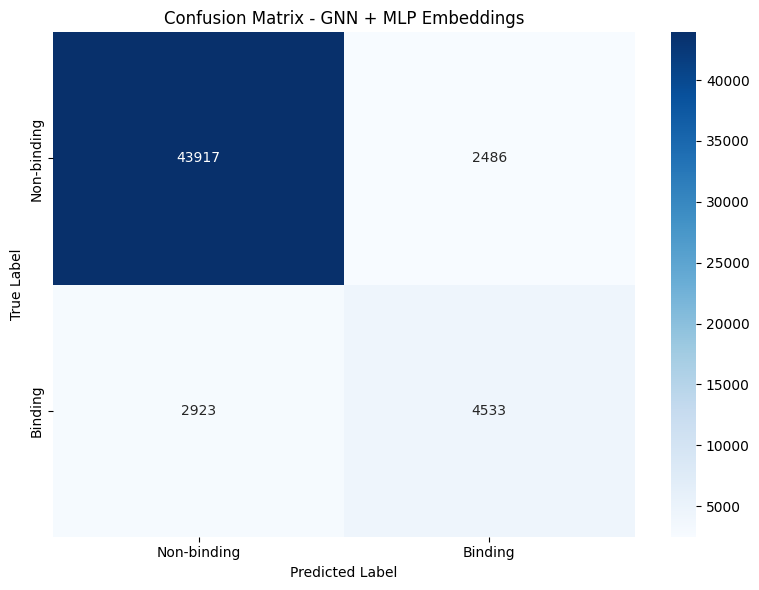

In [187]:
# ============================================================================
# EVALUATION ON TEST SET
# ============================================================================

THRESHOLD = 0.66  # Same threshold as training

gnn_mlp_model.eval()
all_predictions = []
all_labels = []
all_probs = []

print("Evaluating GNN + MLP model on test set...\n")
print(f"Using threshold: {THRESHOLD}\n")

test_graph_list_mlp = list(test_gnn_mlp_cache.values())

with torch.no_grad():
    for i in range(0, len(test_graph_list_mlp), batch_size):
        batch_graphs = test_graph_list_mlp[i:i + batch_size]
        batched_data = Batch.from_data_list(batch_graphs).to(device)

        outputs = gnn_mlp_model(batched_data)
        probs = F.softmax(outputs, dim=1)
        probs_positive = probs[:, 1]
        preds = (probs_positive >= THRESHOLD).long()

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batched_data.y.cpu().numpy())
        all_probs.extend(probs_positive.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_predictions)
y_probs = np.array(all_probs)

# Metrics
test_acc = accuracy_score(y_true, y_pred)
test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_mcc = matthews_corrcoef(y_true, y_pred)
test_roc_auc = roc_auc_score(y_true, y_probs)
test_pr_auc = average_precision_score(y_true, y_probs)

print(f"\n{'='*60}")
print("GNN + MLP TEST RESULTS")
print(f"{'='*60}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Balanced Accuracy: {test_bal_acc:.4f}")
print(f"MCC: {test_mcc:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"PR AUC: {test_pr_auc:.4f}")

# Classification report
target_names = ['Non-binding', 'Binding']
print(f"\n{classification_report(y_true, y_pred, target_names=target_names, zero_division=0)}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - GNN + MLP Embeddings')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Save Model

In [188]:
# ============================================================================
# SAVE MODEL
# ============================================================================

GNN_MLP_SAVE_PATH = "final_models/GNN_MLP_embeddings_binary.pt"

os.makedirs(os.path.dirname(GNN_MLP_SAVE_PATH), exist_ok=True)

torch.save({
    'model_state_dict': gnn_mlp_model.state_dict(),
    'model_config': GNN_MLP_CONFIG,
    'training_info': {
        'best_val_bal_acc': best_val_bal_acc,
        'num_epochs_trained': epoch + 1,
        'test_bal_acc': test_bal_acc,
        'test_mcc': test_mcc,
    },
    'class_names': ['Non-binding', 'Binding'],
    'mlp_model_path': MLP_MODEL_PATH,  # Reference to source MLP model
}, GNN_MLP_SAVE_PATH)

print(f"Model saved to: {GNN_MLP_SAVE_PATH}")

Model saved to: final_models/GNN_MLP_embeddings_binary.pt


## 7.4 GNN + MLP Joint  model training

### Joint Model

In [16]:
# ============================================================================
# 7.4 JOINT MLP + GNN MODEL WITH AUXILIARY LOSS
# ============================================================================
# Train MLP and GNN simultaneously. MLP provides embeddings to GNN.
# Final output is GNN only. MLP has auxiliary loss for better gradient flow.

class JointMLPGNN(nn.Module):
    """
    Joint model that trains MLP and GNN end-to-end.
    MLP provides embeddings to GNN and has auxiliary loss.
    Final predictions come from GNN only.
    """

    def __init__(self, mlp_config, gnn_config, mlp_loss_weight=0.2):
        super().__init__()
        self.mlp_loss_weight = mlp_loss_weight
        self.mlp_embedding_dim = mlp_config['hidden_dims'][-1]  # Last hidden layer dim (32)

        # MLP component (sequence branch)
        # Build MLP layers manually to access intermediate embeddings
        self.mlp_layers = nn.ModuleList()
        prev_dim = mlp_config['input_dim']

        for hidden_dim in mlp_config['hidden_dims']:
            self.mlp_layers.append(nn.Linear(prev_dim, hidden_dim))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(mlp_config['dropout']))
            self.mlp_layers.append(nn.LayerNorm(hidden_dim))
            prev_dim = hidden_dim

        # MLP output head (for auxiliary loss)
        self.mlp_head = nn.Linear(prev_dim, mlp_config['output_dim'])

        # GNN component (structure branch)
        # Input: 5 structural + mlp_embedding_dim
        self.gnn = BindingSiteGNN(
            input_dim=gnn_config['input_dim'],  # 5 + 32 = 37
            hidden_dim=gnn_config['hidden_dim'],
            heads=gnn_config['heads'],
            dropout=gnn_config['dropout'],
        )

    def mlp_forward(self, x):
        """
        Forward pass through MLP layers.
        Returns both logits and embeddings from last hidden layer.
        """
        # Pass through all hidden layers
        for layer in self.mlp_layers:
            x = layer(x)

        embeddings = x  # This is the 32-dim embedding
        logits = self.mlp_head(embeddings)

        return logits, embeddings

    def forward(self, esm_embeddings, graph_data):
        """
        Joint forward pass.

        Args:
            esm_embeddings: [N, 1280] ESM2 embeddings for residues
            graph_data: PyG Data object with 5-dim structural features

        Returns:
            gnn_logits: [N, 2] GNN predictions (main output)
            mlp_logits: [N, 2] MLP predictions (auxiliary)
        """
        # 1. MLP forward - get embeddings and auxiliary logits
        mlp_logits, mlp_embeddings = self.mlp_forward(esm_embeddings)

        # 2. Concatenate MLP embeddings with structural features
        # graph_data.x is [N, 5], mlp_embeddings is [N, 32]
        combined_features = torch.cat([graph_data.x, mlp_embeddings], dim=-1)

        # 3. Create new graph with combined features
        graph_data.x = combined_features

        # 4. GNN forward
        gnn_logits = self.gnn(graph_data)

        return gnn_logits, mlp_logits

    def compute_loss(self, gnn_logits, mlp_logits, labels, criterion):
        """
        Compute combined loss with configurable MLP weight.

        Total Loss = GNN_loss + mlp_loss_weight * MLP_loss
        """
        gnn_loss = criterion(gnn_logits, labels)

        if self.mlp_loss_weight > 0:
            mlp_loss = criterion(mlp_logits, labels)
            total_loss = gnn_loss + self.mlp_loss_weight * mlp_loss
        else:
            mlp_loss = torch.tensor(0.0)
            total_loss = gnn_loss

        return total_loss, gnn_loss, mlp_loss


print("JointMLPGNN model class defined!")
print(f"Architecture: ESM2 -> MLP -> embeddings -> concat with structural -> GNN")
print(f"Loss: GNN_loss + mlp_weight * MLP_loss")

JointMLPGNN model class defined!
Architecture: ESM2 -> MLP -> embeddings -> concat with structural -> GNN
Loss: GNN_loss + mlp_weight * MLP_loss


### Configuration and Model Initialization

In [226]:
# ============================================================================
# JOINT MODEL CONFIGURATION
# ============================================================================

JOINT_CONFIG = {
    'mlp': {
        'input_dim': 1280,
        'hidden_dims': [256, 64, 32],
        'output_dim': 2,
        'dropout': 0.5
    },
    'gnn': {
        'input_dim': 37,  # 5 structural + 32 MLP embeddings
        'hidden_dim': 256,
        'heads': 4,
        'dropout': 0.2,
        'num_amino_acids': 20,
        'aa_embed_dim': 32
    },
    'mlp_loss_weight': 0.0,
    'init_from_pretrained': False  # Set True to load pre-trained MLP weights
}

# Optional: Path to pre-trained MLP model
MLP_PRETRAINED_PATH = "final_models/MLP_only_binary.pt"

# ============================================================================
# INITIALIZE MODEL
# ============================================================================

joint_model = JointMLPGNN(
    mlp_config=JOINT_CONFIG['mlp'],
    gnn_config=JOINT_CONFIG['gnn'],
    mlp_loss_weight=JOINT_CONFIG['mlp_loss_weight']
).to(device)

# Optionally load pre-trained MLP weights
if JOINT_CONFIG['init_from_pretrained']:
    print(f"Loading pre-trained MLP weights from: {MLP_PRETRAINED_PATH}")
    mlp_checkpoint = torch.load(MLP_PRETRAINED_PATH, map_location=device, weights_only=False)

    # Map pre-trained weights to joint model's MLP layers
    pretrained_state = mlp_checkpoint['model_state_dict']

    # The pre-trained model has 'network.0.weight', 'network.0.bias', etc.
    # Our joint model has 'mlp_layers.0.weight', etc.
    layer_mapping = {}
    for key in pretrained_state.keys():
        if key.startswith('network.'):
            # network.X -> mlp_layers.X (except last layer which is mlp_head)
            parts = key.split('.')
            layer_idx = int(parts[1])

            # Last linear layer (index 12 for [256,64,32]) maps to mlp_head
            # hidden_dims has 3 layers, each has 4 components (Linear, ReLU, Dropout, LayerNorm)
            # So indices 0-11 are hidden layers, index 12 is output
            if layer_idx == len(JOINT_CONFIG['mlp']['hidden_dims']) * 4:
                new_key = f"mlp_head.{parts[2]}"
            else:
                new_key = f"mlp_layers.{layer_idx}.{parts[2]}"
            layer_mapping[new_key] = pretrained_state[key]

    # Load mapped weights
    joint_model.load_state_dict(layer_mapping, strict=False)
    print("Pre-trained MLP weights loaded!")
else:
    print("Initializing model from scratch (random weights)")

print(f"\nModel Configuration:")
print(f"  MLP loss weight: {JOINT_CONFIG['mlp_loss_weight']}")
print(f"  MLP: 1280 -> {JOINT_CONFIG['mlp']['hidden_dims']} -> 2")
print(f"  GNN input: {JOINT_CONFIG['gnn']['input_dim']} (5 structural + 32 MLP)")
print(f"\nTotal parameters: {sum(p.numel() for p in joint_model.parameters()):,}")

Initializing model from scratch (random weights)

Model Configuration:
  MLP loss weight: 0.0
  MLP: 1280 -> [256, 64, 32] -> 2
  GNN input: 37 (5 structural + 32 MLP)

Total parameters: 1,021,668


### Training Configuration

In [232]:
# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

from sklearn.metrics import roc_auc_score, average_precision_score

# Calculate class weights from training data
all_labels_joint = []
for protein_name in train_data_cache.keys():
    if protein_name in train_graph_cache:
        all_labels_joint.extend(train_graph_cache[protein_name].y.cpu().numpy())

all_labels_joint = np.array(all_labels_joint)
unique_classes, class_counts = np.unique(all_labels_joint, return_counts=True)
total = len(all_labels_joint)

class_weights_joint = torch.zeros(2, dtype=torch.float32)
for cls, count in zip(unique_classes, class_counts):
    class_weights_joint[cls] = total / (len(unique_classes) * count)
class_weights_joint = class_weights_joint.to(device)

print(f"Joint Model Training - Class distribution:")
target_names = ['Non-binding', 'Binding']
for cls, count in zip(unique_classes, class_counts):
    print(f"  {target_names[cls]} ({cls}): {count:,} ({100*count/total:.1f}%)")
print(f"\nClass weights: {class_weights_joint.cpu().numpy()}")

# Training setup
criterion_joint = FocalLoss(alpha=class_weights_joint, gamma=2.0, reduction='mean')
optimizer_joint = optim.Adam(joint_model.parameters(), lr=0.002)
num_epochs = 50
THRESHOLD = 0.66
PATIENCE = 10

print(f"\nUsing Focal Loss with mlp_loss_weight={JOINT_CONFIG['mlp_loss_weight']}")

Joint Model Training - Class distribution:
  Non-binding (0): 153,372 (85.1%)
  Binding (1): 26,782 (14.9%)

Class weights: [0.5873106 3.363341 ]

Using Focal Loss with mlp_loss_weight=0.0


### Quick check

In [203]:
# ============================================================================
# VERIFY DATA ALIGNMENT BETWEEN CACHES
# ============================================================================

def get_aligned_proteins(data_cache, graph_cache):
    """Get list of proteins where ESM embeddings and graph have same node count."""
    aligned = []
    mismatched = []

    for protein_name in data_cache.keys():
        if protein_name not in graph_cache:
            continue

        n_esm = data_cache[protein_name]['embeddings'].shape[0]
        n_graph = graph_cache[protein_name].x.shape[0]

        if n_esm == n_graph:
            aligned.append(protein_name)
        else:
            mismatched.append((protein_name, n_esm, n_graph))

    return aligned, mismatched

train_proteins_joint, train_mismatched = get_aligned_proteins(train_data_cache, train_graph_cache)
val_proteins_joint, val_mismatched = get_aligned_proteins(val_data_cache, val_graph_cache)
test_proteins_joint, test_mismatched = get_aligned_proteins(test_data_cache, test_graph_cache)

print(f"Aligned proteins:")
print(f"  Train: {len(train_proteins_joint)} (mismatched: {len(train_mismatched)})")
print(f"  Val: {len(val_proteins_joint)} (mismatched: {len(val_mismatched)})")
print(f"  Test: {len(test_proteins_joint)} (mismatched: {len(test_mismatched)})")

if len(train_mismatched) > 0:
    print(f"\nSample mismatches (protein, n_esm, n_graph):")
    for p, n_esm, n_graph in train_mismatched[:5]:
        print(f"  {p}: ESM={n_esm}, Graph={n_graph}")

Aligned proteins:
  Train: 807 (mismatched: 8)
  Val: 116 (mismatched: 1)
  Test: 230 (mismatched: 4)

Sample mismatches (protein, n_esm, n_graph):
  6dtd_A: ESM=879, Graph=974
  8hkc_C: ESM=845, Graph=1145
  7xib_A: ESM=537, Graph=762
  5id6_A: ESM=956, Graph=1139
  5aor_A: ESM=800, Graph=924


### Training loop

In [227]:
def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

model_gnn.apply(reset_weights)
all_labels = []
for graph in train_graph_cache.values():
    all_labels.extend(graph.y.detach().cpu().numpy())

torch.cuda.empty_cache()

In [233]:
# ============================================================================
# JOINT MODEL TRAINING LOOP
# ============================================================================
# Training history
train_losses_joint = []
train_gnn_losses = []
train_mlp_losses = []
train_balanced_accs_joint = []
val_balanced_accs_joint = []
val_roc_aucs_joint = []
val_pr_aucs_joint = []

# Early stopping
best_val_pr_auc_joint = 0.0
patience_counter = 0
best_model_state_joint = None

# Get common proteins (present in both caches)
train_proteins_joint = [p for p in train_data_cache.keys() if p in train_graph_cache]
val_proteins_joint = [p for p in val_data_cache.keys() if p in val_graph_cache]

print(f"Starting Joint MLP+GNN training...")
print(f"  Training proteins: {len(train_proteins_joint)}")
print(f"  Validation proteins: {len(val_proteins_joint)}")
print(f"  MLP loss weight: {JOINT_CONFIG['mlp_loss_weight']}")
print(f"  Early stopping: patience={PATIENCE} (monitoring val PR AUC)\n")

for epoch in range(num_epochs):
    # ===== TRAINING =====
    joint_model.train()
    epoch_total_loss = 0.0
    epoch_gnn_loss = 0.0
    epoch_mlp_loss = 0.0
    epoch_n_nodes = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_proteins_joint)

    for protein_name in tqdm(train_proteins_joint, desc=f"Epoch {epoch+1}", leave=False):
        # Get data from both caches
        esm_data = train_data_cache[protein_name]
        graph = train_graph_cache[protein_name].clone().to(device)

        esm_embeddings = esm_data['embeddings'].to(device)
        labels = graph.y

        # Check if sizes match
        if esm_embeddings.shape[0] != graph.x.shape[0]:
            # Skip mismatched proteins
            continue

        optimizer_joint.zero_grad()

        # Forward pass
        gnn_logits, mlp_logits = joint_model(esm_embeddings, graph)

        # Compute combined loss
        total_loss, gnn_loss, mlp_loss = joint_model.compute_loss(
            gnn_logits, mlp_logits, labels, criterion_joint
        )

        # Backward pass
        total_loss.backward()
        optimizer_joint.step()

        # Statistics
        epoch_total_loss += total_loss.item() * len(labels)
        epoch_gnn_loss += gnn_loss.item() * len(labels)
        if JOINT_CONFIG['mlp_loss_weight'] > 0:
            epoch_mlp_loss += mlp_loss.item() * len(labels)
        epoch_n_nodes += len(labels)

        # Predictions (from GNN output)
        probs = F.softmax(gnn_logits, dim=1)
        predicted = (probs[:, 1] >= THRESHOLD).long()

        epoch_all_labels.extend(labels.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    # Train metrics
    avg_total_loss = epoch_total_loss / epoch_n_nodes
    avg_gnn_loss = epoch_gnn_loss / epoch_n_nodes
    avg_mlp_loss = epoch_mlp_loss / epoch_n_nodes if JOINT_CONFIG['mlp_loss_weight'] > 0 else 0
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

    train_losses_joint.append(avg_total_loss)
    train_gnn_losses.append(avg_gnn_loss)
    train_mlp_losses.append(avg_mlp_loss)
    train_balanced_accs_joint.append(train_bal_acc)

    # ===== VALIDATION =====
    joint_model.eval()
    val_all_labels = []
    val_all_preds = []
    val_all_probs = []

    with torch.no_grad():
        for protein_name in val_proteins_joint:
            esm_data = val_data_cache[protein_name]
            graph = val_graph_cache[protein_name].clone().to(device)

            esm_embeddings = esm_data['embeddings'].to(device)
            labels = graph.y

            # Check if sizes match
            if esm_embeddings.shape[0] != graph.x.shape[0]:
            # Skip mismatched proteins
              continue

            gnn_logits, _ = joint_model(esm_embeddings, graph)

            probs = F.softmax(gnn_logits, dim=1)
            predicted = (probs[:, 1] >= THRESHOLD).long()

            val_all_labels.extend(labels.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.extend(probs[:, 1].cpu().numpy())

    # Val metrics
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
    val_roc_auc = roc_auc_score(val_all_labels, val_all_probs)
    val_pr_auc = average_precision_score(val_all_labels, val_all_probs)

    val_balanced_accs_joint.append(val_bal_acc)
    val_roc_aucs_joint.append(val_roc_auc)
    val_pr_aucs_joint.append(val_pr_auc)

    # Early stopping check (based on PR AUC)
    if val_pr_auc > best_val_pr_auc_joint:
        best_val_pr_auc_joint = val_pr_auc
        patience_counter = 0
        best_model_state_joint = joint_model.state_dict().copy()
        improvement_marker = " +"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {avg_total_loss:.4f} (GNN: {avg_gnn_loss:.4f}, MLP: {avg_mlp_loss:.4f}) | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} "
          f"| Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1} (best val PR-AUC: {best_val_pr_auc_joint:.4f})")
        break

# Restore best model
if best_model_state_joint is not None:
    joint_model.load_state_dict(best_model_state_joint)
    print(f"\n* Restored best model (val PR-AUC: {best_val_pr_auc_joint:.4f})")

print(f"\n{'='*60}")
print(f"Joint MLP+GNN Training complete!")
print(f"Best Validation PR AUC: {best_val_pr_auc_joint:.4f}")
print(f"{'='*60}")

Starting Joint MLP+GNN training...
  Training proteins: 815
  Validation proteins: 117
  MLP loss weight: 0.0
  Early stopping: patience=10 (monitoring val PR AUC)



Epoch [1/50] - Loss: 0.0949 (GNN: 0.0949, MLP: 0.0000) | Val Bal-Acc: 0.7036, PR-AUC: 0.6644 + | Patience: 0/10


Epoch [2/50] - Loss: 0.0925 (GNN: 0.0925, MLP: 0.0000) | Val Bal-Acc: 0.7383, PR-AUC: 0.6783 + | Patience: 0/10


Epoch [3/50] - Loss: 0.0895 (GNN: 0.0895, MLP: 0.0000) | Val Bal-Acc: 0.6598, PR-AUC: 0.6705 | Patience: 1/10


Epoch [4/50] - Loss: 0.0939 (GNN: 0.0939, MLP: 0.0000) | Val Bal-Acc: 0.7939, PR-AUC: 0.6717 | Patience: 2/10


Epoch [5/50] - Loss: 0.0873 (GNN: 0.0873, MLP: 0.0000) | Val Bal-Acc: 0.7612, PR-AUC: 0.6860 + | Patience: 0/10


Epoch [6/50] - Loss: 0.0843 (GNN: 0.0843, MLP: 0.0000) | Val Bal-Acc: 0.7725, PR-AUC: 0.6692 | Patience: 1/10


Epoch [7/50] - Loss: 0.0853 (GNN: 0.0853, MLP: 0.0000) | Val Bal-Acc: 0.6317, PR-AUC: 0.6714 | Patience: 2/10


Epoch [8/50] - Loss: 0.0903 (GNN: 0.0903, MLP: 0.0000) | Val Bal-Acc: 0.7269, PR-AUC: 0.6858 | Patience: 3/10


Epoch [9/50] - Loss: 0.0806 (GNN: 0.0806, MLP: 0.0000) | Val Bal-Acc: 0.7545, PR-AUC: 0.6855 | Patience: 4/10


Epoch [10/50] - Loss: 0.0792 (GNN: 0.0792, MLP: 0.0000) | Val Bal-Acc: 0.7130, PR-AUC: 0.6759 | Patience: 5/10


Epoch [11/50] - Loss: 0.0805 (GNN: 0.0805, MLP: 0.0000) | Val Bal-Acc: 0.7420, PR-AUC: 0.6855 | Patience: 6/10


KeyboardInterrupt: 

### Evaluation

Evaluating Joint model on test set (234 proteins)...
Using GNN output only for predictions



Testing: 100%|██████████| 234/234 [00:00<00:00, 236.68it/s]



JOINT MLP+GNN TEST RESULTS (mlp_weight=0.0)
Accuracy: 0.8977
Balanced Accuracy: 0.7329
MCC: 0.5376
ROC AUC: 0.9031
PR AUC: 0.6554

              precision    recall  f1-score   support

 Non-binding       0.92      0.96      0.94     43092
     Binding       0.70      0.50      0.58      7216

    accuracy                           0.90     50308
   macro avg       0.81      0.73      0.76     50308
weighted avg       0.89      0.90      0.89     50308



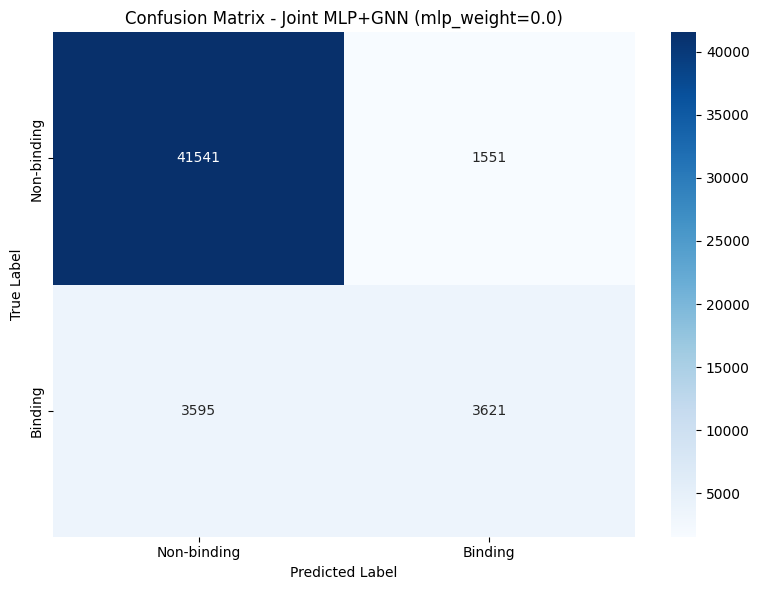

In [230]:
# ============================================================================
# EVALUATION ON TEST SET (GNN output only)
# ============================================================================

joint_model.eval()
test_proteins_joint = [p for p in test_data_cache.keys() if p in test_graph_cache]

all_predictions = []
all_labels = []
all_probs = []

print(f"Evaluating Joint model on test set ({len(test_proteins_joint)} proteins)...")
print(f"Using GNN output only for predictions\n")

with torch.no_grad():
    for protein_name in tqdm(test_proteins_joint, desc="Testing"):
        esm_data = test_data_cache[protein_name]
        graph = test_graph_cache[protein_name].clone().to(device)

        esm_embeddings = esm_data['embeddings'].to(device)
        labels = graph.y

        # Check if sizes match
        if esm_embeddings.shape[0] != graph.x.shape[0]:
            # Skip mismatched proteins
            continue

        gnn_logits, _ = joint_model(esm_embeddings, graph)

        probs = F.softmax(gnn_logits, dim=1)
        probs_positive = probs[:, 1]
        preds = (probs_positive >= THRESHOLD).long()

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs_positive.cpu().numpy())

y_true_joint = np.array(all_labels)
y_pred_joint = np.array(all_predictions)
y_probs_joint = np.array(all_probs)

# Metrics
test_acc = accuracy_score(y_true_joint, y_pred_joint)
test_bal_acc = balanced_accuracy_score(y_true_joint, y_pred_joint)
test_mcc = matthews_corrcoef(y_true_joint, y_pred_joint)
test_roc_auc = roc_auc_score(y_true_joint, y_probs_joint)
test_pr_auc = average_precision_score(y_true_joint, y_probs_joint)

print(f"\n{'='*60}")
print(f"JOINT MLP+GNN TEST RESULTS (mlp_weight={JOINT_CONFIG['mlp_loss_weight']})")
print(f"{'='*60}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Balanced Accuracy: {test_bal_acc:.4f}")
print(f"MCC: {test_mcc:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"PR AUC: {test_pr_auc:.4f}")

# Classification report
target_names = ['Non-binding', 'Binding']
print(f"\n{classification_report(y_true_joint, y_pred_joint, target_names=target_names, zero_division=0)}")

# Confusion matrix
cm = confusion_matrix(y_true_joint, y_pred_joint)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - Joint MLP+GNN (mlp_weight={JOINT_CONFIG["mlp_loss_weight"]})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Save model

In [231]:
# ============================================================================
# SAVE MODEL
# ============================================================================

JOINT_SAVE_PATH = f"final_models/Joint_MLPGNN_binary.pt"

os.makedirs(os.path.dirname(JOINT_SAVE_PATH), exist_ok=True)

torch.save({
    'model_state_dict': joint_model.state_dict(),
    'model_config': JOINT_CONFIG,
    'training_info': {
        'best_val_pr_auc': best_val_pr_auc_joint,
        'num_epochs_trained': epoch + 1,
        'test_pr_auc': test_pr_auc,
        'test_bal_acc': test_bal_acc,
        'test_mcc': test_mcc,
        'init_from_pretrained': JOINT_CONFIG['init_from_pretrained'],
    },
    'class_names': ['Non-binding', 'Binding'],
}, JOINT_SAVE_PATH)

print(f"Model saved to: {JOINT_SAVE_PATH}")

Model saved to: final_models/Joint_MLPGNN_binary.pt


## 8. Binary models comparison

### Evaluation metrics table

In [237]:
# ============================================================================
# MODEL COMPARISON - EVALUATION METRICS TABLE
# ============================================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)

# ============================================================================
# MODEL PATHS - EDIT THESE
# ============================================================================
MODELS_DIR = "/content/drive/MyDrive/Magistro_duomenys/final_models"

MLP_MODEL_PATH = os.path.join(MODELS_DIR, "MLP_only_binary.pt")
GNN_MODEL_PATH = os.path.join(MODELS_DIR, "GNN_structural_only_binary.pt")
GNN_MLP_MODEL_PATH = os.path.join(MODELS_DIR, "GNN_MLP_embeddings_binary.pt")
JOINT_MODEL_PATH = os.path.join(MODELS_DIR, "Joint_MLPGNN_binary.pt")  # <-- Joint model

# ============================================================================
# LOAD MODELS
# ============================================================================
print("Loading models...")

# Load MLP model
mlp_checkpoint = torch.load(MLP_MODEL_PATH, map_location=device, weights_only=False)
mlp_model = BindingSiteMLP(input_dim=1280, hidden_dims=[256, 64, 32], output_dim=2, dropout=0.3)
mlp_model.load_state_dict(mlp_checkpoint['model_state_dict'])
mlp_model = mlp_model.to(device)
mlp_model.eval()
print(f"MLP model loaded from: {MLP_MODEL_PATH}")
print(f"  Config: {mlp_checkpoint.get('model_config', 'N/A')}")
print(f"  Training info: {mlp_checkpoint.get('training_info', 'N/A')}")

# Load GNN model
gnn_checkpoint = torch.load(GNN_MODEL_PATH, map_location=device, weights_only=False)
gnn_model = BindingSiteGNN(
    input_dim=5,
    hidden_dim=128,
    heads=4,
    dropout=0.2,
)
gnn_model.load_state_dict(gnn_checkpoint['model_state_dict'])
gnn_model = gnn_model.to(device)
gnn_model.eval()
print(f"GNN model loaded from: {GNN_MODEL_PATH}")
print(f"  Config: {gnn_checkpoint.get('model_config', 'N/A')}")

# Load GNN + MLP model
gnn_mlp_checkpoint = torch.load(GNN_MLP_MODEL_PATH, map_location=device, weights_only=False)
gnn_mlp_config = gnn_mlp_checkpoint.get('model_config', {})
gnn_mlp_model = BindingSiteGNN(
    input_dim=gnn_mlp_config.get('input_dim', 37),
    hidden_dim=gnn_mlp_config.get('hidden_dim', 256),
    heads=gnn_mlp_config.get('heads', 4),
    dropout=gnn_mlp_config.get('dropout', 0.4),
)
gnn_mlp_model.load_state_dict(gnn_mlp_checkpoint['model_state_dict'])
gnn_mlp_model = gnn_mlp_model.to(device)
gnn_mlp_model.eval()
print(f"GNN + MLP model loaded from: {GNN_MLP_MODEL_PATH}")
print(f"  Config: {gnn_mlp_config}")
print(f"  Training info: {gnn_mlp_checkpoint.get('training_info', 'N/A')}")

# Load Joint MLP+GNN model
joint_checkpoint = torch.load(JOINT_MODEL_PATH, map_location=device, weights_only=False)
joint_config = joint_checkpoint.get('model_config', {})
joint_model = JointMLPGNN(
    mlp_config=joint_config.get('mlp', {'input_dim': 1280, 'hidden_dims': [256, 64, 32], 'output_dim': 2, 'dropout': 0.3}),
    gnn_config=joint_config.get('gnn', {'input_dim': 37, 'hidden_dim': 128, 'heads': 4, 'dropout': 0.3}),
    mlp_loss_weight=joint_config.get('mlp_loss_weight', 0.2)
)
joint_model.load_state_dict(joint_checkpoint['model_state_dict'])
joint_model = joint_model.to(device)
joint_model.eval()
print(f"Joint MLP+GNN model loaded from: {JOINT_MODEL_PATH}")
print(f"  Config: {joint_config}")
print(f"  Training info: {joint_checkpoint.get('training_info', 'N/A')}")

# ============================================================================
# EVALUATION FUNCTION
# ============================================================================
def evaluate_binary_model(y_true, y_pred, y_probs_positive, model_name="Model"):
    """Compute comprehensive metrics for binary classification."""
    metrics = {}
    metrics['Acc'] = accuracy_score(y_true, y_pred)
    metrics['Bal Acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['Pre'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['Rec'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['F1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['Pre (binding)'] = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['Rec (binding)'] = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['F1 (binding)'] = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    try:
        metrics['ROC AUC'] = roc_auc_score(y_true, y_probs_positive)
        metrics['PR AUC'] = average_precision_score(y_true, y_probs_positive)
    except ValueError as e:
        metrics['ROC AUC'] = np.nan
        metrics['PR AUC'] = np.nan
    return metrics

# ============================================================================
# EVALUATE MLP
# ============================================================================
print("\nEvaluating MLP model...")
mlp_all_preds, mlp_all_labels, mlp_all_probs = [], [], []

with torch.no_grad():
    for protein_name, data in tqdm(test_data_cache.items(), desc="MLP Evaluation"):
        embeddings = data['embeddings'].to(device)
        labels = data['y_bin']
        probs = mlp_model(embeddings, return_probs=True)
        preds = torch.argmax(probs, dim=1)

        mlp_all_preds.extend(preds.cpu().numpy())
        mlp_all_labels.extend(labels.numpy())
        mlp_all_probs.extend(probs[:, 1].cpu().numpy())

mlp_y_true = np.array(mlp_all_labels)
mlp_y_pred = np.array(mlp_all_preds)
mlp_y_probs_positive = np.array(mlp_all_probs)

# ============================================================================
# EVALUATE GNN (Structural only)
# ============================================================================
print("Evaluating GNN model...")
gnn_all_preds, gnn_all_labels, gnn_all_probs = [], [], []

with torch.no_grad():
    for protein_name, graph in tqdm(test_graph_cache.items(), desc="GNN Evaluation"):
        graph = graph.to(device)
        logits = gnn_model(graph)

        if logits.dim() > 1 and logits.shape[-1] == 2:
            probs = F.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1)
            probs_positive = probs[:, 1]
        else:
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            probs_positive = probs

        gnn_all_preds.extend(preds.cpu().numpy())
        gnn_all_labels.extend(graph.y.cpu().numpy())
        gnn_all_probs.extend(probs_positive.cpu().numpy())

gnn_y_true = np.array(gnn_all_labels)
gnn_y_pred = np.array(gnn_all_preds)
gnn_y_probs_positive = np.array(gnn_all_probs)

# ============================================================================
# EVALUATE GNN + MLP (pre-computed embeddings)
# ============================================================================
print("Evaluating GNN + MLP model...")
gnn_mlp_all_preds, gnn_mlp_all_labels, gnn_mlp_all_probs = [], [], []

with torch.no_grad():
    for protein_name, graph in tqdm(test_gnn_mlp_cache.items(), desc="GNN+MLP Evaluation"):
        graph = graph.to(device)
        logits = gnn_mlp_model(graph)

        if logits.dim() > 1 and logits.shape[-1] == 2:
            probs = F.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1)
            probs_positive = probs[:, 1]
        else:
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            probs_positive = probs

        gnn_mlp_all_preds.extend(preds.cpu().numpy())
        gnn_mlp_all_labels.extend(graph.y.cpu().numpy())
        gnn_mlp_all_probs.extend(probs_positive.cpu().numpy())

gnn_mlp_y_true = np.array(gnn_mlp_all_labels)
gnn_mlp_y_pred = np.array(gnn_mlp_all_preds)
gnn_mlp_y_probs_positive = np.array(gnn_mlp_all_probs)

# ============================================================================
# EVALUATE JOINT MLP+GNN (end-to-end)
# ============================================================================
print("Evaluating Joint MLP+GNN model...")
joint_all_preds, joint_all_labels, joint_all_probs = [], [], []

# Get aligned test proteins
test_proteins_joint = [p for p in test_data_cache.keys()
                       if p in test_graph_cache
                       and test_data_cache[p]['embeddings'].shape[0] == test_graph_cache[p].x.shape[0]]

with torch.no_grad():
    for protein_name in tqdm(test_proteins_joint, desc="Joint Evaluation"):
        esm_data = test_data_cache[protein_name]
        graph = test_graph_cache[protein_name].clone().to(device)

        esm_embeddings = esm_data['embeddings'].to(device)
        labels = graph.y

        # Joint model returns (gnn_logits, mlp_logits) - use GNN output
        gnn_logits, _ = joint_model(esm_embeddings, graph)

        probs = F.softmax(gnn_logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        probs_positive = probs[:, 1]

        joint_all_preds.extend(preds.cpu().numpy())
        joint_all_labels.extend(labels.cpu().numpy())
        joint_all_probs.extend(probs_positive.cpu().numpy())

joint_y_true = np.array(joint_all_labels)
joint_y_pred = np.array(joint_all_preds)
joint_y_probs_positive = np.array(joint_all_probs)

# ============================================================================
# CREATE COMPARISON TABLE
# ============================================================================
mlp_metrics = evaluate_binary_model(mlp_y_true, mlp_y_pred, mlp_y_probs_positive, "MLP")
gnn_metrics = evaluate_binary_model(gnn_y_true, gnn_y_pred, gnn_y_probs_positive, "GNN")
gnn_mlp_metrics = evaluate_binary_model(gnn_mlp_y_true, gnn_mlp_y_pred, gnn_mlp_y_probs_positive, "GNN+MLP emb")
joint_metrics = evaluate_binary_model(joint_y_true, joint_y_pred, joint_y_probs_positive, "Joint")

metric_order = [
    'Acc', 'Bal Acc', 'MCC',
    'Pre', 'Rec', 'F1',
    'Pre (binding)', 'Rec (binding)', 'F1 (binding)',
    'ROC AUC', 'PR AUC'
]

# Create dataframe with models as rows and metrics as columns
comparison_df = pd.DataFrame({
    metric: [mlp_metrics[metric], gnn_metrics[metric], gnn_mlp_metrics[metric], joint_metrics[metric]]
    for metric in metric_order
}, index=['MLP', 'GNN', 'GNN+MLP emb', 'Joint'])

print(f"\n{'='*120}")
print("BINARY CLASSIFICATION MODEL COMPARISON")
print(f"{'='*120}\n")

# Format for display
display_df = comparison_df.apply(lambda x: x.map(lambda v: f"{v:.4f}" if pd.notna(v) else "N/A"))
print(display_df.to_string())

# Store for curve plotting
model_results = {
    'MLP': {'y_true': mlp_y_true, 'y_probs': mlp_y_probs_positive, 'metrics': mlp_metrics},
    'GNN': {'y_true': gnn_y_true, 'y_probs': gnn_y_probs_positive, 'metrics': gnn_metrics},
    'GNN+MLP emb': {'y_true': gnn_mlp_y_true, 'y_probs': gnn_mlp_y_probs_positive, 'metrics': gnn_mlp_metrics},
    'Joint': {'y_true': joint_y_true, 'y_probs': joint_y_probs_positive, 'metrics': joint_metrics}
}

Loading models...
MLP model loaded from: /content/drive/MyDrive/Magistro_duomenys/final_models/MLP_only_binary.pt
  Config: {'input_dim': 1280, 'hidden_dims': [256, 64, 32], 'output_dim': 2, 'dropout': 0.6}
  Training info: {'best_val_bal_acc': np.float64(0.716685301774499), 'threshold': 0.66, 'class_weights': [0.5877638459205627, 3.348553419113159], 'num_epochs_trained': 50}
GNN model loaded from: /content/drive/MyDrive/Magistro_duomenys/final_models/GNN_structural_only_binary.pt
  Config: {'input_dim': 5, 'hidden_dim': 128, 'heads': 4, 'dropout': 0.2, 'num_amino_acids': 20, 'aa_embed_dim': 32, 'output_dim': 2}
GNN + MLP model loaded from: /content/drive/MyDrive/Magistro_duomenys/final_models/GNN_MLP_embeddings_binary.pt
  Config: {'input_dim': 37, 'hidden_dim': 256, 'heads': 4, 'dropout': 0.5, 'num_amino_acids': 20, 'aa_embed_dim': 32}
  Training info: {'best_val_bal_acc': np.float64(0.8236373648637327), 'num_epochs_trained': 43, 'test_bal_acc': np.float64(0.7771963079173233), 'test_

MLP Evaluation: 100%|██████████| 234/234 [00:00<00:00, 1019.91it/s]


Evaluating GNN model...


GNN Evaluation: 100%|██████████| 234/234 [00:00<00:00, 322.74it/s]


Evaluating GNN + MLP model...


GNN+MLP Evaluation: 100%|██████████| 234/234 [00:00<00:00, 298.71it/s]


Evaluating Joint MLP+GNN model...


Joint Evaluation: 100%|██████████| 230/230 [00:00<00:00, 248.55it/s]



BINARY CLASSIFICATION MODEL COMPARISON

                Acc Bal Acc     MCC     Pre     Rec      F1 Pre (binding) Rec (binding) F1 (binding) ROC AUC  PR AUC
MLP          0.8565  0.8232  0.5387  0.7245  0.8232  0.7562        0.4885        0.7772       0.5999  0.9030  0.6524
GNN          0.6215  0.6563  0.2179  0.5759  0.6563  0.5375        0.2244        0.7044       0.3404  0.7132  0.2949
GNN+MLP emb  0.8493  0.8302  0.5381  0.7192  0.8302  0.7518        0.4739        0.8038       0.5963  0.8992  0.6581
Joint        0.8913  0.7843  0.5626  0.7783  0.7843  0.7813        0.6182        0.6343       0.6261  0.9031  0.6554


### ROC AND PR curves visualization

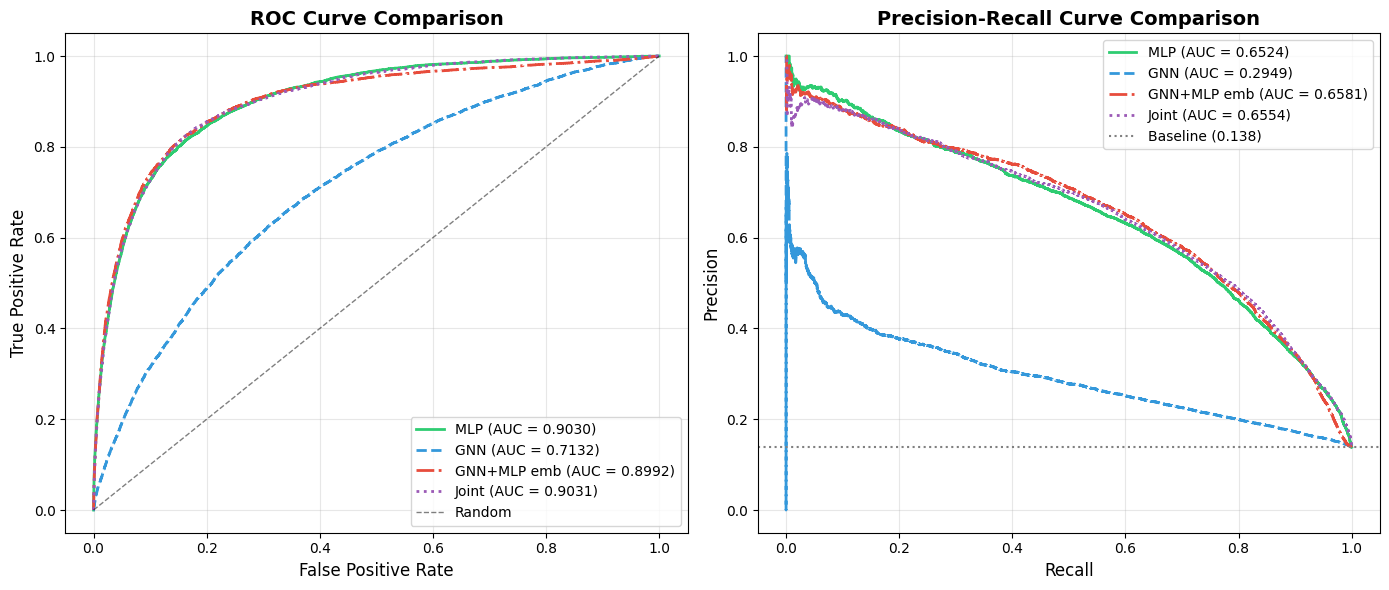

In [238]:
# ============================================================================
# MODEL COMPARISON - PR AND ROC CURVES
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'MLP': '#2ecc71', 'GNN': '#3498db', 'GNN+MLP emb': '#e74c3c', 'Joint': '#9b59b6'}
linestyles = {'MLP': '-', 'GNN': '--', 'GNN+MLP emb': '-.', 'Joint': ':'}

# ROC Curves
ax1 = axes[0]
for model_name, results in model_results.items():
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_probs'])
    auc_score = results['metrics']['ROC AUC']
    ax1.plot(fpr, tpr, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2, label=f"{model_name} (AUC = {auc_score:.4f})")

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# PR Curves
ax2 = axes[1]
baseline = np.mean(model_results['MLP']['y_true'])

for model_name, results in model_results.items():
    precision, recall, _ = precision_recall_curve(results['y_true'], results['y_probs'])
    pr_auc = results['metrics']['PR AUC']
    ax2.plot(recall, precision, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2, label=f"{model_name} (AUC = {pr_auc:.4f})")

ax2.axhline(y=baseline, color='gray', linestyle=':', label=f'Baseline ({baseline:.3f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_curves_4models.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Multiclass models training

## Multiclass configuration and class weights

In [26]:
# ============================================================================
# MULTICLASS CONFIGURATION (3 classes: Non-binding, DNA, RNA)
# ============================================================================

print(f"\n{'='*60}")
print("MULTICLASS CLASSIFICATION SETUP")
print(f"{'='*60}")
print("Classes: 0=Non-binding, 1=DNA, 2=RNA\n")

# Calculate class weights from training data
all_labels_multi = []
for protein_name, data in train_data_cache.items():
    all_labels_multi.extend(data['y_multi'].numpy())

all_labels_multi = np.array(all_labels_multi)
unique_classes, class_counts = np.unique(all_labels_multi, return_counts=True)
total = len(all_labels_multi)

class_weights_multi = torch.zeros(3, dtype=torch.float32)
for cls, count in zip(unique_classes, class_counts):
    class_weights_multi[cls] = total / (len(unique_classes) * count)
class_weights_multi = class_weights_multi.to(device)

print(f"Multiclass Training - Class distribution:")
target_names_multi = ['Non-binding', 'DNA', 'RNA']
for cls, count in zip(unique_classes, class_counts):
    print(f"  {target_names_multi[cls]} ({cls}): {count:,} ({100*count/total:.1f}%)")
print(f"\nClass weights: {class_weights_multi.cpu().numpy()}")


MULTICLASS CLASSIFICATION SETUP
Classes: 0=Non-binding, 1=DNA, 2=RNA

Multiclass Training - Class distribution:
  Non-binding (0): 152,221 (85.1%)
  DNA (1): 20,173 (11.3%)
  RNA (2): 6,546 (3.7%)

Class weights: [0.39184257 2.9567573  9.111926  ]


## 9.1 MLP model training

In [18]:
# ============================================================================
# 9.1 MLP MULTICLASS MODEL
# ============================================================================

# Initialize model - 3 classes output
mlp_model_multi = BindingSiteMLP(
    input_dim=1280,
    hidden_dims=[256, 64, 32],
    output_dim=3,  # 3 classes
    dropout=0.3
).to(device)

print("MLP Multiclass Model:")
print(f"  Input: 1280, Hidden: [256, 64, 32], Output: 3")
print(f"  Total parameters: {sum(p.numel() for p in mlp_model_multi.parameters()):,}")

# Training configuration
criterion_mlp_multi = FocalLoss(alpha=class_weights_multi, gamma=2.0, reduction='mean')
optimizer_mlp_multi = optim.Adam(mlp_model_multi.parameters(), lr=0.001)
num_epochs = 50
batch_size = 64
PATIENCE = 10

# Training history
train_losses_mlp_multi = []
train_balanced_accs_mlp_multi = []
val_pr_aucs_mlp_multi = []

best_val_pr_auc_mlp_multi = 0.0
patience_counter = 0
best_model_state_mlp_multi = None

train_protein_names = list(train_data_cache.keys())
val_protein_names = list(val_data_cache.keys())

print(f"\nStarting MLP Multiclass training...")
print(f"Early stopping: patience={PATIENCE} (monitoring val macro PR AUC)\n")

for epoch in range(num_epochs):
    # ===== TRAINING =====
    mlp_model_multi.train()
    epoch_loss = 0.0
    epoch_n_residues = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_protein_names)

    for i in tqdm(range(0, len(train_protein_names), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        batch_proteins = train_protein_names[i:i + batch_size]

        batch_embeddings = []
        batch_labels = []
        for protein_name in batch_proteins:
            data = train_data_cache[protein_name]
            batch_embeddings.append(data['embeddings'])
            batch_labels.append(data['y_multi'])  # Use multiclass labels

        batch_embeddings = torch.cat(batch_embeddings, dim=0).to(device)
        batch_labels = torch.cat(batch_labels, dim=0).to(device)

        optimizer_mlp_multi.zero_grad()
        outputs = mlp_model_multi(batch_embeddings)
        loss = criterion_mlp_multi(outputs, batch_labels)
        loss.backward()
        optimizer_mlp_multi.step()

        epoch_loss += loss.item() * len(batch_labels)
        epoch_n_residues += len(batch_labels)

        predicted = torch.argmax(outputs, dim=1)
        epoch_all_labels.extend(batch_labels.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    train_loss = epoch_loss / epoch_n_residues
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)
    train_losses_mlp_multi.append(train_loss)
    train_balanced_accs_mlp_multi.append(train_bal_acc)

    # ===== VALIDATION =====
    mlp_model_multi.eval()
    val_all_labels = []
    val_all_preds = []
    val_all_probs = []

    with torch.no_grad():
        for i in range(0, len(val_protein_names), batch_size):
            batch_proteins = val_protein_names[i:i + batch_size]

            batch_embeddings = []
            batch_labels = []
            for protein_name in batch_proteins:
                data = val_data_cache[protein_name]
                batch_embeddings.append(data['embeddings'])
                batch_labels.append(data['y_multi'])

            batch_embeddings = torch.cat(batch_embeddings, dim=0).to(device)
            batch_labels = torch.cat(batch_labels, dim=0).to(device)

            outputs = mlp_model_multi(batch_embeddings)
            probs = F.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)

            val_all_labels.extend(batch_labels.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.append(probs.cpu().numpy())

    val_all_probs = np.vstack(val_all_probs)
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)

    # Macro PR AUC (one-vs-rest)
    val_pr_auc = average_precision_score(
        np.eye(3)[val_all_labels], val_all_probs, average='macro'
    )
    val_pr_aucs_mlp_multi.append(val_pr_auc)

    if val_pr_auc > best_val_pr_auc_mlp_multi:
        best_val_pr_auc_mlp_multi = val_pr_auc
        patience_counter = 0
        best_model_state_mlp_multi = mlp_model_multi.state_dict().copy()
        improvement_marker = " +"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} "
          f"| Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

if best_model_state_mlp_multi is not None:
    mlp_model_multi.load_state_dict(best_model_state_mlp_multi)
    print(f"\n* Restored best model (val PR-AUC: {best_val_pr_auc_mlp_multi:.4f})")

MLP Multiclass Model:
  Input: 1280, Hidden: [256, 64, 32], Output: 3
  Total parameters: 347,267

Starting MLP Multiclass training...
Early stopping: patience=10 (monitoring val macro PR AUC)



Epoch [1/50] - Train Loss: 0.4831, Bal-Acc: 0.4664 | Val Bal-Acc: 0.5502, PR-AUC: 0.5426 + | Patience: 0/10


Epoch [2/50] - Train Loss: 0.3775, Bal-Acc: 0.5977 | Val Bal-Acc: 0.6443, PR-AUC: 0.5664 + | Patience: 0/10


Epoch [3/50] - Train Loss: 0.3249, Bal-Acc: 0.6713 | Val Bal-Acc: 0.6723, PR-AUC: 0.5858 + | Patience: 0/10


Epoch [4/50] - Train Loss: 0.2899, Bal-Acc: 0.7115 | Val Bal-Acc: 0.6858, PR-AUC: 0.5981 + | Patience: 0/10


Epoch [5/50] - Train Loss: 0.2649, Bal-Acc: 0.7409 | Val Bal-Acc: 0.6972, PR-AUC: 0.6042 + | Patience: 0/10


Epoch [6/50] - Train Loss: 0.2513, Bal-Acc: 0.7518 | Val Bal-Acc: 0.7041, PR-AUC: 0.6128 + | Patience: 0/10


Epoch [7/50] - Train Loss: 0.2250, Bal-Acc: 0.7745 | Val Bal-Acc: 0.6946, PR-AUC: 0.6066 | Patience: 1/10


Epoch [8/50] - Train Loss: 0.2081, Bal-Acc: 0.7898 | Val Bal-Acc: 0.7126, PR-AUC: 0.6165 + | Patience: 0/10


Epoch [9/50] - Train Loss: 0.1939, Bal-Acc: 0.8022 | Val Bal-Acc: 0.7054, PR-AUC: 0.6199 + | Patience: 0/10


Epoch [10/50] - Train Loss: 0.1764, Bal-Acc: 0.8161 | Val Bal-Acc: 0.7237, PR-AUC: 0.6314 + | Patience: 0/10


Epoch [11/50] - Train Loss: 0.1609, Bal-Acc: 0.8269 | Val Bal-Acc: 0.7240, PR-AUC: 0.6321 + | Patience: 0/10


Epoch [12/50] - Train Loss: 0.1545, Bal-Acc: 0.8328 | Val Bal-Acc: 0.7226, PR-AUC: 0.6295 | Patience: 1/10


Epoch [13/50] - Train Loss: 0.1423, Bal-Acc: 0.8424 | Val Bal-Acc: 0.7350, PR-AUC: 0.6379 + | Patience: 0/10


Epoch [14/50] - Train Loss: 0.1374, Bal-Acc: 0.8446 | Val Bal-Acc: 0.7179, PR-AUC: 0.6339 | Patience: 1/10


Epoch [15/50] - Train Loss: 0.1311, Bal-Acc: 0.8492 | Val Bal-Acc: 0.7393, PR-AUC: 0.6455 + | Patience: 0/10


Epoch [16/50] - Train Loss: 0.1271, Bal-Acc: 0.8530 | Val Bal-Acc: 0.7333, PR-AUC: 0.6423 | Patience: 1/10


Epoch [17/50] - Train Loss: 0.1184, Bal-Acc: 0.8604 | Val Bal-Acc: 0.7395, PR-AUC: 0.6468 + | Patience: 0/10


Epoch [18/50] - Train Loss: 0.1117, Bal-Acc: 0.8662 | Val Bal-Acc: 0.7276, PR-AUC: 0.6409 | Patience: 1/10


Epoch [19/50] - Train Loss: 0.1106, Bal-Acc: 0.8669 | Val Bal-Acc: 0.7238, PR-AUC: 0.6418 | Patience: 2/10


Epoch [20/50] - Train Loss: 0.1060, Bal-Acc: 0.8708 | Val Bal-Acc: 0.7470, PR-AUC: 0.6634 + | Patience: 0/10


Epoch [21/50] - Train Loss: 0.1072, Bal-Acc: 0.8696 | Val Bal-Acc: 0.7290, PR-AUC: 0.6524 | Patience: 1/10


Epoch [22/50] - Train Loss: 0.1014, Bal-Acc: 0.8757 | Val Bal-Acc: 0.7340, PR-AUC: 0.6508 | Patience: 2/10


Epoch [23/50] - Train Loss: 0.0983, Bal-Acc: 0.8805 | Val Bal-Acc: 0.7388, PR-AUC: 0.6563 | Patience: 3/10


Epoch [24/50] - Train Loss: 0.0972, Bal-Acc: 0.8807 | Val Bal-Acc: 0.7228, PR-AUC: 0.6489 | Patience: 4/10


Epoch [25/50] - Train Loss: 0.0993, Bal-Acc: 0.8818 | Val Bal-Acc: 0.7284, PR-AUC: 0.6592 | Patience: 5/10


Epoch [26/50] - Train Loss: 0.0965, Bal-Acc: 0.8829 | Val Bal-Acc: 0.7431, PR-AUC: 0.6584 | Patience: 6/10


Epoch [27/50] - Train Loss: 0.0948, Bal-Acc: 0.8835 | Val Bal-Acc: 0.7338, PR-AUC: 0.6566 | Patience: 7/10


Epoch [28/50] - Train Loss: 0.0899, Bal-Acc: 0.8896 | Val Bal-Acc: 0.7315, PR-AUC: 0.6600 | Patience: 8/10


Epoch [29/50] - Train Loss: 0.0879, Bal-Acc: 0.8913 | Val Bal-Acc: 0.7360, PR-AUC: 0.6622 | Patience: 9/10


Epoch [30/50] - Train Loss: 0.0874, Bal-Acc: 0.8924 | Val Bal-Acc: 0.7314, PR-AUC: 0.6525 | Patience: 10/10

Early stopping at epoch 30

* Restored best model (val PR-AUC: 0.6634)


### Save model

In [19]:
# Save MLP Multiclass
MLP_MULTI_SAVE_PATH = "final_models/MLP_multiclass.pt"
os.makedirs(os.path.dirname(MLP_MULTI_SAVE_PATH), exist_ok=True)

torch.save({
    'model_state_dict': mlp_model_multi.state_dict(),
    'model_config': {'input_dim': 1280, 'hidden_dims': [256, 64, 32], 'output_dim': 3, 'dropout': 0.3},
    'training_info': {'best_val_pr_auc': best_val_pr_auc_mlp_multi, 'num_epochs': epoch + 1},
    'class_names': ['Non-binding', 'DNA', 'RNA'],
}, MLP_MULTI_SAVE_PATH)
print(f"MLP Multiclass saved to: {MLP_MULTI_SAVE_PATH}")

MLP Multiclass saved to: final_models/MLP_multiclass.pt


## 9.2 GNN (structure only) model training

In [25]:
# ============================================================================
# 9.2 GNN STRUCTURAL MULTICLASS MODEL
# ============================================================================
from torch_geometric.data import Batch
# Calculate class weights from graph cache
all_labels_gnn_multi = []
for graph in train_graph_cache.values():
    all_labels_gnn_multi.extend(graph.y.cpu().numpy())
# Note: graph.y contains binary labels, need to load multiclass labels

# Actually, we need multiclass labels for GNN. Let's create them from train_data_cache
# and ensure alignment
print("Creating multiclass labels for GNN graphs...")

# Create mapping from protein to multiclass labels
protein_to_multi_labels = {}
for protein_name, data in train_data_cache.items():
    protein_to_multi_labels[protein_name] = data['y_multi']

# Recalculate class weights using aligned data
all_labels_gnn_multi = []
for protein_name in train_graph_cache.keys():
    if protein_name in protein_to_multi_labels:
        # Check alignment
        n_graph = train_graph_cache[protein_name].num_nodes
        n_labels = len(protein_to_multi_labels[protein_name])
        if n_graph == n_labels:
            all_labels_gnn_multi.extend(protein_to_multi_labels[protein_name].numpy())

all_labels_gnn_multi = np.array(all_labels_gnn_multi)
unique_classes, class_counts = np.unique(all_labels_gnn_multi, return_counts=True)
total = len(all_labels_gnn_multi)

class_weights_gnn_multi = torch.zeros(3, dtype=torch.float32)
for cls, count in zip(unique_classes, class_counts):
    class_weights_gnn_multi[cls] = total / (len(unique_classes) * count)
class_weights_gnn_multi = class_weights_gnn_multi.to(device)

print(f"GNN Multiclass - Class distribution: {dict(zip(unique_classes, class_counts))}")
print(f"Class weights: {class_weights_gnn_multi.cpu().numpy()}")

# Initialize GNN model - 3 classes
gnn_model_multi = BindingSiteGNN(
    input_dim=5,
    hidden_dim=128,
    heads=4,
    dropout=0.3,
    output_dim = 3,
    num_amino_acids=20,
).to(device)

# Note: If ProteinAttnGNN doesn't support mode="multiclass", modify the model or use output_dim=3

print(f"\nGNN Multiclass Model initialized")
print(f"  Total parameters: {sum(p.numel() for p in gnn_model_multi.parameters()):,}")

# Training configuration
criterion_gnn_multi = FocalLoss(alpha=class_weights_gnn_multi, gamma=2.0, reduction='mean')
optimizer_gnn_multi = optim.Adam(gnn_model_multi.parameters(), lr=0.001)
num_epochs = 50
batch_size = 64
PATIENCE = 10

# Get aligned proteins
train_proteins_gnn_multi = [p for p in train_graph_cache.keys()
                            if p in train_data_cache
                            and train_graph_cache[p].num_nodes == len(train_data_cache[p]['y_multi'])]
val_proteins_gnn_multi = [p for p in val_graph_cache.keys()
                          if p in val_data_cache
                          and val_graph_cache[p].num_nodes == len(val_data_cache[p]['y_multi'])]

print(f"Aligned proteins - Train: {len(train_proteins_gnn_multi)}, Val: {len(val_proteins_gnn_multi)}")

# Training history
best_val_pr_auc_gnn_multi = 0.0
patience_counter = 0
best_model_state_gnn_multi = None

# Create graph list with multiclass labels
train_graphs_multi = []
for protein_name in train_proteins_gnn_multi:
    graph = train_graph_cache[protein_name].clone()
    graph.y = train_data_cache[protein_name]['y_multi']  # Replace with multiclass labels
    train_graphs_multi.append(graph)

val_graphs_multi = []
for protein_name in val_proteins_gnn_multi:
    graph = val_graph_cache[protein_name].clone()
    graph.y = val_data_cache[protein_name]['y_multi']
    val_graphs_multi.append(graph)

print(f"\nStarting GNN Multiclass training...")

for epoch in range(num_epochs):
    # ===== TRAINING =====
    gnn_model_multi.train()
    epoch_loss = 0.0
    epoch_n_nodes = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_graphs_multi)

    for i in tqdm(range(0, len(train_graphs_multi), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        batch_graphs = train_graphs_multi[i:i + batch_size]
        batched_data = Batch.from_data_list(batch_graphs).to(device)

        optimizer_gnn_multi.zero_grad()
        outputs = gnn_model_multi(batched_data)
        loss = criterion_gnn_multi(outputs, batched_data.y)
        loss.backward()
        optimizer_gnn_multi.step()

        epoch_loss += loss.item() * batched_data.num_nodes
        epoch_n_nodes += batched_data.num_nodes

        predicted = torch.argmax(outputs, dim=1)
        epoch_all_labels.extend(batched_data.y.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    train_loss = epoch_loss / epoch_n_nodes
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

    # ===== VALIDATION =====
    gnn_model_multi.eval()
    val_all_labels = []
    val_all_preds = []
    val_all_probs = []

    with torch.no_grad():
        for i in range(0, len(val_graphs_multi), batch_size):
            batch_graphs = val_graphs_multi[i:i + batch_size]
            batched_data = Batch.from_data_list(batch_graphs).to(device)

            outputs = gnn_model_multi(batched_data)
            probs = F.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)

            val_all_labels.extend(batched_data.y.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.append(probs.cpu().numpy())

    val_all_probs = np.vstack(val_all_probs)
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
    val_pr_auc = average_precision_score(np.eye(3)[val_all_labels], val_all_probs, average='macro')

    if val_pr_auc > best_val_pr_auc_gnn_multi:
        best_val_pr_auc_gnn_multi = val_pr_auc
        patience_counter = 0
        best_model_state_gnn_multi = gnn_model_multi.state_dict().copy()
        improvement_marker = " +"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} "
          f"| Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

if best_model_state_gnn_multi is not None:
    gnn_model_multi.load_state_dict(best_model_state_gnn_multi)
    print(f"\n* Restored best model (val PR-AUC: {best_val_pr_auc_gnn_multi:.4f})")

Creating multiclass labels for GNN graphs...
GNN Multiclass - Class distribution: {np.int64(0): np.int64(146117), np.int64(1): np.int64(19902), np.int64(2): np.int64(6292)}
Class weights: [0.3930891 2.8859913 9.128576 ]

GNN Multiclass Model initialized
  Total parameters: 173,827
Aligned proteins - Train: 807, Val: 116

Starting GNN Multiclass training...


Epoch [1/50] - Train Loss: 0.5030, Bal-Acc: 0.3573 | Val Bal-Acc: 0.3945, PR-AUC: 0.3755 + | Patience: 0/10


Epoch [2/50] - Train Loss: 0.4810, Bal-Acc: 0.4095 | Val Bal-Acc: 0.4178, PR-AUC: 0.3837 + | Patience: 0/10


Epoch [3/50] - Train Loss: 0.4697, Bal-Acc: 0.4359 | Val Bal-Acc: 0.4261, PR-AUC: 0.3868 + | Patience: 0/10


Epoch [4/50] - Train Loss: 0.4683, Bal-Acc: 0.4334 | Val Bal-Acc: 0.4320, PR-AUC: 0.3903 + | Patience: 0/10


Epoch [5/50] - Train Loss: 0.4650, Bal-Acc: 0.4424 | Val Bal-Acc: 0.4344, PR-AUC: 0.3914 + | Patience: 0/10


Epoch [6/50] - Train Loss: 0.4642, Bal-Acc: 0.4497 | Val Bal-Acc: 0.4093, PR-AUC: 0.3924 + | Patience: 0/10


Epoch [7/50] - Train Loss: 0.4667, Bal-Acc: 0.4410 | Val Bal-Acc: 0.4403, PR-AUC: 0.3950 + | Patience: 0/10


Epoch [8/50] - Train Loss: 0.4613, Bal-Acc: 0.4497 | Val Bal-Acc: 0.4408, PR-AUC: 0.3964 + | Patience: 0/10


Epoch [9/50] - Train Loss: 0.4606, Bal-Acc: 0.4554 | Val Bal-Acc: 0.4331, PR-AUC: 0.3978 + | Patience: 0/10


Epoch [10/50] - Train Loss: 0.4556, Bal-Acc: 0.4681 | Val Bal-Acc: 0.4468, PR-AUC: 0.3995 + | Patience: 0/10


Epoch [11/50] - Train Loss: 0.4543, Bal-Acc: 0.4702 | Val Bal-Acc: 0.4499, PR-AUC: 0.4008 + | Patience: 0/10


Epoch [12/50] - Train Loss: 0.4530, Bal-Acc: 0.4748 | Val Bal-Acc: 0.4542, PR-AUC: 0.4019 + | Patience: 0/10


Epoch [13/50] - Train Loss: 0.4506, Bal-Acc: 0.4787 | Val Bal-Acc: 0.4545, PR-AUC: 0.4026 + | Patience: 0/10


Epoch [14/50] - Train Loss: 0.4506, Bal-Acc: 0.4770 | Val Bal-Acc: 0.4575, PR-AUC: 0.4027 + | Patience: 0/10


Epoch [15/50] - Train Loss: 0.4475, Bal-Acc: 0.4855 | Val Bal-Acc: 0.4562, PR-AUC: 0.4036 + | Patience: 0/10


Epoch [16/50] - Train Loss: 0.4467, Bal-Acc: 0.4865 | Val Bal-Acc: 0.4555, PR-AUC: 0.4037 + | Patience: 0/10


Epoch [17/50] - Train Loss: 0.4453, Bal-Acc: 0.4894 | Val Bal-Acc: 0.4534, PR-AUC: 0.4053 + | Patience: 0/10


Epoch [18/50] - Train Loss: 0.4467, Bal-Acc: 0.4808 | Val Bal-Acc: 0.4532, PR-AUC: 0.4052 | Patience: 1/10


Epoch [19/50] - Train Loss: 0.4453, Bal-Acc: 0.4888 | Val Bal-Acc: 0.4614, PR-AUC: 0.4079 + | Patience: 0/10


Epoch [20/50] - Train Loss: 0.4420, Bal-Acc: 0.4939 | Val Bal-Acc: 0.4603, PR-AUC: 0.4071 | Patience: 1/10


Epoch [21/50] - Train Loss: 0.4399, Bal-Acc: 0.4981 | Val Bal-Acc: 0.4652, PR-AUC: 0.4081 + | Patience: 0/10


Epoch [22/50] - Train Loss: 0.4393, Bal-Acc: 0.4998 | Val Bal-Acc: 0.4620, PR-AUC: 0.4074 | Patience: 1/10


Epoch [23/50] - Train Loss: 0.4404, Bal-Acc: 0.4946 | Val Bal-Acc: 0.4525, PR-AUC: 0.4053 | Patience: 2/10


Epoch [24/50] - Train Loss: 0.4403, Bal-Acc: 0.4944 | Val Bal-Acc: 0.4661, PR-AUC: 0.4068 | Patience: 3/10


Epoch [25/50] - Train Loss: 0.4339, Bal-Acc: 0.5100 | Val Bal-Acc: 0.4633, PR-AUC: 0.4085 + | Patience: 0/10


Epoch [26/50] - Train Loss: 0.4368, Bal-Acc: 0.5055 | Val Bal-Acc: 0.4675, PR-AUC: 0.4069 | Patience: 1/10


Epoch [27/50] - Train Loss: 0.4387, Bal-Acc: 0.4941 | Val Bal-Acc: 0.4709, PR-AUC: 0.4089 + | Patience: 0/10


Epoch [28/50] - Train Loss: 0.4328, Bal-Acc: 0.5072 | Val Bal-Acc: 0.4637, PR-AUC: 0.4077 | Patience: 1/10


Epoch [29/50] - Train Loss: 0.4340, Bal-Acc: 0.5038 | Val Bal-Acc: 0.4633, PR-AUC: 0.4074 | Patience: 2/10


Epoch [30/50] - Train Loss: 0.4292, Bal-Acc: 0.5155 | Val Bal-Acc: 0.4664, PR-AUC: 0.4088 | Patience: 3/10


Epoch [31/50] - Train Loss: 0.4270, Bal-Acc: 0.5204 | Val Bal-Acc: 0.4628, PR-AUC: 0.4083 | Patience: 4/10


Epoch [32/50] - Train Loss: 0.4304, Bal-Acc: 0.5103 | Val Bal-Acc: 0.4670, PR-AUC: 0.4090 + | Patience: 0/10


Epoch [33/50] - Train Loss: 0.4264, Bal-Acc: 0.5195 | Val Bal-Acc: 0.4663, PR-AUC: 0.4066 | Patience: 1/10


Epoch [34/50] - Train Loss: 0.4241, Bal-Acc: 0.5225 | Val Bal-Acc: 0.4700, PR-AUC: 0.4067 | Patience: 2/10


Epoch [35/50] - Train Loss: 0.4297, Bal-Acc: 0.5121 | Val Bal-Acc: 0.4419, PR-AUC: 0.4002 | Patience: 3/10


Epoch [36/50] - Train Loss: 0.4502, Bal-Acc: 0.4773 | Val Bal-Acc: 0.4667, PR-AUC: 0.4068 | Patience: 4/10


Epoch [37/50] - Train Loss: 0.4381, Bal-Acc: 0.4975 | Val Bal-Acc: 0.4679, PR-AUC: 0.4083 | Patience: 5/10


Epoch [38/50] - Train Loss: 0.4362, Bal-Acc: 0.4973 | Val Bal-Acc: 0.4604, PR-AUC: 0.4066 | Patience: 6/10


Epoch [39/50] - Train Loss: 0.4258, Bal-Acc: 0.5223 | Val Bal-Acc: 0.4651, PR-AUC: 0.4076 | Patience: 7/10


Epoch [40/50] - Train Loss: 0.4288, Bal-Acc: 0.5143 | Val Bal-Acc: 0.4675, PR-AUC: 0.4063 | Patience: 8/10


Epoch [41/50] - Train Loss: 0.4244, Bal-Acc: 0.5252 | Val Bal-Acc: 0.4538, PR-AUC: 0.4089 | Patience: 9/10


Epoch [42/50] - Train Loss: 0.4264, Bal-Acc: 0.5144 | Val Bal-Acc: 0.4677, PR-AUC: 0.4079 | Patience: 10/10

Early stopping at epoch 42

* Restored best model (val PR-AUC: 0.4090)


### Save model

In [26]:
GNN_MULTI_SAVE_PATH = "final_models/GNN_structural_multiclass.pt"
torch.save({
    'model_state_dict': gnn_model_multi.state_dict(),
    'model_config': {'input_dim': 5, 'hidden_dim': 128, 'heads': 4, 'dropout': 0.3, 'output_dim': 3},
    'training_info': {'best_val_pr_auc': best_val_pr_auc_gnn_multi},
    'class_names': ['Non-binding', 'DNA', 'RNA'],
}, GNN_MULTI_SAVE_PATH)
print(f"GNN Multiclass saved to: {GNN_MULTI_SAVE_PATH}")

GNN Multiclass saved to: final_models/GNN_structural_multiclass.pt


## 9.3 GNN + MLP embeddings model training

In [27]:
# ============================================================================
# 9.3 GNN + MLP EMBEDDINGS MULTICLASS
# ============================================================================

# First, load pre-trained MLP multiclass model for embedding extraction
mlp_for_emb_multi = BindingSiteMLP(input_dim=1280, hidden_dims=[256, 64, 32], output_dim=3, dropout=0.3)
mlp_for_emb_multi.load_state_dict(best_model_state_mlp_multi)  # Use best MLP from 9.1
mlp_for_emb_multi = mlp_for_emb_multi.to(device)
mlp_for_emb_multi.eval()

print("Loading GNN+MLP multiclass data with pre-computed embeddings...")

# Create graphs with MLP embeddings and multiclass labels
train_gnn_mlp_multi_cache = {}
for protein_name in tqdm(train_proteins_gnn_multi, desc="Train"):
    if protein_name not in train_data_cache:
        continue

    # Get structural graph
    graph = train_graph_cache[protein_name].clone()

    # Get ESM embeddings and extract MLP embeddings
    esm_emb = train_data_cache[protein_name]['embeddings'].to(device)
    mlp_emb = extract_mlp_embeddings(mlp_for_emb_multi, esm_emb, device)

    # Concatenate structural + MLP embeddings
    combined_x = torch.cat([graph.x, mlp_emb], dim=-1)
    graph.x = combined_x
    graph.y = train_data_cache[protein_name]['y_multi']  # Multiclass labels

    train_gnn_mlp_multi_cache[protein_name] = graph

val_gnn_mlp_multi_cache = {}
for protein_name in tqdm(val_proteins_gnn_multi, desc="Val"):
    if protein_name not in val_data_cache:
        continue

    graph = val_graph_cache[protein_name].clone()
    esm_emb = val_data_cache[protein_name]['embeddings'].to(device)
    mlp_emb = extract_mlp_embeddings(mlp_for_emb_multi, esm_emb, device)

    combined_x = torch.cat([graph.x, mlp_emb], dim=-1)
    graph.x = combined_x
    graph.y = val_data_cache[protein_name]['y_multi']

    val_gnn_mlp_multi_cache[protein_name] = graph

print(f"GNN+MLP Multiclass cache: Train={len(train_gnn_mlp_multi_cache)}, Val={len(val_gnn_mlp_multi_cache)}")

# Initialize GNN+MLP model
gnn_mlp_model_multi = BindingSiteGNN(
    input_dim=37,  # 5 + 32
    hidden_dim=128,
    heads=4,
    dropout=0.3,
    output_dim = 3
).to(device)

# Training
criterion_gnn_mlp_multi = FocalLoss(alpha=class_weights_gnn_multi, gamma=2.0, reduction='mean')
optimizer_gnn_mlp_multi = optim.Adam(gnn_mlp_model_multi.parameters(), lr=0.001)

best_val_pr_auc_gnn_mlp_multi = 0.0
patience_counter = 0
best_model_state_gnn_mlp_multi = None

train_graphs_mlp_multi = list(train_gnn_mlp_multi_cache.values())
val_graphs_mlp_multi = list(val_gnn_mlp_multi_cache.values())

print(f"\nStarting GNN+MLP Multiclass training...")

for epoch in range(num_epochs):
    gnn_mlp_model_multi.train()
    epoch_loss = 0.0
    epoch_n_nodes = 0
    epoch_all_labels = []
    epoch_all_preds = []

    random.shuffle(train_graphs_mlp_multi)

    for i in tqdm(range(0, len(train_graphs_mlp_multi), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        batch_graphs = train_graphs_mlp_multi[i:i + batch_size]
        batched_data = Batch.from_data_list(batch_graphs).to(device)

        optimizer_gnn_mlp_multi.zero_grad()
        outputs = gnn_mlp_model_multi(batched_data)
        loss = criterion_gnn_mlp_multi(outputs, batched_data.y)
        loss.backward()
        optimizer_gnn_mlp_multi.step()

        epoch_loss += loss.item() * batched_data.num_nodes
        epoch_n_nodes += batched_data.num_nodes
        predicted = torch.argmax(outputs, dim=1)
        epoch_all_labels.extend(batched_data.y.cpu().numpy())
        epoch_all_preds.extend(predicted.cpu().numpy())

    train_loss = epoch_loss / epoch_n_nodes
    train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

    # Validation
    gnn_mlp_model_multi.eval()
    val_all_labels, val_all_preds, val_all_probs = [], [], []

    with torch.no_grad():
        for i in range(0, len(val_graphs_mlp_multi), batch_size):
            batch_graphs = val_graphs_mlp_multi[i:i + batch_size]
            batched_data = Batch.from_data_list(batch_graphs).to(device)
            outputs = gnn_mlp_model_multi(batched_data)
            probs = F.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)
            val_all_labels.extend(batched_data.y.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_probs.append(probs.cpu().numpy())

    val_all_probs = np.vstack(val_all_probs)
    val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
    val_pr_auc = average_precision_score(np.eye(3)[val_all_labels], val_all_probs, average='macro')

    if val_pr_auc > best_val_pr_auc_gnn_mlp_multi:
        best_val_pr_auc_gnn_mlp_multi = val_pr_auc
        patience_counter = 0
        best_model_state_gnn_mlp_multi = gnn_mlp_model_multi.state_dict().copy()
        improvement_marker = " +"
    else:
        patience_counter += 1
        improvement_marker = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
          f"Val Bal-Acc: {val_bal_acc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

if best_model_state_gnn_mlp_multi is not None:
    gnn_mlp_model_multi.load_state_dict(best_model_state_gnn_mlp_multi)



Loading GNN+MLP multiclass data with pre-computed embeddings...


Val: 100%|██████████| 116/116 [00:00<00:00, 875.68it/s]


GNN+MLP Multiclass cache: Train=807, Val=116

Starting GNN+MLP Multiclass training...


Epoch [1/50] - Train Loss: 0.1841, Bal-Acc: 0.7991 | Val Bal-Acc: 0.6795, PR-AUC: 0.6070 + | Patience: 0/10


Epoch [2/50] - Train Loss: 0.1133, Bal-Acc: 0.8464 | Val Bal-Acc: 0.7017, PR-AUC: 0.6037 | Patience: 1/10


Epoch [3/50] - Train Loss: 0.0964, Bal-Acc: 0.8636 | Val Bal-Acc: 0.7118, PR-AUC: 0.6206 + | Patience: 0/10


Epoch [4/50] - Train Loss: 0.0884, Bal-Acc: 0.8776 | Val Bal-Acc: 0.7168, PR-AUC: 0.6296 + | Patience: 0/10


Epoch [5/50] - Train Loss: 0.0801, Bal-Acc: 0.8896 | Val Bal-Acc: 0.7261, PR-AUC: 0.6410 + | Patience: 0/10


Epoch [6/50] - Train Loss: 0.0744, Bal-Acc: 0.8986 | Val Bal-Acc: 0.7261, PR-AUC: 0.6448 + | Patience: 0/10


Epoch [7/50] - Train Loss: 0.0714, Bal-Acc: 0.9030 | Val Bal-Acc: 0.7258, PR-AUC: 0.6483 + | Patience: 0/10


Epoch [8/50] - Train Loss: 0.0671, Bal-Acc: 0.9091 | Val Bal-Acc: 0.7276, PR-AUC: 0.6517 + | Patience: 0/10


Epoch [9/50] - Train Loss: 0.0657, Bal-Acc: 0.9112 | Val Bal-Acc: 0.7276, PR-AUC: 0.6522 + | Patience: 0/10


Epoch [10/50] - Train Loss: 0.0642, Bal-Acc: 0.9138 | Val Bal-Acc: 0.7261, PR-AUC: 0.6558 + | Patience: 0/10


Epoch [11/50] - Train Loss: 0.0629, Bal-Acc: 0.9148 | Val Bal-Acc: 0.7236, PR-AUC: 0.6538 | Patience: 1/10


Epoch [12/50] - Train Loss: 0.0621, Bal-Acc: 0.9153 | Val Bal-Acc: 0.7246, PR-AUC: 0.6567 + | Patience: 0/10


Epoch [13/50] - Train Loss: 0.0614, Bal-Acc: 0.9169 | Val Bal-Acc: 0.7301, PR-AUC: 0.6549 | Patience: 1/10


Epoch [14/50] - Train Loss: 0.0612, Bal-Acc: 0.9185 | Val Bal-Acc: 0.7288, PR-AUC: 0.6568 + | Patience: 0/10


Epoch [15/50] - Train Loss: 0.0604, Bal-Acc: 0.9177 | Val Bal-Acc: 0.7288, PR-AUC: 0.6555 | Patience: 1/10


Epoch [16/50] - Train Loss: 0.0596, Bal-Acc: 0.9180 | Val Bal-Acc: 0.7270, PR-AUC: 0.6593 + | Patience: 0/10


Epoch [17/50] - Train Loss: 0.0601, Bal-Acc: 0.9180 | Val Bal-Acc: 0.7256, PR-AUC: 0.6584 | Patience: 1/10


Epoch [18/50] - Train Loss: 0.0594, Bal-Acc: 0.9181 | Val Bal-Acc: 0.7249, PR-AUC: 0.6594 + | Patience: 0/10


Epoch [19/50] - Train Loss: 0.0580, Bal-Acc: 0.9207 | Val Bal-Acc: 0.7206, PR-AUC: 0.6593 | Patience: 1/10


Epoch [20/50] - Train Loss: 0.0583, Bal-Acc: 0.9194 | Val Bal-Acc: 0.7252, PR-AUC: 0.6585 | Patience: 2/10


Epoch [21/50] - Train Loss: 0.0578, Bal-Acc: 0.9214 | Val Bal-Acc: 0.7259, PR-AUC: 0.6595 + | Patience: 0/10


Epoch [22/50] - Train Loss: 0.0576, Bal-Acc: 0.9223 | Val Bal-Acc: 0.7243, PR-AUC: 0.6591 | Patience: 1/10


Epoch [23/50] - Train Loss: 0.0573, Bal-Acc: 0.9214 | Val Bal-Acc: 0.7189, PR-AUC: 0.6598 + | Patience: 0/10


Epoch [24/50] - Train Loss: 0.0571, Bal-Acc: 0.9211 | Val Bal-Acc: 0.7188, PR-AUC: 0.6609 + | Patience: 0/10


Epoch [25/50] - Train Loss: 0.0565, Bal-Acc: 0.9226 | Val Bal-Acc: 0.7202, PR-AUC: 0.6620 + | Patience: 0/10


Epoch [26/50] - Train Loss: 0.0561, Bal-Acc: 0.9229 | Val Bal-Acc: 0.7218, PR-AUC: 0.6607 | Patience: 1/10


Epoch [27/50] - Train Loss: 0.0555, Bal-Acc: 0.9238 | Val Bal-Acc: 0.7215, PR-AUC: 0.6601 | Patience: 2/10


Epoch [28/50] - Train Loss: 0.0558, Bal-Acc: 0.9235 | Val Bal-Acc: 0.7164, PR-AUC: 0.6606 | Patience: 3/10


Epoch [29/50] - Train Loss: 0.0565, Bal-Acc: 0.9228 | Val Bal-Acc: 0.7264, PR-AUC: 0.6593 | Patience: 4/10


Epoch [30/50] - Train Loss: 0.0561, Bal-Acc: 0.9243 | Val Bal-Acc: 0.7220, PR-AUC: 0.6591 | Patience: 5/10


Epoch [31/50] - Train Loss: 0.0554, Bal-Acc: 0.9254 | Val Bal-Acc: 0.7214, PR-AUC: 0.6609 | Patience: 6/10


Epoch [32/50] - Train Loss: 0.0546, Bal-Acc: 0.9249 | Val Bal-Acc: 0.7214, PR-AUC: 0.6600 | Patience: 7/10


Epoch [33/50] - Train Loss: 0.0555, Bal-Acc: 0.9241 | Val Bal-Acc: 0.7202, PR-AUC: 0.6606 | Patience: 8/10


Epoch [34/50] - Train Loss: 0.0546, Bal-Acc: 0.9254 | Val Bal-Acc: 0.7244, PR-AUC: 0.6594 | Patience: 9/10


Epoch [35/50] - Train Loss: 0.0542, Bal-Acc: 0.9264 | Val Bal-Acc: 0.7214, PR-AUC: 0.6593 | Patience: 10/10

Early stopping at epoch 35


### Save model

In [28]:
# Save
GNN_MLP_MULTI_SAVE_PATH = "final_models/GNN_MLP_embeddings_multiclass.pt"
torch.save({
    'model_state_dict': gnn_mlp_model_multi.state_dict(),
    'model_config': {'input_dim': 37, 'hidden_dim': 128, 'heads': 4, 'dropout': 0.3, 'output_dim': 3},
    'training_info': {'best_val_pr_auc': best_val_pr_auc_gnn_mlp_multi},
    'class_names': ['Non-binding', 'DNA', 'RNA'],
}, GNN_MLP_MULTI_SAVE_PATH)
print(f"GNN+MLP Multiclass saved to: {GNN_MLP_MULTI_SAVE_PATH}")

GNN+MLP Multiclass saved to: final_models/GNN_MLP_embeddings_multiclass.pt


## 9.4 GNN + MLP Joint model training

In [28]:
# ============================================================================
# 9.4 JOINT MLP+GNN MULTICLASS
# ============================================================================

class JointMLPGNNMulti(nn.Module):
    """Joint MLP+GNN for multiclass (3 classes)."""

    def __init__(self, mlp_config, gnn_config, mlp_loss_weight=0.3):
        super().__init__()
        self.mlp_loss_weight = mlp_loss_weight
        self.mlp_embedding_dim = mlp_config['hidden_dims'][-1]

        # MLP layers
        self.mlp_layers = nn.ModuleList()
        prev_dim = mlp_config['input_dim']
        for hidden_dim in mlp_config['hidden_dims']:
            self.mlp_layers.append(nn.Linear(prev_dim, hidden_dim))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(mlp_config['dropout']))
            self.mlp_layers.append(nn.LayerNorm(hidden_dim))
            prev_dim = hidden_dim

        self.mlp_head = nn.Linear(prev_dim, mlp_config['output_dim'])  # 3 classes

        # GNN
        self.gnn = BindingSiteGNN(
            input_dim=gnn_config['input_dim'],
            hidden_dim=gnn_config['hidden_dim'],
            heads=gnn_config['heads'],
            dropout=gnn_config['dropout'],
            output_dim=3,
        )

    def mlp_forward(self, x):
        for layer in self.mlp_layers:
            x = layer(x)
        embeddings = x
        logits = self.mlp_head(embeddings)
        return logits, embeddings

    def forward(self, esm_embeddings, graph_data):
        mlp_logits, mlp_embeddings = self.mlp_forward(esm_embeddings)
        combined_features = torch.cat([graph_data.x, mlp_embeddings], dim=-1)
        graph_data.x = combined_features
        gnn_logits = self.gnn(graph_data)
        return gnn_logits, mlp_logits

    def compute_loss(self, gnn_logits, mlp_logits, labels, criterion):
        gnn_loss = criterion(gnn_logits, labels)
        if self.mlp_loss_weight > 0:
            mlp_loss = criterion(mlp_logits, labels)
            total_loss = gnn_loss + self.mlp_loss_weight * mlp_loss
        else:
            mlp_loss = torch.tensor(0.0)
            total_loss = gnn_loss
        return total_loss, gnn_loss, mlp_loss

# Configuration
JOINT_MULTI_CONFIG = {
    'mlp': {'input_dim': 1280, 'hidden_dims': [256, 64, 32], 'output_dim': 3, 'dropout': 0.3},
    'gnn': {'input_dim': 37, 'hidden_dim': 128, 'heads': 4, 'dropout': 0.3},
    'mlp_loss_weight': 0.2
}

joint_model_multi = JointMLPGNNMulti(
    mlp_config=JOINT_MULTI_CONFIG['mlp'],
    gnn_config=JOINT_MULTI_CONFIG['gnn'],
    mlp_loss_weight=JOINT_MULTI_CONFIG['mlp_loss_weight']
).to(device)

print(f"Joint Multiclass Model - MLP weight: {JOINT_MULTI_CONFIG['mlp_loss_weight']}")

# # Training
# criterion_joint_multi = FocalLoss(alpha=class_weights_multi, gamma=2.0, reduction='mean')
# optimizer_joint_multi = optim.Adam(joint_model_multi.parameters(), lr=0.001)

# best_val_pr_auc_joint_multi = 0.0
# patience_counter = 0
# best_model_state_joint_multi = None

# print(f"\nStarting Joint Multiclass training...")

# for epoch in range(num_epochs):
#     joint_model_multi.train()
#     epoch_loss = 0.0
#     epoch_n_nodes = 0
#     epoch_all_labels, epoch_all_preds = [], []

#     random.shuffle(train_proteins_gnn_multi)

#     for protein_name in tqdm(train_proteins_gnn_multi, desc=f"Epoch {epoch+1}", leave=False):
#         esm_data = train_data_cache[protein_name]
#         graph = train_graph_cache[protein_name].clone().to(device)

#         esm_embeddings = esm_data['embeddings'].to(device)
#         labels = esm_data['y_multi'].to(device)  # Multiclass labels

#         optimizer_joint_multi.zero_grad()
#         gnn_logits, mlp_logits = joint_model_multi(esm_embeddings, graph)
#         total_loss, _, _ = joint_model_multi.compute_loss(gnn_logits, mlp_logits, labels, criterion_joint_multi)
#         total_loss.backward()
#         optimizer_joint_multi.step()

#         epoch_loss += total_loss.item() * len(labels)
#         epoch_n_nodes += len(labels)
#         predicted = torch.argmax(gnn_logits, dim=1)
#         epoch_all_labels.extend(labels.cpu().numpy())
#         epoch_all_preds.extend(predicted.cpu().numpy())

#     train_loss = epoch_loss / epoch_n_nodes
#     train_bal_acc = balanced_accuracy_score(epoch_all_labels, epoch_all_preds)

#     # Validation
#     joint_model_multi.eval()
#     val_all_labels, val_all_preds, val_all_probs = [], [], []

#     with torch.no_grad():
#         for protein_name in val_proteins_gnn_multi:
#             esm_data = val_data_cache[protein_name]
#             graph = val_graph_cache[protein_name].clone().to(device)
#             esm_embeddings = esm_data['embeddings'].to(device)
#             labels = esm_data['y_multi']

#             gnn_logits, _ = joint_model_multi(esm_embeddings, graph)
#             probs = F.softmax(gnn_logits, dim=-1)
#             predicted = torch.argmax(probs, dim=-1)

#             val_all_labels.extend(labels.numpy())
#             val_all_preds.extend(predicted.cpu().numpy())
#             val_all_probs.append(probs.cpu().numpy())

#     val_all_probs = np.vstack(val_all_probs)
#     val_bal_acc = balanced_accuracy_score(val_all_labels, val_all_preds)
#     val_pr_auc = average_precision_score(np.eye(3)[val_all_labels], val_all_probs, average='macro')

#     if val_pr_auc > best_val_pr_auc_joint_multi:
#         best_val_pr_auc_joint_multi = val_pr_auc
#         patience_counter = 0
#         best_model_state_joint_multi = joint_model_multi.state_dict().copy()
#         improvement_marker = " +"
#     else:
#         patience_counter += 1
#         improvement_marker = ""

#     print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Bal-Acc: {train_bal_acc:.4f} | "
#           f"Val Bal-Acc: {val_bal_acc:.4f}, PR-AUC: {val_pr_auc:.4f}{improvement_marker} | Patience: {patience_counter}/{PATIENCE}")

#     if patience_counter >= PATIENCE:
#         print(f"\nEarly stopping at epoch {epoch+1}")
#         break

# if best_model_state_joint_multi is not None:
#     joint_model_multi.load_state_dict(best_model_state_joint_multi)


Joint Multiclass Model - MLP weight: 0.2


### Save model

In [37]:
# Save
JOINT_MULTI_SAVE_PATH = f"final_models/Joint_MLPGNN_multiclass_weight{JOINT_MULTI_CONFIG['mlp_loss_weight']}.pt"
torch.save({
    'model_state_dict': joint_model_multi.state_dict(),
    'model_config': JOINT_MULTI_CONFIG,
    'training_info': {'best_val_pr_auc': best_val_pr_auc_joint_multi},
    'class_names': ['Non-binding', 'DNA', 'RNA'],
}, JOINT_MULTI_SAVE_PATH)
print(f"Joint Multiclass saved to: {JOINT_MULTI_SAVE_PATH}")

Joint Multiclass saved to: final_models/Joint_MLPGNN_multiclass_weight0.2.pt


## 10. Multiclass models comparison

In [38]:
# ============================================================================
# SECTION 10: MULTICLASS MODEL COMPARISON
# ============================================================================
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
def evaluate_multiclass_model(y_true, y_pred, y_probs, class_names):
    """Compute metrics for multiclass classification."""
    metrics = {}
    metrics['Acc'] = accuracy_score(y_true, y_pred)
    metrics['Bal Acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['F1 (macro)'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['F1 (weighted)'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Per-class metrics
    for i, name in enumerate(class_names):
        y_true_binary = (np.array(y_true) == i).astype(int)
        y_pred_binary = (np.array(y_pred) == i).astype(int)
        metrics[f'F1 ({name})'] = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        metrics[f'PR AUC ({name})'] = average_precision_score(y_true_binary, y_probs[:, i])

    # Macro PR AUC
    metrics['PR AUC (macro)'] = average_precision_score(np.eye(3)[y_true], y_probs, average='macro')

    return metrics

# Get aligned test proteins
test_proteins_multi = [p for p in test_data_cache.keys()
                       if p in test_graph_cache
                       and len(test_data_cache[p]['y_multi']) == test_graph_cache[p].num_nodes]

print(f"Evaluating on {len(test_proteins_multi)} test proteins...")

# Evaluate all 4 models
results_multi = {}

# 1. MLP
mlp_model_multi.eval()
mlp_labels, mlp_preds, mlp_probs = [], [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_multi, desc="MLP"):
        emb = test_data_cache[pn]['embeddings'].to(device)
        out = mlp_model_multi(emb)
        probs = F.softmax(out, dim=1)
        mlp_labels.extend(test_data_cache[pn]['y_multi'].numpy())
        mlp_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        mlp_probs.append(probs.cpu().numpy())
mlp_probs = np.vstack(mlp_probs)
results_multi['MLP'] = evaluate_multiclass_model(mlp_labels, mlp_preds, mlp_probs, target_names_multi)

# 2. GNN
gnn_model_multi.eval()
gnn_labels, gnn_preds, gnn_probs = [], [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_multi, desc="GNN"):
        graph = test_graph_cache[pn].clone().to(device)
        graph.y = test_data_cache[pn]['y_multi'].to(device)
        out = gnn_model_multi(graph)
        probs = F.softmax(out, dim=1)
        gnn_labels.extend(graph.y.cpu().numpy())
        gnn_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        gnn_probs.append(probs.cpu().numpy())
gnn_probs = np.vstack(gnn_probs)
results_multi['GNN'] = evaluate_multiclass_model(gnn_labels, gnn_preds, gnn_probs, target_names_multi)

# 3. GNN+MLP
# Create test cache
test_gnn_mlp_multi_cache = {}
for pn in test_proteins_multi:
    if pn in test_data_cache and pn in test_graph_cache:
        graph = test_graph_cache[pn].clone()
        esm_emb = test_data_cache[pn]['embeddings'].to(device)
        mlp_emb = extract_mlp_embeddings(mlp_for_emb_multi, esm_emb, device)
        graph.x = torch.cat([graph.x, mlp_emb], dim=-1)
        graph.y = test_data_cache[pn]['y_multi']
        test_gnn_mlp_multi_cache[pn] = graph

gnn_mlp_model_multi.eval()
gnn_mlp_labels, gnn_mlp_preds, gnn_mlp_probs = [], [], []
with torch.no_grad():
    for pn, graph in tqdm(test_gnn_mlp_multi_cache.items(), desc="GNN+MLP"):
        graph = graph.to(device)
        out = gnn_mlp_model_multi(graph)
        probs = F.softmax(out, dim=1)
        gnn_mlp_labels.extend(graph.y.cpu().numpy())
        gnn_mlp_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        gnn_mlp_probs.append(probs.cpu().numpy())
gnn_mlp_probs = np.vstack(gnn_mlp_probs)
results_multi['GNN+MLP emb'] = evaluate_multiclass_model(gnn_mlp_labels, gnn_mlp_preds, gnn_mlp_probs, target_names_multi)

# 4. Joint
joint_model_multi.eval()
joint_labels, joint_preds, joint_probs = [], [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_multi, desc="Joint"):
        esm_emb = test_data_cache[pn]['embeddings'].to(device)
        graph = test_graph_cache[pn].clone().to(device)
        labels = test_data_cache[pn]['y_multi']
        gnn_out, _ = joint_model_multi(esm_emb, graph)
        probs = F.softmax(gnn_out, dim=1)
        joint_labels.extend(labels.numpy())
        joint_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        joint_probs.append(probs.cpu().numpy())
joint_probs = np.vstack(joint_probs)
results_multi['Joint'] = evaluate_multiclass_model(joint_labels, joint_preds, joint_probs, target_names_multi)

# Create comparison table
metric_order_multi = [
    'Acc', 'Bal Acc', 'MCC', 'F1 (macro)', 'F1 (weighted)',
    'F1 (Non-binding)', 'F1 (DNA)', 'F1 (RNA)',
    'PR AUC (Non-binding)', 'PR AUC (DNA)', 'PR AUC (RNA)', 'PR AUC (macro)'
]

comparison_df_multi = pd.DataFrame({
    metric: [results_multi[model][metric] for model in ['MLP', 'GNN', 'GNN+MLP emb', 'Joint']]
    for metric in metric_order_multi
}, index=['MLP', 'GNN', 'GNN+MLP emb', 'Joint'])

print(f"\n{'='*140}")
print("MULTICLASS MODEL COMPARISON (Non-binding, DNA, RNA)")
print(f"{'='*140}\n")

display_df_multi = comparison_df_multi.apply(lambda x: x.map(lambda v: f"{v:.4f}" if pd.notna(v) else "N/A"))
print(display_df_multi.to_string())

Evaluating on 230 test proteins...


Joint: 100%|██████████| 230/230 [00:00<00:00, 249.63it/s]



MULTICLASS MODEL COMPARISON (Non-binding, DNA, RNA)

                Acc Bal Acc     MCC F1 (macro) F1 (weighted) F1 (Non-binding) F1 (DNA) F1 (RNA) PR AUC (Non-binding) PR AUC (DNA) PR AUC (RNA) PR AUC (macro)
MLP          0.7641  0.7244  0.4523     0.5643        0.8009           0.8541   0.5460   0.2927               0.9742       0.5913       0.2865         0.6174
GNN          0.5845  0.4595  0.1537     0.3699        0.6677           0.7419   0.2642   0.1035               0.9221       0.2084       0.0677         0.3994
GNN+MLP emb  0.8244  0.7048  0.4934     0.6088        0.8437           0.8959   0.5966   0.3338               0.9713       0.6161       0.3045         0.6306
Joint        0.8420  0.7133  0.5152     0.6327        0.8565           0.9073   0.6100   0.3808               0.9761       0.6535       0.3548         0.6615


### ROC and PR curves

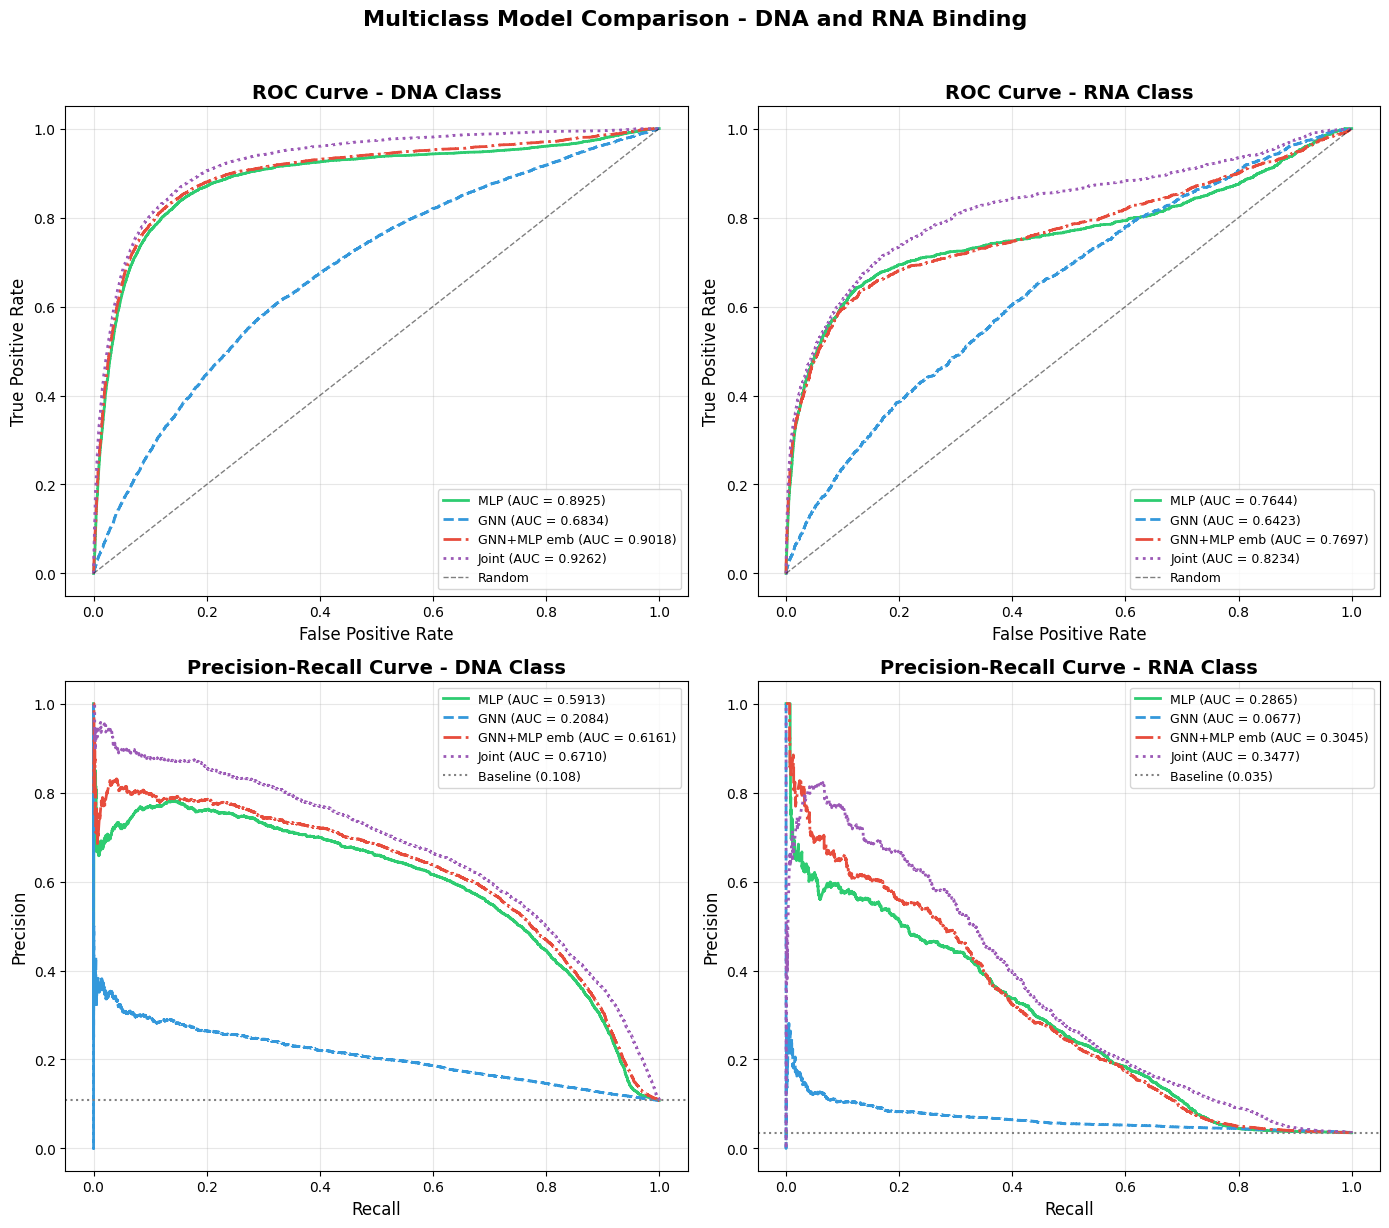


ROC AUC SUMMARY (One-vs-Rest)
Model           DNA ROC AUC     RNA ROC AUC     Macro ROC AUC  
------------------------------------------------------------
MLP             0.8925          0.7644          0.8466         
GNN             0.6834          0.6423          0.6713         
GNN+MLP emb     0.9018          0.7697          0.8495         
Joint           0.9262          0.8234          0.8816         


In [34]:
# ============================================================================
# MULTICLASS MODEL COMPARISON - ROC AND PR CURVES (DNA and RNA)
# ============================================================================
from sklearn.metrics import roc_curve
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

colors = {'MLP': '#2ecc71', 'GNN': '#3498db', 'GNN+MLP emb': '#e74c3c', 'Joint': '#9b59b6'}
linestyles = {'MLP': '-', 'GNN': '--', 'GNN+MLP emb': '-.', 'Joint': ':'}

# Store results for plotting
model_probs_multi = {
    'MLP': (mlp_labels, mlp_probs),
    'GNN': (gnn_labels, gnn_probs),
    'GNN+MLP emb': (gnn_mlp_labels, gnn_mlp_probs),
    'Joint': (joint_labels, joint_probs)
}

# ============================================================================
# ROC CURVES
# ============================================================================

# DNA (class 1) - ROC
ax1 = axes[0, 0]
for model_name, (labels, probs) in model_probs_multi.items():
    y_true_dna = (np.array(labels) == 1).astype(int)
    y_score_dna = probs[:, 1]

    fpr, tpr, _ = roc_curve(y_true_dna, y_score_dna)
    auc_score = roc_auc_score(y_true_dna, y_score_dna)

    ax1.plot(fpr, tpr, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2, label=f"{model_name} (AUC = {auc_score:.4f})")

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - DNA Class', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)

# RNA (class 2) - ROC
ax2 = axes[0, 1]
for model_name, (labels, probs) in model_probs_multi.items():
    y_true_rna = (np.array(labels) == 2).astype(int)
    y_score_rna = probs[:, 2]

    fpr, tpr, _ = roc_curve(y_true_rna, y_score_rna)
    auc_score = roc_auc_score(y_true_rna, y_score_rna)

    ax2.plot(fpr, tpr, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2, label=f"{model_name} (AUC = {auc_score:.4f})")

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve - RNA Class', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# ============================================================================
# PR CURVES
# ============================================================================

# DNA (class 1) - PR
ax3 = axes[1, 0]
baseline_dna = np.mean(np.array(mlp_labels) == 1)

for model_name, (labels, probs) in model_probs_multi.items():
    y_true_dna = (np.array(labels) == 1).astype(int)
    y_score_dna = probs[:, 1]

    precision, recall, _ = precision_recall_curve(y_true_dna, y_score_dna)
    pr_auc = average_precision_score(y_true_dna, y_score_dna)

    ax3.plot(recall, precision, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2, label=f"{model_name} (AUC = {pr_auc:.4f})")

ax3.axhline(y=baseline_dna, color='gray', linestyle=':', label=f'Baseline ({baseline_dna:.3f})')
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve - DNA Class', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# RNA (class 2) - PR
ax4 = axes[1, 1]
baseline_rna = np.mean(np.array(mlp_labels) == 2)

for model_name, (labels, probs) in model_probs_multi.items():
    y_true_rna = (np.array(labels) == 2).astype(int)
    y_score_rna = probs[:, 2]

    precision, recall, _ = precision_recall_curve(y_true_rna, y_score_rna)
    pr_auc = average_precision_score(y_true_rna, y_score_rna)

    ax4.plot(recall, precision, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2, label=f"{model_name} (AUC = {pr_auc:.4f})")

ax4.axhline(y=baseline_rna, color='gray', linestyle=':', label=f'Baseline ({baseline_rna:.3f})')
ax4.set_xlabel('Recall', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Precision-Recall Curve - RNA Class', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.suptitle('Multiclass Model Comparison - DNA and RNA Binding', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('multiclass_curves_dna_rna.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# PRINT ROC AUC SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("ROC AUC SUMMARY (One-vs-Rest)")
print(f"{'='*80}")
print(f"{'Model':<15} {'DNA ROC AUC':<15} {'RNA ROC AUC':<15} {'Macro ROC AUC':<15}")
print(f"{'-'*60}")

for model_name, (labels, probs) in model_probs_multi.items():
    y_true_dna = (np.array(labels) == 1).astype(int)
    y_true_rna = (np.array(labels) == 2).astype(int)

    roc_dna = roc_auc_score(y_true_dna, probs[:, 1])
    roc_rna = roc_auc_score(y_true_rna, probs[:, 2])
    roc_macro = roc_auc_score(np.eye(3)[labels], probs, average='macro', multi_class='ovr')

    print(f"{model_name:<15} {roc_dna:<15.4f} {roc_rna:<15.4f} {roc_macro:<15.4f}")

# 11. Models testing

## 11.1 Binary vs Multiclass Model Comparison

In [35]:
# ============================================================================
# SECTION 11: BINARY VS MULTICLASS MODEL COMPARISON
# ============================================================================
# Compare all 8 models on binary classification task
# Multiclass models: P(binding) = P(DNA) + P(RNA) = 1 - P(Non-binding)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix
)

# ============================================================================
# MODEL PATHS
# ============================================================================
MODELS_DIR = MAIN_CONFIG['models']['save_dir']  # "final_models"

# Binary models
BINARY_MODELS = {
    'MLP (binary)': os.path.join(MODELS_DIR, "MLP_only_binary.pt"),
    'GNN (binary)': os.path.join(MODELS_DIR, "GNN_structural_only_binary.pt"),
    'GNN+MLP (binary)': os.path.join(MODELS_DIR, "GNN_MLP_embeddings_binary.pt"),
    'Joint (binary)': os.path.join(MODELS_DIR, "Joint_MLPGNN_binary.pt"),
}

# Multiclass models
MULTICLASS_MODELS = {
    'MLP (multi)': os.path.join(MODELS_DIR, "MLP_multiclass.pt"),
    'GNN (multi)': os.path.join(MODELS_DIR, "GNN_structural_multiclass.pt"),
    'GNN+MLP (multi)': os.path.join(MODELS_DIR, "GNN_MLP_embeddings_multiclass.pt"),
    'Joint (multi)': os.path.join(MODELS_DIR, "Joint_MLPGNN_multiclass_weight0.2.pt"),
}

# Common threshold for confusion matrices
COMPARISON_THRESHOLD = 0.7

print("=" * 70)
print("BINARY VS MULTICLASS MODEL COMPARISON")
print("=" * 70)

# ============================================================================
# EVALUATION FUNCTION
# ============================================================================
def evaluate_binary_task(y_true, y_pred, y_probs_positive):
    """Compute comprehensive metrics for binary classification."""
    metrics = {}
    metrics['Acc'] = accuracy_score(y_true, y_pred)
    metrics['Bal Acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['Pre (macro)'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['Rec (macro)'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['F1 (macro)'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['Pre (binding)'] = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['Rec (binding)'] = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['F1 (binding)'] = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    try:
        metrics['ROC AUC'] = roc_auc_score(y_true, y_probs_positive)
        metrics['PR AUC'] = average_precision_score(y_true, y_probs_positive)
    except ValueError:
        metrics['ROC AUC'] = np.nan
        metrics['PR AUC'] = np.nan
    return metrics

# ============================================================================
# STORE ALL RESULTS
# ============================================================================
all_results = {}

# ============================================================================
# EVALUATE BINARY MODELS
# ============================================================================
print("\n" + "=" * 50)
print("EVALUATING BINARY MODELS")
print("=" * 50)

# --- MLP Binary ---
print("\nLoading MLP (binary)...")
mlp_bin_ckpt = torch.load(BINARY_MODELS['MLP (binary)'], map_location=device, weights_only=False)
mlp_bin_cfg = mlp_bin_ckpt['model_config']
mlp_bin = BindingSiteMLP(
    input_dim=mlp_bin_cfg['input_dim'],
    hidden_dims=mlp_bin_cfg['hidden_dims'],
    output_dim=mlp_bin_cfg['output_dim'],
    dropout=mlp_bin_cfg['dropout']
)
mlp_bin.load_state_dict(mlp_bin_ckpt['model_state_dict'])
mlp_bin = mlp_bin.to(device).eval()

mlp_bin_labels, mlp_bin_preds, mlp_bin_probs = [], [], []
with torch.no_grad():
    for pn, data in tqdm(test_data_cache.items(), desc="MLP (binary)"):
        emb = data['embeddings'].to(device)
        out = mlp_bin(emb, return_probs=True)
        probs_pos = out[:, 1].cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        mlp_bin_labels.extend(data['y_bin'].numpy())
        mlp_bin_preds.extend(preds)
        mlp_bin_probs.extend(probs_pos)

all_results['MLP (binary)'] = {
    'y_true': np.array(mlp_bin_labels),
    'y_pred': np.array(mlp_bin_preds),
    'y_probs': np.array(mlp_bin_probs)
}

# --- GNN Binary ---
print("\nLoading GNN (binary)...")
gnn_bin_ckpt = torch.load(BINARY_MODELS['GNN (binary)'], map_location=device, weights_only=False)
gnn_bin_cfg = gnn_bin_ckpt['model_config']
gnn_bin = BindingSiteGNN(
    input_dim=gnn_bin_cfg['input_dim'],
    hidden_dim=gnn_bin_cfg['hidden_dim'],
    heads=gnn_bin_cfg['heads'],
    dropout=gnn_bin_cfg['dropout'],
    output_dim=gnn_bin_cfg.get('output_dim', 2)
)
gnn_bin.load_state_dict(gnn_bin_ckpt['model_state_dict'])
gnn_bin = gnn_bin.to(device).eval()

gnn_bin_labels, gnn_bin_preds, gnn_bin_probs = [], [], []
with torch.no_grad():
    for pn, graph in tqdm(test_graph_cache.items(), desc="GNN (binary)"):
        graph = graph.clone().to(device)
        logits = gnn_bin(graph)
        probs = F.softmax(logits, dim=-1)
        probs_pos = probs[:, 1].cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        gnn_bin_labels.extend(graph.y.cpu().numpy())
        gnn_bin_preds.extend(preds)
        gnn_bin_probs.extend(probs_pos)

all_results['GNN (binary)'] = {
    'y_true': np.array(gnn_bin_labels),
    'y_pred': np.array(gnn_bin_preds),
    'y_probs': np.array(gnn_bin_probs)
}

# --- GNN+MLP Binary ---
print("\nLoading GNN+MLP (binary)...")
gnn_mlp_bin_ckpt = torch.load(BINARY_MODELS['GNN+MLP (binary)'], map_location=device, weights_only=False)
gnn_mlp_bin_cfg = gnn_mlp_bin_ckpt['model_config']
gnn_mlp_bin = BindingSiteGNN(
    input_dim=gnn_mlp_bin_cfg['input_dim'],
    hidden_dim=gnn_mlp_bin_cfg['hidden_dim'],
    heads=gnn_mlp_bin_cfg['heads'],
    dropout=gnn_mlp_bin_cfg['dropout'],
    output_dim=2
)
gnn_mlp_bin.load_state_dict(gnn_mlp_bin_ckpt['model_state_dict'])
gnn_mlp_bin = gnn_mlp_bin.to(device).eval()

gnn_mlp_bin_labels, gnn_mlp_bin_preds, gnn_mlp_bin_probs = [], [], []
with torch.no_grad():
    for pn, graph in tqdm(test_gnn_mlp_cache.items(), desc="GNN+MLP (binary)"):
        graph = graph.clone().to(device)
        logits = gnn_mlp_bin(graph)
        probs = F.softmax(logits, dim=-1)
        probs_pos = probs[:, 1].cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        gnn_mlp_bin_labels.extend(graph.y.cpu().numpy())
        gnn_mlp_bin_preds.extend(preds)
        gnn_mlp_bin_probs.extend(probs_pos)

all_results['GNN+MLP (binary)'] = {
    'y_true': np.array(gnn_mlp_bin_labels),
    'y_pred': np.array(gnn_mlp_bin_preds),
    'y_probs': np.array(gnn_mlp_bin_probs)
}

# --- Joint Binary ---
print("\nLoading Joint (binary)...")
joint_bin_ckpt = torch.load(BINARY_MODELS['Joint (binary)'], map_location=device, weights_only=False)
joint_bin_cfg = joint_bin_ckpt['model_config']
joint_bin = JointMLPGNN(
    mlp_config=joint_bin_cfg['mlp'],
    gnn_config=joint_bin_cfg['gnn'],
    mlp_loss_weight=joint_bin_cfg.get('mlp_loss_weight', 0.0)
)
joint_bin.load_state_dict(joint_bin_ckpt['model_state_dict'])
joint_bin = joint_bin.to(device).eval()

# Get aligned proteins for Joint model
test_proteins_joint = [p for p in test_data_cache.keys()
                       if p in test_graph_cache
                       and test_data_cache[p]['embeddings'].shape[0] == test_graph_cache[p].x.shape[0]]

joint_bin_labels, joint_bin_preds, joint_bin_probs = [], [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_joint, desc="Joint (binary)"):
        esm_emb = test_data_cache[pn]['embeddings'].to(device)
        graph = test_graph_cache[pn].clone().to(device)
        gnn_logits, _ = joint_bin(esm_emb, graph)
        probs = F.softmax(gnn_logits, dim=-1)
        probs_pos = probs[:, 1].cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        joint_bin_labels.extend(graph.y.cpu().numpy())
        joint_bin_preds.extend(preds)
        joint_bin_probs.extend(probs_pos)

all_results['Joint (binary)'] = {
    'y_true': np.array(joint_bin_labels),
    'y_pred': np.array(joint_bin_preds),
    'y_probs': np.array(joint_bin_probs)
}

# ============================================================================
# EVALUATE MULTICLASS MODELS (Binarized)
# ============================================================================
print("\n" + "=" * 50)
print("EVALUATING MULTICLASS MODELS (Binarized)")
print("=" * 50)
print("P(binding) = P(DNA) + P(RNA) = 1 - P(Non-binding)")

# --- MLP Multiclass ---
print("\nLoading MLP (multiclass)...")
mlp_multi_ckpt = torch.load(MULTICLASS_MODELS['MLP (multi)'], map_location=device, weights_only=False)
mlp_multi_cfg = mlp_multi_ckpt['model_config']
mlp_multi = BindingSiteMLP(
    input_dim=mlp_multi_cfg['input_dim'],
    hidden_dims=mlp_multi_cfg['hidden_dims'],
    output_dim=mlp_multi_cfg['output_dim'],
    dropout=mlp_multi_cfg['dropout']
)
mlp_multi.load_state_dict(mlp_multi_ckpt['model_state_dict'])
mlp_multi = mlp_multi.to(device).eval()

mlp_multi_labels, mlp_multi_preds, mlp_multi_probs = [], [], []
with torch.no_grad():
    for pn, data in tqdm(test_data_cache.items(), desc="MLP (multi->binary)"):
        emb = data['embeddings'].to(device)
        logits = mlp_multi(emb)
        probs = F.softmax(logits, dim=-1)
        # Binarize: P(binding) = P(DNA) + P(RNA) = 1 - P(Non-binding)
        probs_pos = (probs[:, 1] + probs[:, 2]).cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        mlp_multi_labels.extend(data['y_bin'].numpy())
        mlp_multi_preds.extend(preds)
        mlp_multi_probs.extend(probs_pos)

all_results['MLP (multi)'] = {
    'y_true': np.array(mlp_multi_labels),
    'y_pred': np.array(mlp_multi_preds),
    'y_probs': np.array(mlp_multi_probs)
}

# --- GNN Multiclass ---
print("\nLoading GNN (multiclass)...")
gnn_multi_ckpt = torch.load(MULTICLASS_MODELS['GNN (multi)'], map_location=device, weights_only=False)
gnn_multi_cfg = gnn_multi_ckpt['model_config']
gnn_multi = BindingSiteGNN(
    input_dim=gnn_multi_cfg['input_dim'],
    hidden_dim=gnn_multi_cfg['hidden_dim'],
    heads=gnn_multi_cfg['heads'],
    dropout=gnn_multi_cfg['dropout'],
    output_dim=3
)
gnn_multi.load_state_dict(gnn_multi_ckpt['model_state_dict'])
gnn_multi = gnn_multi.to(device).eval()

gnn_multi_labels, gnn_multi_preds, gnn_multi_probs = [], [], []
skipped_gnn_multi = 0
with torch.no_grad():
    for pn, graph in tqdm(test_graph_cache.items(), desc="GNN (multi->binary)"):
        # Need to get binary labels from test_data_cache
        if pn not in test_data_cache:
            continue

        y_bin = test_data_cache[pn]['y_bin'].numpy()

        # Check size alignment
        if len(y_bin) != graph.num_nodes:
            skipped_gnn_multi += 1
            continue

        graph = graph.clone().to(device)
        logits = gnn_multi(graph)
        probs = F.softmax(logits, dim=-1)
        probs_pos = (probs[:, 1] + probs[:, 2]).cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        gnn_multi_labels.extend(y_bin)
        gnn_multi_preds.extend(preds)
        gnn_multi_probs.extend(probs_pos)

print(f"  Skipped {skipped_gnn_multi} proteins due to size mismatch")

all_results['GNN (multi)'] = {
    'y_true': np.array(gnn_multi_labels),
    'y_pred': np.array(gnn_multi_preds),
    'y_probs': np.array(gnn_multi_probs)
}

# --- GNN+MLP Multiclass ---
# First need to create test cache with multiclass MLP embeddings
print("\nLoading GNN+MLP (multiclass)...")
gnn_mlp_multi_ckpt = torch.load(MULTICLASS_MODELS['GNN+MLP (multi)'], map_location=device, weights_only=False)
gnn_mlp_multi_cfg = gnn_mlp_multi_ckpt['model_config']
gnn_mlp_multi = BindingSiteGNN(
    input_dim=gnn_mlp_multi_cfg['input_dim'],
    hidden_dim=gnn_mlp_multi_cfg['hidden_dim'],
    heads=gnn_mlp_multi_cfg['heads'],
    dropout=gnn_mlp_multi_cfg['dropout'],
    output_dim=3
)
gnn_mlp_multi.load_state_dict(gnn_mlp_multi_ckpt['model_state_dict'])
gnn_mlp_multi = gnn_mlp_multi.to(device).eval()

# Build test cache for GNN+MLP multiclass using MLP multiclass embeddings
print("Building GNN+MLP multiclass test cache...")
test_gnn_mlp_multi_cache = {}
skipped_multi = 0
for pn in tqdm(test_data_cache.keys(), desc="Preparing GNN+MLP multi cache"):
    if pn in test_graph_cache:
        graph = test_graph_cache[pn].clone()
        esm_emb = test_data_cache[pn]['embeddings'].to(device)

        # Check size alignment before concatenation
        if esm_emb.shape[0] != graph.x.shape[0]:
            skipped_multi += 1
            continue

        mlp_emb = extract_mlp_embeddings(mlp_multi, esm_emb, device)
        graph.x = torch.cat([graph.x, mlp_emb], dim=-1)
        graph.y_bin = test_data_cache[pn]['y_bin']
        test_gnn_mlp_multi_cache[pn] = graph

print(f"  Skipped {skipped_multi} proteins due to size mismatch")

gnn_mlp_multi_labels, gnn_mlp_multi_preds, gnn_mlp_multi_probs = [], [], []
with torch.no_grad():
    for pn, graph in tqdm(test_gnn_mlp_multi_cache.items(), desc="GNN+MLP (multi->binary)"):
        graph = graph.clone().to(device)
        y_bin = graph.y_bin.cpu().numpy()
        logits = gnn_mlp_multi(graph)
        probs = F.softmax(logits, dim=-1)
        probs_pos = (probs[:, 1] + probs[:, 2]).cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        gnn_mlp_multi_labels.extend(y_bin)
        gnn_mlp_multi_preds.extend(preds)
        gnn_mlp_multi_probs.extend(probs_pos)

all_results['GNN+MLP (multi)'] = {
    'y_true': np.array(gnn_mlp_multi_labels),
    'y_pred': np.array(gnn_mlp_multi_preds),
    'y_probs': np.array(gnn_mlp_multi_probs)
}

# --- Joint Multiclass ---
print("\nLoading Joint (multiclass)...")
joint_multi_ckpt = torch.load(MULTICLASS_MODELS['Joint (multi)'], map_location=device, weights_only=False)
joint_multi_cfg = joint_multi_ckpt['model_config']
joint_multi = JointMLPGNNMulti(
    mlp_config=joint_multi_cfg['mlp'],
    gnn_config=joint_multi_cfg['gnn'],
    mlp_loss_weight=joint_multi_cfg.get('mlp_loss_weight', 0.2)
)
joint_multi.load_state_dict(joint_multi_ckpt['model_state_dict'])
joint_multi = joint_multi.to(device).eval()

joint_multi_labels, joint_multi_preds, joint_multi_probs = [], [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_joint, desc="Joint (multi->binary)"):
        esm_emb = test_data_cache[pn]['embeddings'].to(device)
        graph = test_graph_cache[pn].clone().to(device)
        y_bin = test_data_cache[pn]['y_bin'].numpy()
        gnn_logits, _ = joint_multi(esm_emb, graph)
        probs = F.softmax(gnn_logits, dim=-1)
        probs_pos = (probs[:, 1] + probs[:, 2]).cpu().numpy()
        preds = (probs_pos >= COMPARISON_THRESHOLD).astype(int)
        joint_multi_labels.extend(y_bin)
        joint_multi_preds.extend(preds)
        joint_multi_probs.extend(probs_pos)

all_results['Joint (multi)'] = {
    'y_true': np.array(joint_multi_labels),
    'y_pred': np.array(joint_multi_preds),
    'y_probs': np.array(joint_multi_probs)
}

print("\nAll models evaluated!")


BINARY VS MULTICLASS MODEL COMPARISON

EVALUATING BINARY MODELS

Loading MLP (binary)...


MLP (binary): 100%|██████████| 234/234 [00:00<00:00, 1007.73it/s]



Loading GNN (binary)...


GNN (binary): 100%|██████████| 234/234 [00:00<00:00, 293.86it/s]



Loading GNN+MLP (binary)...


GNN+MLP (binary): 100%|██████████| 234/234 [00:00<00:00, 277.52it/s]



Loading Joint (binary)...


Joint (binary): 100%|██████████| 230/230 [00:01<00:00, 229.55it/s]



EVALUATING MULTICLASS MODELS (Binarized)
P(binding) = P(DNA) + P(RNA) = 1 - P(Non-binding)

Loading MLP (multiclass)...


MLP (multi->binary): 100%|██████████| 234/234 [00:00<00:00, 971.28it/s]



Loading GNN (multiclass)...


GNN (multi->binary): 100%|██████████| 234/234 [00:00<00:00, 284.27it/s]


  Skipped 4 proteins due to size mismatch

Loading GNN+MLP (multiclass)...
Building GNN+MLP multiclass test cache...


Preparing GNN+MLP multi cache: 100%|██████████| 234/234 [00:00<00:00, 964.64it/s]


  Skipped 4 proteins due to size mismatch


GNN+MLP (multi->binary): 100%|██████████| 230/230 [00:00<00:00, 292.19it/s]



Loading Joint (multiclass)...


Joint (multi->binary): 100%|██████████| 230/230 [00:00<00:00, 244.57it/s]


All models evaluated!


### Evaluation Metircs table

In [36]:
# ============================================================================
# CREATE COMPARISON TABLE
# ============================================================================

# Compute metrics for all models
all_metrics = {}
for model_name, results in all_results.items():
    all_metrics[model_name] = evaluate_binary_task(
        results['y_true'],
        results['y_pred'],
        results['y_probs']
    )

# Define metric order
metric_order = [
    'Acc', 'Bal Acc', 'MCC',
    'Pre (macro)', 'Rec (macro)', 'F1 (macro)',
    'Pre (binding)', 'Rec (binding)', 'F1 (binding)',
    'ROC AUC', 'PR AUC'
]

# Model order: binary first, then multiclass
model_order = [
    'MLP (binary)', 'GNN (binary)', 'GNN+MLP (binary)', 'Joint (binary)',
    'MLP (multi)', 'GNN (multi)', 'GNN+MLP (multi)', 'Joint (multi)'
]

# Create DataFrame
comparison_df = pd.DataFrame({
    metric: [all_metrics[model][metric] for model in model_order]
    for metric in metric_order
}, index=model_order)

print(f"\n{'='*120}")
print(f"BINARY CLASSIFICATION: BINARY VS MULTICLASS MODELS (Threshold={COMPARISON_THRESHOLD})")
print(f"{'='*120}\n")

# Format for display
display_df = comparison_df.apply(lambda x: x.map(lambda v: f"{v:.4f}" if pd.notna(v) else "N/A"))
print(display_df.to_string())

# Highlight best in each column
print("\n" + "="*60)
print("BEST MODEL PER METRIC:")
print("="*60)
for metric in metric_order:
    best_model = comparison_df[metric].idxmax()
    best_val = comparison_df.loc[best_model, metric]
    print(f"  {metric:18s}: {best_model:20s} ({best_val:.4f})")


BINARY CLASSIFICATION: BINARY VS MULTICLASS MODELS (Threshold=0.7)

                     Acc Bal Acc     MCC Pre (macro) Rec (macro) F1 (macro) Pre (binding) Rec (binding) F1 (binding) ROC AUC  PR AUC
MLP (binary)      0.8994  0.7323  0.5325      0.8052      0.7323     0.7612        0.6872        0.5012       0.5796  0.9030  0.6524
GNN (binary)      0.8620  0.5084  0.0851      0.7165      0.5084     0.4812        0.5697        0.0190       0.0368  0.7132  0.2949
GNN+MLP (binary)  0.9024  0.7420  0.5496      0.8120      0.7420     0.7703        0.6981        0.5201       0.5961  0.8992  0.6581
Joint (binary)    0.8968  0.7161  0.5228      0.8161      0.7161     0.7521        0.7172        0.4629       0.5626  0.9031  0.6554
MLP (multi)       0.8617  0.7900  0.5095      0.7237      0.7900     0.7488        0.5004        0.6909       0.5804  0.8826  0.5456
GNN (multi)       0.7499  0.6227  0.2032      0.5841      0.6227     0.5917        0.2722        0.4443       0.3376  0.6883  0.2653


### ROC and PR Curves Visualization

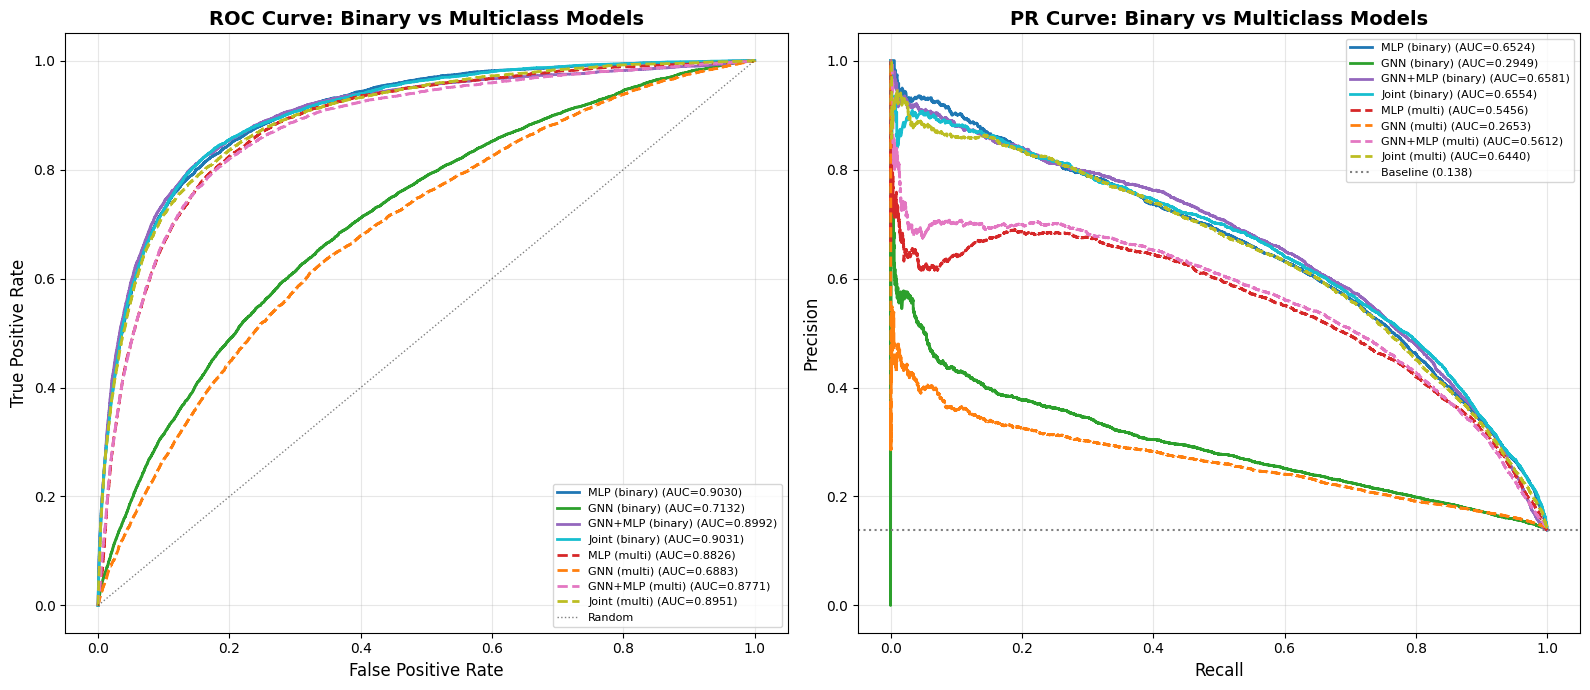

In [37]:
# ============================================================================
# ROC AND PR CURVES COMPARISON
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Color scheme: blues for binary, reds for multiclass
colors_binary = ['#1f77b4', '#2ca02c', '#9467bd', '#17becf']
colors_multi = ['#d62728', '#ff7f0e', '#e377c2', '#bcbd22']

binary_models = ['MLP (binary)', 'GNN (binary)', 'GNN+MLP (binary)', 'Joint (binary)']
multi_models = ['MLP (multi)', 'GNN (multi)', 'GNN+MLP (multi)', 'Joint (multi)']

# ROC Curves
ax1 = axes[0]

for i, model_name in enumerate(binary_models):
    results = all_results[model_name]
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_probs'])
    auc_score = all_metrics[model_name]['ROC AUC']
    ax1.plot(fpr, tpr, color=colors_binary[i], linestyle='-', linewidth=2,
             label=f"{model_name} (AUC={auc_score:.4f})")

for i, model_name in enumerate(multi_models):
    results = all_results[model_name]
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_probs'])
    auc_score = all_metrics[model_name]['ROC AUC']
    ax1.plot(fpr, tpr, color=colors_multi[i], linestyle='--', linewidth=2,
             label=f"{model_name} (AUC={auc_score:.4f})")

ax1.plot([0, 1], [0, 1], 'k:', linewidth=1, alpha=0.5, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve: Binary vs Multiclass Models', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# PR Curves
ax2 = axes[1]
baseline = np.mean(all_results['MLP (binary)']['y_true'])

for i, model_name in enumerate(binary_models):
    results = all_results[model_name]
    precision, recall, _ = precision_recall_curve(results['y_true'], results['y_probs'])
    pr_auc = all_metrics[model_name]['PR AUC']
    ax2.plot(recall, precision, color=colors_binary[i], linestyle='-', linewidth=2,
             label=f"{model_name} (AUC={pr_auc:.4f})")

for i, model_name in enumerate(multi_models):
    results = all_results[model_name]
    precision, recall, _ = precision_recall_curve(results['y_true'], results['y_probs'])
    pr_auc = all_metrics[model_name]['PR AUC']
    ax2.plot(recall, precision, color=colors_multi[i], linestyle='--', linewidth=2,
             label=f"{model_name} (AUC={pr_auc:.4f})")

ax2.axhline(y=baseline, color='gray', linestyle=':', label=f'Baseline ({baseline:.3f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('PR Curve: Binary vs Multiclass Models', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('binary_vs_multiclass_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### Confusion Matrices Comparison

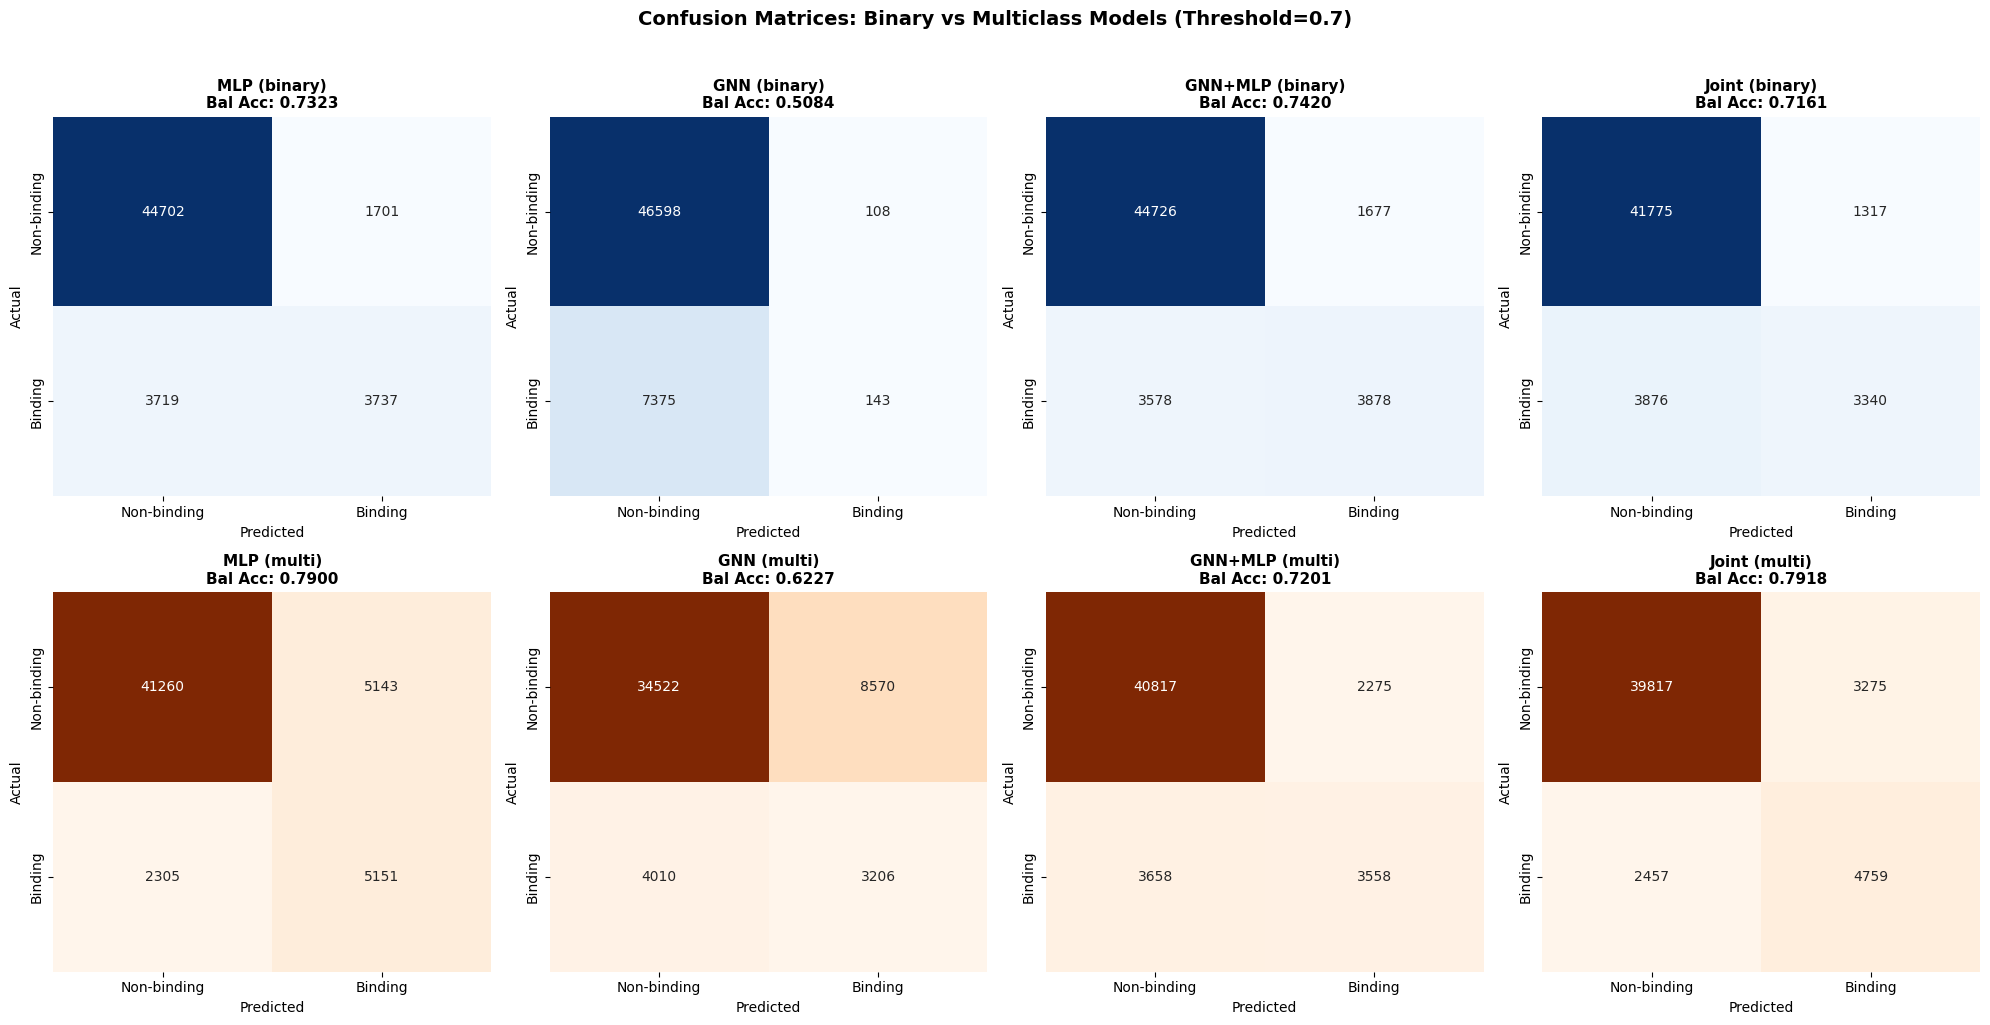


SUMMARY

Threshold used: 0.7

Binary models (solid lines, blue colormap):
  - MLP (binary): Bal Acc = 0.7323, PR AUC = 0.6524
  - GNN (binary): Bal Acc = 0.5084, PR AUC = 0.2949
  - GNN+MLP (binary): Bal Acc = 0.7420, PR AUC = 0.6581
  - Joint (binary): Bal Acc = 0.7161, PR AUC = 0.6554

Multiclass models (dashed lines, orange colormap):
  - MLP (multi): Bal Acc = 0.7900, PR AUC = 0.5456
  - GNN (multi): Bal Acc = 0.6227, PR AUC = 0.2653
  - GNN+MLP (multi): Bal Acc = 0.7201, PR AUC = 0.5612
  - Joint (multi): Bal Acc = 0.7918, PR AUC = 0.6440


In [38]:
# ============================================================================
# CONFUSION MATRICES (2x4 grid)
# ============================================================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

target_names = ['Non-binding', 'Binding']

# Row 1: Binary models
for i, model_name in enumerate(binary_models):
    ax = axes[0, i]
    results = all_results[model_name]
    cm = confusion_matrix(results['y_true'], results['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names, yticklabels=target_names,
                cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}\nBal Acc: {all_metrics[model_name]["Bal Acc"]:.4f}',
                 fontsize=11, fontweight='bold')

# Row 2: Multiclass models
for i, model_name in enumerate(multi_models):
    ax = axes[1, i]
    results = all_results[model_name]
    cm = confusion_matrix(results['y_true'], results['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax,
                xticklabels=target_names, yticklabels=target_names,
                cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}\nBal Acc: {all_metrics[model_name]["Bal Acc"]:.4f}',
                 fontsize=11, fontweight='bold')

plt.suptitle(f'Confusion Matrices: Binary vs Multiclass Models (Threshold={COMPARISON_THRESHOLD})',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('binary_vs_multiclass_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nThreshold used: {COMPARISON_THRESHOLD}")
print(f"\nBinary models (solid lines, blue colormap):")
for model_name in binary_models:
    print(f"  - {model_name}: Bal Acc = {all_metrics[model_name]['Bal Acc']:.4f}, PR AUC = {all_metrics[model_name]['PR AUC']:.4f}")

print(f"\nMulticlass models (dashed lines, orange colormap):")
for model_name in multi_models:
    print(f"  - {model_name}: Bal Acc = {all_metrics[model_name]['Bal Acc']:.4f}, PR AUC = {all_metrics[model_name]['PR AUC']:.4f}")

# 12. Multiclass task (bandymas)

In [39]:
# Compare per-class detection (DNA and RNA) across all models
# Binary models: P(binding) used for both DNA and RNA detection
# Multiclass models: P(DNA) for DNA, P(RNA) for RNA

print("=" * 70)
print("MULTICLASS TASK: BINARY VS MULTICLASS MODEL COMPARISON")
print("=" * 70)

# ============================================================================
# STORE MULTICLASS RESULTS
# ============================================================================
multiclass_results = {}

# ============================================================================
# EVALUATE BINARY MODELS ON MULTICLASS TASK
# ============================================================================
print("\n" + "=" * 50)
print("EVALUATING BINARY MODELS ON MULTICLASS TASK")
print("=" * 50)
print("Binary models use P(binding) for both DNA and RNA detection")

# --- MLP Binary ---
print("\nEvaluating MLP (binary)...")
mlp_bin_multi_labels, mlp_bin_probs_binding = [], []
with torch.no_grad():
    for pn, data in tqdm(test_data_cache.items(), desc="MLP (binary)"):
        emb = data['embeddings'].to(device)
        out = mlp_bin(emb, return_probs=True)
        probs_pos = out[:, 1].cpu().numpy()
        mlp_bin_multi_labels.extend(data['y_multi'].numpy())
        mlp_bin_probs_binding.extend(probs_pos)

mlp_bin_multi_labels = np.array(mlp_bin_multi_labels)
mlp_bin_probs_binding = np.array(mlp_bin_probs_binding)

multiclass_results['MLP (binary)'] = {
    'y_multi': mlp_bin_multi_labels,
    'probs_dna': mlp_bin_probs_binding,  # Same P(binding) for DNA
    'probs_rna': mlp_bin_probs_binding,  # Same P(binding) for RNA
}

# --- GNN Binary ---
print("\nEvaluating GNN (binary)...")
gnn_bin_multi_labels, gnn_bin_probs_binding = [], []
skipped = 0
with torch.no_grad():
    for pn, graph in tqdm(test_graph_cache.items(), desc="GNN (binary)"):
        if pn not in test_data_cache:
            continue
        y_multi = test_data_cache[pn]['y_multi'].numpy()
        if len(y_multi) != graph.num_nodes:
            skipped += 1
            continue
        graph = graph.clone().to(device)
        logits = gnn_bin(graph)
        probs = F.softmax(logits, dim=-1)
        probs_pos = probs[:, 1].cpu().numpy()
        gnn_bin_multi_labels.extend(y_multi)
        gnn_bin_probs_binding.extend(probs_pos)

print(f"  Skipped {skipped} proteins due to size mismatch")
gnn_bin_multi_labels = np.array(gnn_bin_multi_labels)
gnn_bin_probs_binding = np.array(gnn_bin_probs_binding)

multiclass_results['GNN (binary)'] = {
    'y_multi': gnn_bin_multi_labels,
    'probs_dna': gnn_bin_probs_binding,
    'probs_rna': gnn_bin_probs_binding,
}

# --- GNN+MLP Binary ---
print("\nEvaluating GNN+MLP (binary)...")
gnn_mlp_bin_multi_labels, gnn_mlp_bin_probs_binding = [], []
with torch.no_grad():
    for pn, graph in tqdm(test_gnn_mlp_cache.items(), desc="GNN+MLP (binary)"):
        if pn not in test_data_cache:
            continue
        y_multi = test_data_cache[pn]['y_multi'].numpy()
        if len(y_multi) != graph.num_nodes:
            continue
        graph = graph.clone().to(device)
        logits = gnn_mlp_bin(graph)
        probs = F.softmax(logits, dim=-1)
        probs_pos = probs[:, 1].cpu().numpy()
        gnn_mlp_bin_multi_labels.extend(y_multi)
        gnn_mlp_bin_probs_binding.extend(probs_pos)

gnn_mlp_bin_multi_labels = np.array(gnn_mlp_bin_multi_labels)
gnn_mlp_bin_probs_binding = np.array(gnn_mlp_bin_probs_binding)

multiclass_results['GNN+MLP (binary)'] = {
    'y_multi': gnn_mlp_bin_multi_labels,
    'probs_dna': gnn_mlp_bin_probs_binding,
    'probs_rna': gnn_mlp_bin_probs_binding,
}

# --- Joint Binary ---
print("\nEvaluating Joint (binary)...")
joint_bin_multi_labels, joint_bin_probs_binding = [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_joint, desc="Joint (binary)"):
        esm_emb = test_data_cache[pn]['embeddings'].to(device)
        graph = test_graph_cache[pn].clone().to(device)
        y_multi = test_data_cache[pn]['y_multi'].numpy()
        gnn_logits, _ = joint_bin(esm_emb, graph)
        probs = F.softmax(gnn_logits, dim=-1)
        probs_pos = probs[:, 1].cpu().numpy()
        joint_bin_multi_labels.extend(y_multi)
        joint_bin_probs_binding.extend(probs_pos)

joint_bin_multi_labels = np.array(joint_bin_multi_labels)
joint_bin_probs_binding = np.array(joint_bin_probs_binding)

multiclass_results['Joint (binary)'] = {
    'y_multi': joint_bin_multi_labels,
    'probs_dna': joint_bin_probs_binding,
    'probs_rna': joint_bin_probs_binding,
}

# ============================================================================
# EVALUATE MULTICLASS MODELS ON MULTICLASS TASK
# ============================================================================
print("\n" + "=" * 50)
print("EVALUATING MULTICLASS MODELS ON MULTICLASS TASK")
print("=" * 50)
print("Multiclass models use P(DNA) for DNA, P(RNA) for RNA")

# --- MLP Multiclass ---
print("\nEvaluating MLP (multiclass)...")
mlp_multi_labels_mc, mlp_multi_probs_dna, mlp_multi_probs_rna = [], [], []
with torch.no_grad():
    for pn, data in tqdm(test_data_cache.items(), desc="MLP (multi)"):
        emb = data['embeddings'].to(device)
        logits = mlp_multi(emb)
        probs = F.softmax(logits, dim=-1)
        mlp_multi_labels_mc.extend(data['y_multi'].numpy())
        mlp_multi_probs_dna.extend(probs[:, 1].cpu().numpy())
        mlp_multi_probs_rna.extend(probs[:, 2].cpu().numpy())

multiclass_results['MLP (multi)'] = {
    'y_multi': np.array(mlp_multi_labels_mc),
    'probs_dna': np.array(mlp_multi_probs_dna),
    'probs_rna': np.array(mlp_multi_probs_rna),
}

# --- GNN Multiclass ---
print("\nEvaluating GNN (multiclass)...")
gnn_multi_labels_mc, gnn_multi_probs_dna, gnn_multi_probs_rna = [], [], []
skipped = 0
with torch.no_grad():
    for pn, graph in tqdm(test_graph_cache.items(), desc="GNN (multi)"):
        if pn not in test_data_cache:
            continue
        y_multi = test_data_cache[pn]['y_multi'].numpy()
        if len(y_multi) != graph.num_nodes:
            skipped += 1
            continue
        graph = graph.clone().to(device)
        logits = gnn_multi(graph)
        probs = F.softmax(logits, dim=-1)
        gnn_multi_labels_mc.extend(y_multi)
        gnn_multi_probs_dna.extend(probs[:, 1].cpu().numpy())
        gnn_multi_probs_rna.extend(probs[:, 2].cpu().numpy())

print(f"  Skipped {skipped} proteins due to size mismatch")

multiclass_results['GNN (multi)'] = {
    'y_multi': np.array(gnn_multi_labels_mc),
    'probs_dna': np.array(gnn_multi_probs_dna),
    'probs_rna': np.array(gnn_multi_probs_rna),
}

# --- GNN+MLP Multiclass ---
print("\nEvaluating GNN+MLP (multiclass)...")
gnn_mlp_multi_labels_mc, gnn_mlp_multi_probs_dna, gnn_mlp_multi_probs_rna = [], [], []
with torch.no_grad():
    for pn, graph in tqdm(test_gnn_mlp_multi_cache.items(), desc="GNN+MLP (multi)"):
        if pn not in test_data_cache:
            continue
        y_multi = test_data_cache[pn]['y_multi'].numpy()
        if len(y_multi) != graph.num_nodes:
            continue
        graph = graph.clone().to(device)
        logits = gnn_mlp_multi(graph)
        probs = F.softmax(logits, dim=-1)
        gnn_mlp_multi_labels_mc.extend(y_multi)
        gnn_mlp_multi_probs_dna.extend(probs[:, 1].cpu().numpy())
        gnn_mlp_multi_probs_rna.extend(probs[:, 2].cpu().numpy())

multiclass_results['GNN+MLP (multi)'] = {
    'y_multi': np.array(gnn_mlp_multi_labels_mc),
    'probs_dna': np.array(gnn_mlp_multi_probs_dna),
    'probs_rna': np.array(gnn_mlp_multi_probs_rna),
}

# --- Joint Multiclass ---
print("\nEvaluating Joint (multiclass)...")
joint_multi_labels_mc, joint_multi_probs_dna, joint_multi_probs_rna = [], [], []
with torch.no_grad():
    for pn in tqdm(test_proteins_joint, desc="Joint (multi)"):
        esm_emb = test_data_cache[pn]['embeddings'].to(device)
        graph = test_graph_cache[pn].clone().to(device)
        y_multi = test_data_cache[pn]['y_multi'].numpy()
        gnn_logits, _ = joint_multi(esm_emb, graph)
        probs = F.softmax(gnn_logits, dim=-1)
        joint_multi_labels_mc.extend(y_multi)
        joint_multi_probs_dna.extend(probs[:, 1].cpu().numpy())
        joint_multi_probs_rna.extend(probs[:, 2].cpu().numpy())

multiclass_results['Joint (multi)'] = {
    'y_multi': np.array(joint_multi_labels_mc),
    'probs_dna': np.array(joint_multi_probs_dna),
    'probs_rna': np.array(joint_multi_probs_rna),
}

print("\nAll models evaluated on multiclass task!")

MULTICLASS TASK: BINARY VS MULTICLASS MODEL COMPARISON

EVALUATING BINARY MODELS ON MULTICLASS TASK
Binary models use P(binding) for both DNA and RNA detection

Evaluating MLP (binary)...


MLP (binary): 100%|██████████| 234/234 [00:00<00:00, 1018.66it/s]



Evaluating GNN (binary)...


GNN (binary): 100%|██████████| 234/234 [00:00<00:00, 312.40it/s]


  Skipped 4 proteins due to size mismatch

Evaluating GNN+MLP (binary)...


GNN+MLP (binary): 100%|██████████| 234/234 [00:00<00:00, 296.13it/s]



Evaluating Joint (binary)...


Joint (binary): 100%|██████████| 230/230 [00:00<00:00, 245.56it/s]



EVALUATING MULTICLASS MODELS ON MULTICLASS TASK
Multiclass models use P(DNA) for DNA, P(RNA) for RNA

Evaluating MLP (multiclass)...


MLP (multi): 100%|██████████| 234/234 [00:00<00:00, 962.23it/s]



Evaluating GNN (multiclass)...


GNN (multi): 100%|██████████| 234/234 [00:00<00:00, 333.68it/s]


  Skipped 4 proteins due to size mismatch

Evaluating GNN+MLP (multiclass)...


GNN+MLP (multi): 100%|██████████| 230/230 [00:00<00:00, 292.45it/s]



Evaluating Joint (multiclass)...


Joint (multi): 100%|██████████| 230/230 [00:00<00:00, 255.29it/s]


All models evaluated on multiclass task!


In [40]:
# ============================================================================
# PER-CLASS METRICS TABLE
# ============================================================================

def compute_perclass_metrics(y_multi, probs_dna, probs_rna):
    """Compute ROC AUC and PR AUC for DNA and RNA classes."""
    metrics = {}

    # DNA detection (class 1 vs rest)
    y_true_dna = (y_multi == 1).astype(int)
    try:
        metrics['ROC AUC (DNA)'] = roc_auc_score(y_true_dna, probs_dna)
        metrics['PR AUC (DNA)'] = average_precision_score(y_true_dna, probs_dna)
    except ValueError:
        metrics['ROC AUC (DNA)'] = np.nan
        metrics['PR AUC (DNA)'] = np.nan

    # RNA detection (class 2 vs rest)
    y_true_rna = (y_multi == 2).astype(int)
    try:
        metrics['ROC AUC (RNA)'] = roc_auc_score(y_true_rna, probs_rna)
        metrics['PR AUC (RNA)'] = average_precision_score(y_true_rna, probs_rna)
    except ValueError:
        metrics['ROC AUC (RNA)'] = np.nan
        metrics['PR AUC (RNA)'] = np.nan

    return metrics

# Compute metrics for all models
perclass_metrics = {}
for model_name, results in multiclass_results.items():
    perclass_metrics[model_name] = compute_perclass_metrics(
        results['y_multi'],
        results['probs_dna'],
        results['probs_rna']
    )

# Model order
model_order = [
    'MLP (binary)', 'GNN (binary)', 'GNN+MLP (binary)', 'Joint (binary)',
    'MLP (multi)', 'GNN (multi)', 'GNN+MLP (multi)', 'Joint (multi)'
]

metric_order = ['ROC AUC (DNA)', 'PR AUC (DNA)', 'ROC AUC (RNA)', 'PR AUC (RNA)']

# Create DataFrame
perclass_df = pd.DataFrame({
    metric: [perclass_metrics[model][metric] for model in model_order]
    for metric in metric_order
}, index=model_order)

print(f"\n{'='*80}")
print("PER-CLASS DETECTION: BINARY VS MULTICLASS MODELS")
print(f"{'='*80}")
print("\nBinary models use P(binding) for both DNA and RNA detection")
print("Multiclass models use P(DNA) for DNA, P(RNA) for RNA\n")

# Format for display
display_df = perclass_df.apply(lambda x: x.map(lambda v: f"{v:.4f}" if pd.notna(v) else "N/A"))
print(display_df.to_string())

# Show class distribution
sample_labels = multiclass_results['MLP (binary)']['y_multi']
print(f"\n\nTest set class distribution:")
print(f"  Non-binding (0): {np.sum(sample_labels == 0):,} ({100*np.mean(sample_labels == 0):.1f}%)")
print(f"  DNA (1):         {np.sum(sample_labels == 1):,} ({100*np.mean(sample_labels == 1):.1f}%)")
print(f"  RNA (2):         {np.sum(sample_labels == 2):,} ({100*np.mean(sample_labels == 2):.1f}%)")

# Best model per metric
print("\n" + "="*60)
print("BEST MODEL PER METRIC:")
print("="*60)
for metric in metric_order:
    best_model = perclass_df[metric].idxmax()
    best_val = perclass_df.loc[best_model, metric]
    print(f"  {metric:18s}: {best_model:20s} ({best_val:.4f})")

# Improvement of multiclass over binary
print("\n" + "="*60)
print("MULTICLASS IMPROVEMENT OVER BINARY (same architecture):")
print("="*60)
architectures = ['MLP', 'GNN', 'GNN+MLP', 'Joint']
for arch in architectures:
    bin_name = f'{arch} (binary)'
    multi_name = f'{arch} (multi)'
    for target in ['DNA', 'RNA']:
        metric = f'PR AUC ({target})'
        bin_val = perclass_metrics[bin_name][metric]
        multi_val = perclass_metrics[multi_name][metric]
        diff = multi_val - bin_val
        pct = 100 * diff / bin_val if bin_val > 0 else 0
        print(f"  {arch:10s} {target}: {bin_val:.4f} -> {multi_val:.4f} ({diff:+.4f}, {pct:+.1f}%)")


PER-CLASS DETECTION: BINARY VS MULTICLASS MODELS

Binary models use P(binding) for both DNA and RNA detection
Multiclass models use P(DNA) for DNA, P(RNA) for RNA

                 ROC AUC (DNA) PR AUC (DNA) ROC AUC (RNA) PR AUC (RNA)
MLP (binary)            0.9106       0.6243        0.7956       0.0845
GNN (binary)            0.7186       0.2396        0.6489       0.0642
GNN+MLP (binary)        0.9057       0.6213        0.7957       0.0878
Joint (binary)          0.9091       0.6068        0.7962       0.0894
MLP (multi)             0.8914       0.5871        0.7489       0.2723
GNN (multi)             0.6834       0.2084        0.6423       0.0677
GNN+MLP (multi)         0.9018       0.6161        0.7697       0.3045
Joint (multi)           0.9262       0.6710        0.8234       0.3477


Test set class distribution:
  Non-binding (0): 46,403 (86.2%)
  DNA (1):         5,574 (10.3%)
  RNA (2):         1,882 (3.5%)

BEST MODEL PER METRIC:
  ROC AUC (DNA)     : Joint (multi)       

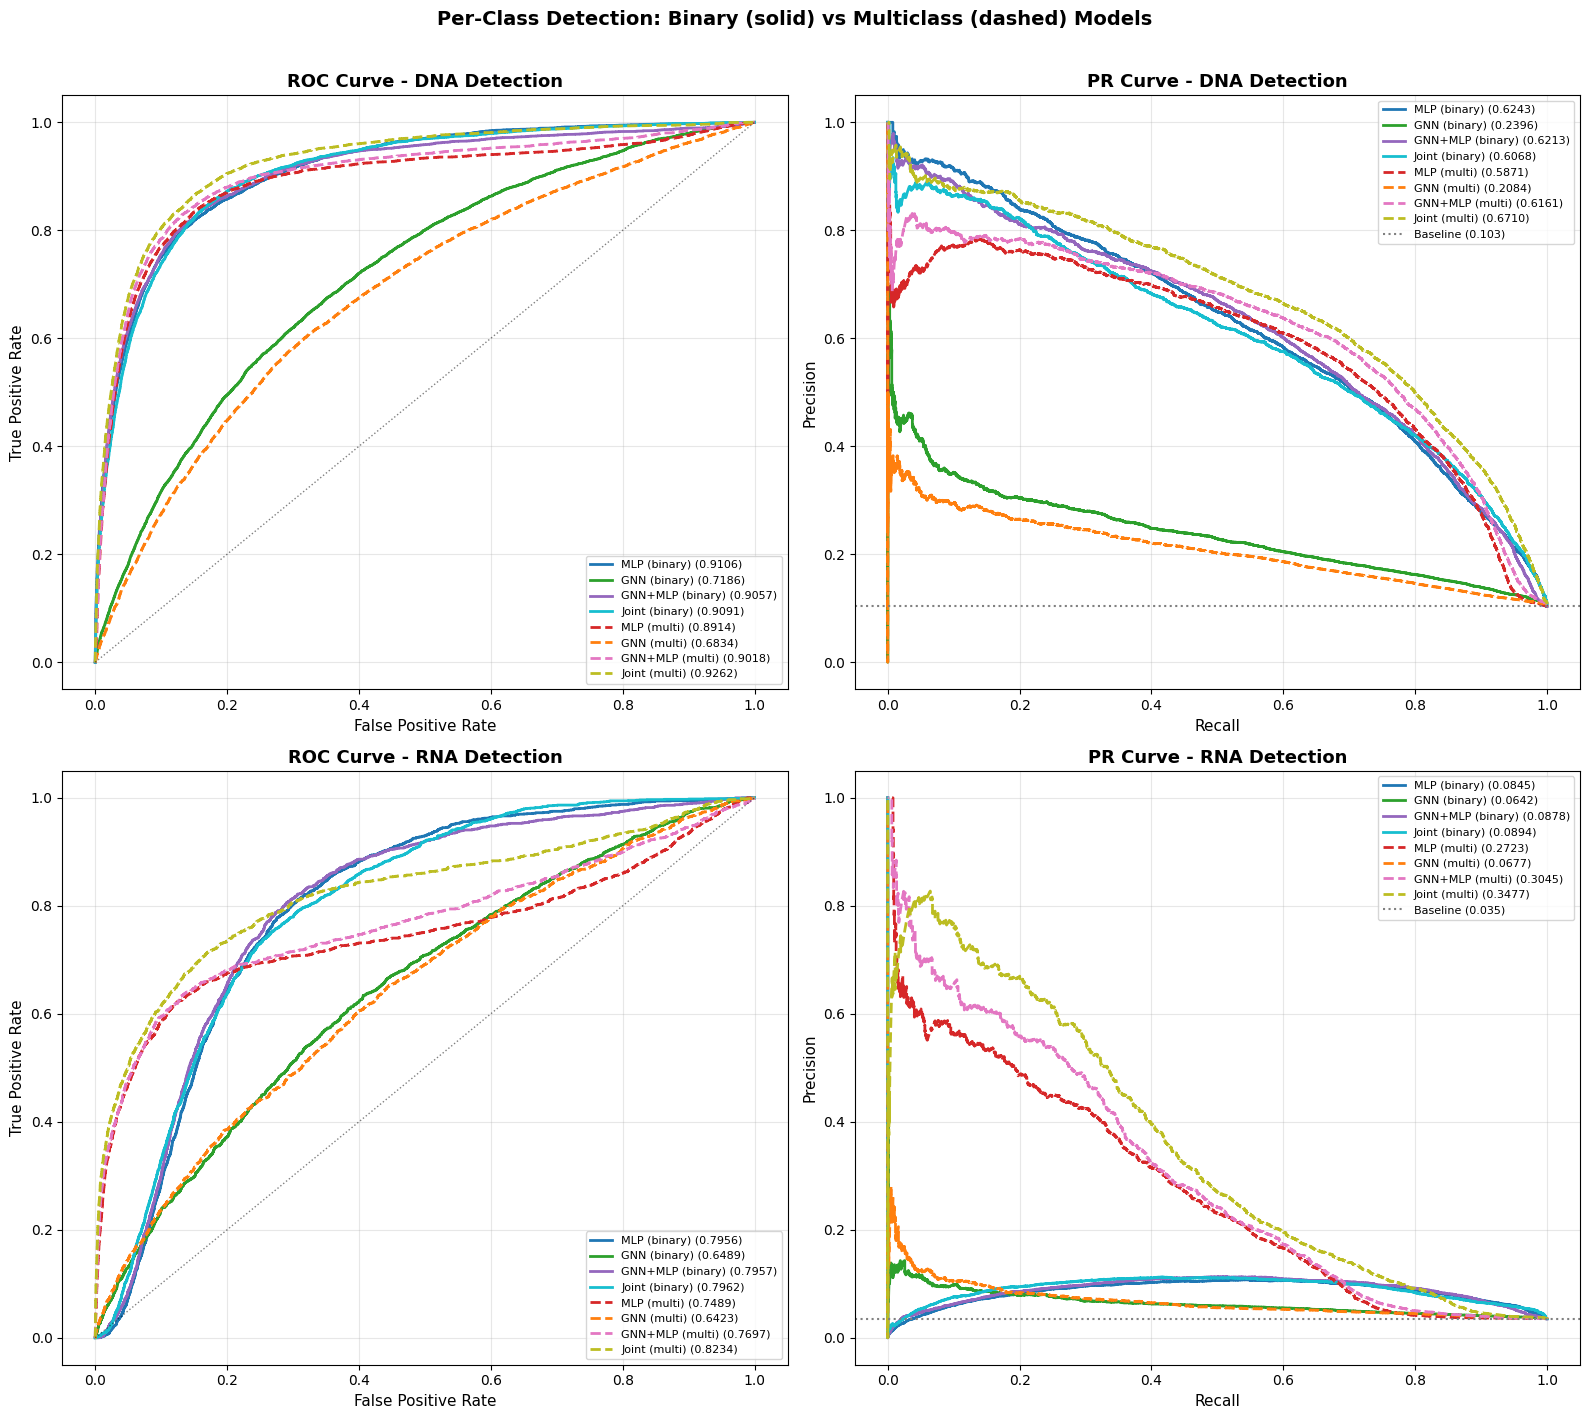

In [41]:
# ============================================================================
# ROC AND PR CURVES FOR DNA AND RNA
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

colors_binary = ['#1f77b4', '#2ca02c', '#9467bd', '#17becf']
colors_multi = ['#d62728', '#ff7f0e', '#e377c2', '#bcbd22']

binary_models = ['MLP (binary)', 'GNN (binary)', 'GNN+MLP (binary)', 'Joint (binary)']
multi_models = ['MLP (multi)', 'GNN (multi)', 'GNN+MLP (multi)', 'Joint (multi)']

# ============================================================================
# DNA Detection
# ============================================================================
# ROC - DNA
ax1 = axes[0, 0]
for i, model_name in enumerate(binary_models):
    results = multiclass_results[model_name]
    y_true_dna = (results['y_multi'] == 1).astype(int)
    fpr, tpr, _ = roc_curve(y_true_dna, results['probs_dna'])
    auc_score = perclass_metrics[model_name]['ROC AUC (DNA)']
    ax1.plot(fpr, tpr, color=colors_binary[i], linestyle='-', linewidth=2,
             label=f"{model_name} ({auc_score:.4f})")

for i, model_name in enumerate(multi_models):
    results = multiclass_results[model_name]
    y_true_dna = (results['y_multi'] == 1).astype(int)
    fpr, tpr, _ = roc_curve(y_true_dna, results['probs_dna'])
    auc_score = perclass_metrics[model_name]['ROC AUC (DNA)']
    ax1.plot(fpr, tpr, color=colors_multi[i], linestyle='--', linewidth=2,
             label=f"{model_name} ({auc_score:.4f})")

ax1.plot([0, 1], [0, 1], 'k:', linewidth=1, alpha=0.5)
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curve - DNA Detection', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# PR - DNA
ax2 = axes[0, 1]
baseline_dna = np.mean(multiclass_results['MLP (binary)']['y_multi'] == 1)

for i, model_name in enumerate(binary_models):
    results = multiclass_results[model_name]
    y_true_dna = (results['y_multi'] == 1).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_dna, results['probs_dna'])
    pr_auc = perclass_metrics[model_name]['PR AUC (DNA)']
    ax2.plot(recall, precision, color=colors_binary[i], linestyle='-', linewidth=2,
             label=f"{model_name} ({pr_auc:.4f})")

for i, model_name in enumerate(multi_models):
    results = multiclass_results[model_name]
    y_true_dna = (results['y_multi'] == 1).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_dna, results['probs_dna'])
    pr_auc = perclass_metrics[model_name]['PR AUC (DNA)']
    ax2.plot(recall, precision, color=colors_multi[i], linestyle='--', linewidth=2,
             label=f"{model_name} ({pr_auc:.4f})")

ax2.axhline(y=baseline_dna, color='gray', linestyle=':', label=f'Baseline ({baseline_dna:.3f})')
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('PR Curve - DNA Detection', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# ============================================================================
# RNA Detection
# ============================================================================
# ROC - RNA
ax3 = axes[1, 0]
for i, model_name in enumerate(binary_models):
    results = multiclass_results[model_name]
    y_true_rna = (results['y_multi'] == 2).astype(int)
    fpr, tpr, _ = roc_curve(y_true_rna, results['probs_rna'])
    auc_score = perclass_metrics[model_name]['ROC AUC (RNA)']
    ax3.plot(fpr, tpr, color=colors_binary[i], linestyle='-', linewidth=2,
             label=f"{model_name} ({auc_score:.4f})")

for i, model_name in enumerate(multi_models):
    results = multiclass_results[model_name]
    y_true_rna = (results['y_multi'] == 2).astype(int)
    fpr, tpr, _ = roc_curve(y_true_rna, results['probs_rna'])
    auc_score = perclass_metrics[model_name]['ROC AUC (RNA)']
    ax3.plot(fpr, tpr, color=colors_multi[i], linestyle='--', linewidth=2,
             label=f"{model_name} ({auc_score:.4f})")

ax3.plot([0, 1], [0, 1], 'k:', linewidth=1, alpha=0.5)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curve - RNA Detection', fontsize=13, fontweight='bold')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(True, alpha=0.3)

# PR - RNA
ax4 = axes[1, 1]
baseline_rna = np.mean(multiclass_results['MLP (binary)']['y_multi'] == 2)

for i, model_name in enumerate(binary_models):
    results = multiclass_results[model_name]
    y_true_rna = (results['y_multi'] == 2).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_rna, results['probs_rna'])
    pr_auc = perclass_metrics[model_name]['PR AUC (RNA)']
    ax4.plot(recall, precision, color=colors_binary[i], linestyle='-', linewidth=2,
             label=f"{model_name} ({pr_auc:.4f})")

for i, model_name in enumerate(multi_models):
    results = multiclass_results[model_name]
    y_true_rna = (results['y_multi'] == 2).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_rna, results['probs_rna'])
    pr_auc = perclass_metrics[model_name]['PR AUC (RNA)']
    ax4.plot(recall, precision, color=colors_multi[i], linestyle='--', linewidth=2,
             label=f"{model_name} ({pr_auc:.4f})")

ax4.axhline(y=baseline_rna, color='gray', linestyle=':', label=f'Baseline ({baseline_rna:.3f})')
ax4.set_xlabel('Recall', fontsize=11)
ax4.set_ylabel('Precision', fontsize=11)
ax4.set_title('PR Curve - RNA Detection', fontsize=13, fontweight='bold')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.suptitle('Per-Class Detection: Binary (solid) vs Multiclass (dashed) Models',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('multiclass_task_curves.png', dpi=150, bbox_inches='tight')
plt.show()

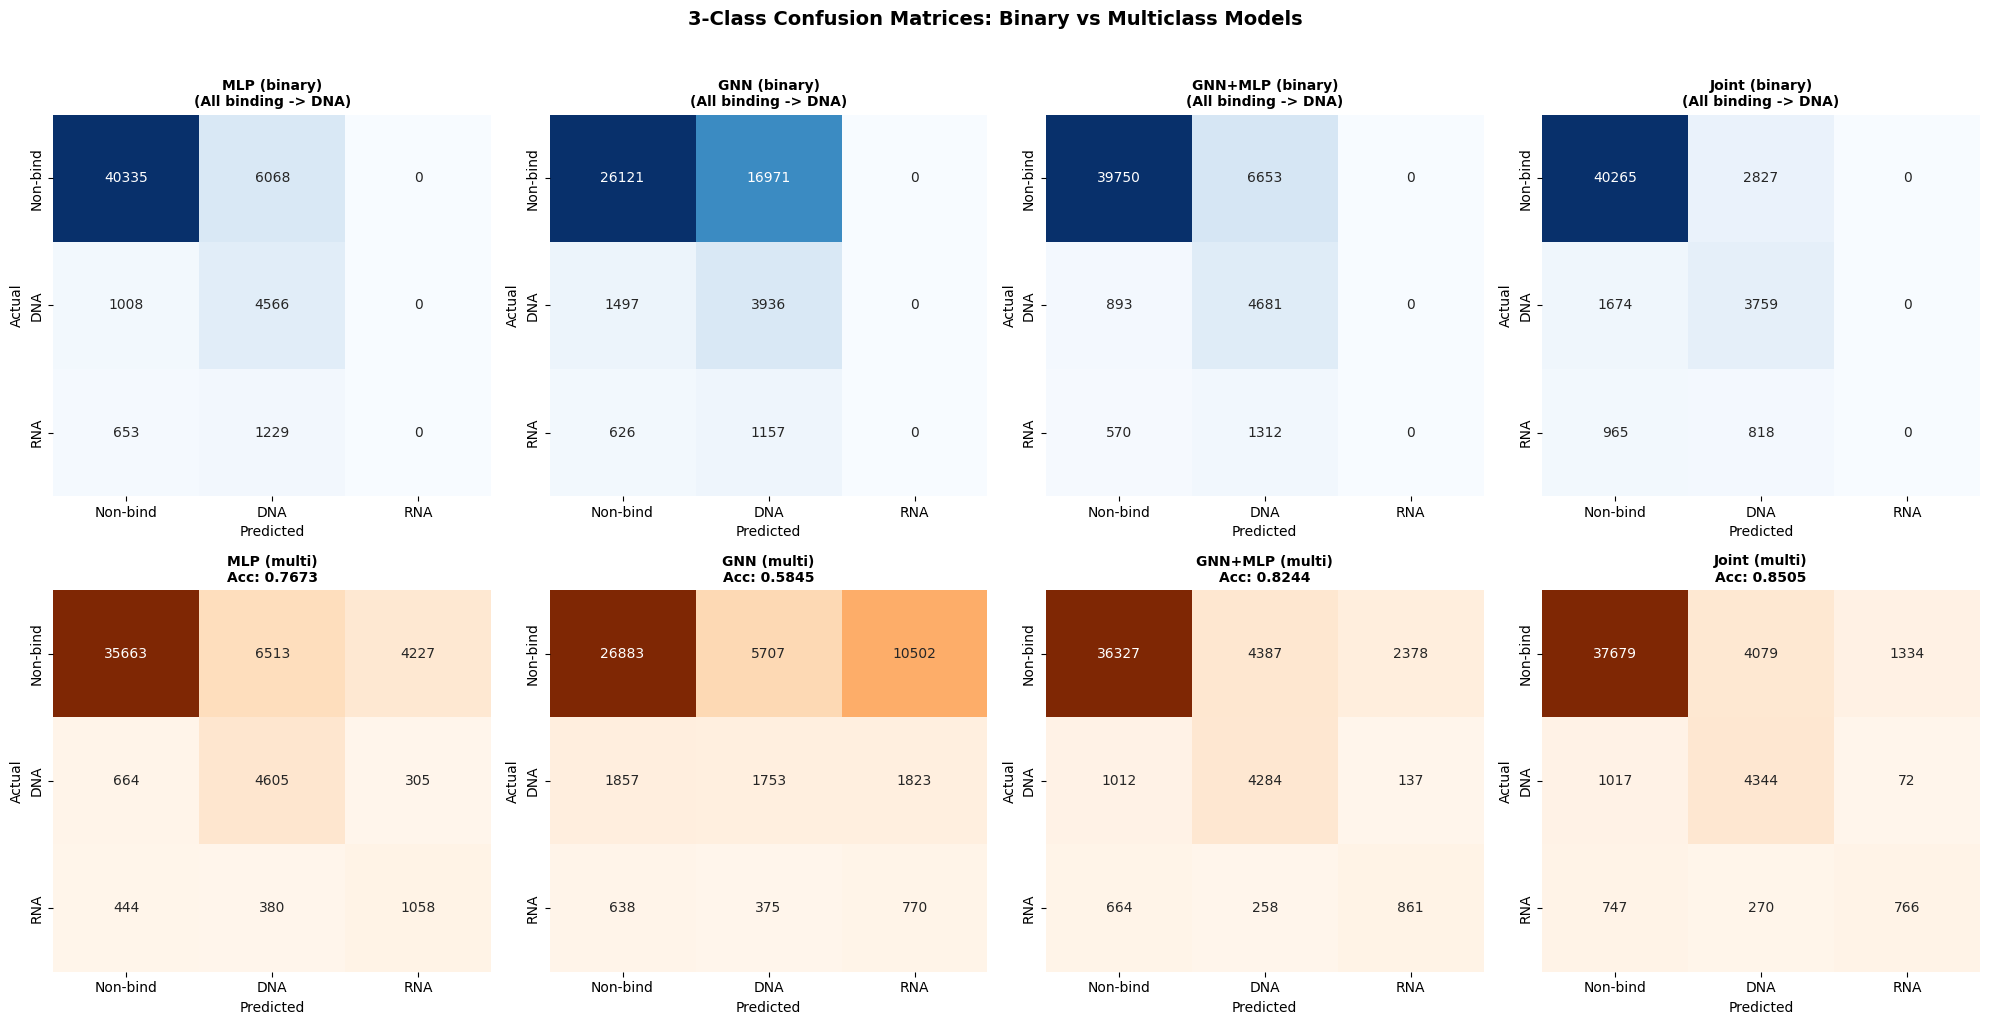


SUMMARY: MULTICLASS TASK

Binary models (top row):
  - Can only predict 'binding' vs 'non-binding'
  - Cannot distinguish DNA from RNA
  - All binding predictions shown as 'DNA' in confusion matrix

Multiclass models (bottom row):
  - Can predict all 3 classes
  - Specialized for DNA vs RNA distinction

Key insight: Compare RNA column in confusion matrices
  - Binary models: 0 predictions for RNA (all go to DNA)
  - Multiclass models: actual RNA predictions


In [42]:
# ============================================================================
# 3-CLASS CONFUSION MATRICES
# ============================================================================
# For binary models: predict "binding" then can't distinguish DNA/RNA
# For multiclass models: predict actual class

MULTICLASS_THRESHOLD = 0.5

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
target_names_3class = ['Non-bind', 'DNA', 'RNA']

# Function to get 3-class predictions
def get_3class_predictions(y_multi, probs_dna, probs_rna, threshold, is_binary=False):
    """
    Get 3-class predictions.
    For binary models: predict binding if P(binding) > threshold, but can't distinguish DNA/RNA
                       so we assign to whichever has more samples in ground truth (or DNA by default)
    For multiclass: predict class with highest probability
    """
    n = len(y_multi)
    preds = np.zeros(n, dtype=int)

    if is_binary:
        # Binary model: probs_dna == probs_rna == P(binding)
        # Predict binding if > threshold, assign to "DNA" (class 1) as placeholder
        # since binary can't distinguish
        binding_mask = probs_dna >= threshold
        preds[binding_mask] = 1  # Assign all binding to DNA (shows limitation)
    else:
        # Multiclass: build full probability matrix and take argmax
        probs_nonbind = 1 - probs_dna - probs_rna
        probs_nonbind = np.clip(probs_nonbind, 0, 1)  # Ensure valid
        probs_matrix = np.stack([probs_nonbind, probs_dna, probs_rna], axis=1)
        preds = np.argmax(probs_matrix, axis=1)

    return preds

# Row 1: Binary models
for i, model_name in enumerate(binary_models):
    ax = axes[0, i]
    results = multiclass_results[model_name]
    y_true = results['y_multi']
    y_pred = get_3class_predictions(
        y_true, results['probs_dna'], results['probs_rna'],
        MULTICLASS_THRESHOLD, is_binary=True
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names_3class, yticklabels=target_names_3class,
                cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}\n(All binding -> DNA)',
                 fontsize=10, fontweight='bold')

# Row 2: Multiclass models
for i, model_name in enumerate(multi_models):
    ax = axes[1, i]
    results = multiclass_results[model_name]
    y_true = results['y_multi']
    y_pred = get_3class_predictions(
        y_true, results['probs_dna'], results['probs_rna'],
        MULTICLASS_THRESHOLD, is_binary=False
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax,
                xticklabels=target_names_3class, yticklabels=target_names_3class,
                cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Calculate per-class accuracy
    acc_3class = accuracy_score(y_true, y_pred)
    ax.set_title(f'{model_name}\nAcc: {acc_3class:.4f}',
                 fontsize=10, fontweight='bold')

plt.suptitle('3-Class Confusion Matrices: Binary vs Multiclass Models',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('multiclass_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("SUMMARY: MULTICLASS TASK")
print("="*70)
print("\nBinary models (top row):")
print("  - Can only predict 'binding' vs 'non-binding'")
print("  - Cannot distinguish DNA from RNA")
print("  - All binding predictions shown as 'DNA' in confusion matrix")

print("\nMulticlass models (bottom row):")
print("  - Can predict all 3 classes")
print("  - Specialized for DNA vs RNA distinction")

print("\nKey insight: Compare RNA column in confusion matrices")
print("  - Binary models: 0 predictions for RNA (all go to DNA)")
print("  - Multiclass models: actual RNA predictions")